In [2]:
!pip install geopandas
!pip install earthpy
!pip install mlxtend

     |████████████████████████████████| 1.3 MB 1.1 MB/s eta 0:00:01


In [321]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize, PowerTransformer, power_transform, scale, StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import calendar
import os
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import earthpy as et
from tqdm.notebook import tqdm
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import json

%matplotlib inline

In [2]:
!wget --directory-prefix=../data/covid/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/covid/covid_month.csv
!wget --directory-prefix=../data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/social_explorer_processed_data.csv
!wget --directory-prefix=../data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/social_explorer_processed_data_only_percents.csv
!wget -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/shape/la_shape.zip
!unzip -nq la_shape -d shape

# LA County Shapefile

In [444]:
# Graph neighbors of a region
def graph_neighbors(df2, region):
    df2['plot_col'] = 0
    df2.plot_col = df2.plot_col.mask(df2['region'] == region, 1)
    temp_n = df2[df2.region == region].neighbors.values[0].split(',')
    temp_n = [n.strip() for n in temp_n]
    for n in temp_n:
        df2.plot_col = df2.plot_col.mask(df2['region'] == n, 2)
    ax = df2.plot(column='plot_col', figsize=(10,10))
    green_patch = mpatches.Patch(color='green', label='Covering Polygon')
    yellow_patch = mpatches.Patch(color='yellow', label='Bordering Regions')
    purple_patch = mpatches.Patch(color='purple', label='Inner LA County')
    plt.legend(handles=[green_patch, yellow_patch, purple_patch])
#     ax.annotate()
#     df2.apply(lambda x: ax.annotate(s=x.region, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
    
# Graph region
def graph_region(df2, region):
    df2['plot_col'] = 0
    df2.plot_col = df2.plot_col.mask(df2['region'] == region, 1)

    df2.plot(column='plot_col', figsize=(10,10), alpha=0.5)
    
def remove_missing_neighbors(df2):
    df2 = df.copy(deep=True)
    df2["neighbors"] = None  # add NEIGHBORS column
    df2["plot_col"] = 0 # Column used to graph neighbors
    # Create a polygon that covers the entire la county region
    cover = gpd.GeoSeries(Polygon([(-119.4,35), (-119.4,33.2), (-117,33.2), (-117,35)])).set_crs(epsg=4269)
    # Remove Catalina Island since it is an island which has no neighbors
    la_noisland = df2[df2['region']!='Unincorporated Catalina Island']
    # Remove small holes within the la county unary union polygon
    no_holes = MultiPolygon(Polygon(p.exterior) for p in la_noisland.geometry.unary_union)
    no_holes_series = gpd.GeoSeries(no_holes).set_crs(epsg=4269)
    # Subtract la county from the covering polygon
    diff = gpd.GeoSeries.difference(cover, no_holes_series)
    # We can find the cities that are touching 'diff' to locate border cities
    # diff.plot(figsize=(5,5))
    # Get neighbors of diff to obtain bordered regions
    border_regions = df2[~df2.geometry.disjoint(diff[0])].region.tolist()
    
    df2.loc[len(df2)] = ["COVER", diff[0], ", ".join(border_regions), 0]
    graph_neighbors(df2, 'COVER')
    df2 = df2[:-1]

In [4]:
# la_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
la_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
la_filtered = la_shapes.rename(columns={'name':'region'})
la_filtered["plot_col"] = 0 # Column used to graph neighbors
la_filtered = la_filtered[['region','geometry','plot_col']]
la_filtered.head()

region                                           geometry  \
0            Acton  POLYGON ((-118.20262 34.53899, -118.18947 34.5...   
1  Adams-Normandie  POLYGON ((-118.30901 34.03741, -118.30041 34.0...   
2     Agoura Hills  POLYGON ((-118.76193 34.16820, -118.72632 34.1...   
3       Agua Dulce  POLYGON ((-118.25468 34.55830, -118.25551 34.5...   
4         Alhambra  POLYGON ((-118.12175 34.10504, -118.11687 34.1...   

   plot_col  
0         0  
1         0  
2         0  
3         0  
4         0

## Smooth/process COVID data

In [5]:
!wget --directory-prefix=../data/covid -Nq https://raw.githubusercontent.com/ANRGUSC/lacounty_covid19_data/master/data/Covid-19.csv
covid_filename = '../data/covid/Covid-19.csv'

covid_df = pd.read_csv(covid_filename)
covid_df = covid_df.rename(columns={'Region':'region', 'Number of cases':'cases'})
covid_df.head()

Time Stamp         region   Latitude   Longitude  cases
0  03-16-2020       Alhambra  34.093042 -118.127060      2
1  03-16-2020        Arcadia  34.136208 -118.040150      1
2  03-16-2020  Beverly Hills  34.069650 -118.396306      1
3  03-16-2020  Boyle Heights  34.043689 -118.209768      5
4  03-16-2020         Carson  33.832204 -118.251755      1

In [6]:
# Set COVID cases to not be less than previously recorded - it should be a non-decreasing function
for region in covid_df["region"].unique():
  df = covid_df[covid_df['region'] == region]
  prev_cases = 0
  for idx, row in df.iterrows():
    if prev_cases > row['cases']:
      covid_df.loc[idx, 'cases'] =  prev_cases
    else:
      prev_cases = row['cases']

In [7]:
for region in covid_df["region"].unique():
  df = covid_df[covid_df['region'] == region]
  prev_cases = 0
  for idx, row in df.iterrows():
    covid_df.loc[idx, 'active_cases'] =  row['cases'] - prev_cases
    prev_cases = row['cases']
covid_df[covid_df['region'] == 'Alhambra']

Time Stamp    region   Latitude  Longitude  cases  active_cases
0      03-16-2020  Alhambra  34.093042 -118.12706      2           2.0
31     03-17-2020  Alhambra  34.093042 -118.12706      2           0.0
73     03-18-2020  Alhambra  34.093042 -118.12706      2           0.0
118    03-19-2020  Alhambra  34.093042 -118.12706      2           0.0
188    03-20-2020  Alhambra  34.093042 -118.12706      3           1.0
...           ...       ...        ...        ...    ...           ...
53610   11-2-2020  Alhambra  34.093042 -118.12706   1454           4.0
53849   11-3-2020  Alhambra  34.093042 -118.12706   1458           4.0
54088   11-4-2020  Alhambra  34.093042 -118.12706   1467           9.0
54326   11-5-2020  Alhambra  34.093042 -118.12706   1472           5.0
54564   11-6-2020  Alhambra  34.093042 -118.12706   1480           8.0

[220 rows x 6 columns]

## Fix inconsistencies in region name mapping

In [8]:
la_to_covid = {
    'Downtown': ['City', 'Pico', 'Wholesale District', 'Central', 'Little Tokyo', 'Temple-Beaudry'],
    'Silver Lake': ['Silverlake'],
    'Vernon': ['West Vernon', 'Vernon Central'],
    'Baldwin Hills/Crenshaw': ['Baldwin Hills'],
    'West Hollywood': ['Park LaBrea'],
    'Mid-Wilshire': ['Park LaBrea', 'Cloverdale/Cochran'],
    'Santa Clarity': ['Canyon Country'],
    'Echo Park': ['Angelino Heights'],
    'Avocado Heights': ['Bassett'],
    'Bel-Air': ['Bel Air'],
    'Arlington Heights': ['Country Club Park'],
    'Exposition Park': ['Exposition'],
    'Chinatown': ['Figueroa Park Square'],
    'Torrance': ['Gramercy Place'],
    'Harbor City': ['Harbor Pines'],
    'Mid-City': ['Lafayette Square', 'Mid-city', 'Reynier Village', 'Victoria Park', 'Wellington Square'],
    'Azusa': ['Lakeview Terrace'],
    'East Hollywood': ['Little Armenia'],
    'Playa Vista': ['Longwood'],
    'Brentwood': ['Mandeville Canyon'],
    'Playa del Rey': ['Playa Del Rey'],
    'Porter Ranch': ['Reseda Ranch'],
    'Carthay': ['South Carthay'],
    'Los Feliz': ['Thai Town'],
    'Toluca Lake': ['Toluca Terrace'],
    'El Sereno': ['University Hills'],
    'Angeles Crest': ['Angeles National Forest'],
    'Mount Washington': ['Mt. Washington']
}

for key, value in la_to_covid.items():
    covid_df.loc[covid_df['region'].isin(value), 'region'] = key

## Month aggregate

In [9]:
covid_df_month = covid_df[['Time Stamp', 'region', 'active_cases']]
covid_df_month['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])
covid_df_month = covid_df_month.set_index('Time Stamp')
covid_df_month = covid_df_month.groupby([pd.Grouper(freq='M'), 'region']).sum()
covid_df_month = covid_df_month.reset_index(level=['Time Stamp','region']).rename(columns={'Time Stamp': 'month'})
covid_df_month.month = covid_df_month.month.dt.month
covid_df_month = covid_df_month[covid_df_month.month != 3] ## Remove march data since its not complete
covid_df_month

<ipython-input-9-787227d294ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_month['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])


month           region  active_cases
219       4            Acton          24.0
220       4  Adams-Normandie          21.0
221       4     Agoura Hills          13.0
222       4         Alhambra          31.0
223       4           Alsace          29.0
...     ...              ...           ...
1940     11      Willowbrook           0.0
1941     11       Wilmington          41.0
1942     11  Wilshire Center          38.0
1943     11         Winnetka          88.0
1944     11   Woodland Hills          62.0

[1726 rows x 3 columns]

### Remove regions w/ missing data

In [10]:
covid_unique_regions = pd.DataFrame(data=pd.unique(covid_df.region), columns=['region'])
check_df = la_filtered.assign(InDf2=la_filtered.region.isin(covid_unique_regions.region))
miss_arr = pd.unique(check_df[check_df['InDf2']==False]['region'])
la_processed = la_filtered[~la_filtered['region'].isin(miss_arr)]
la_processed.shape

(195, 3)

## Census data

In [43]:
census_data = pd.read_csv('../data/social_explorer_processed_data_only_percents.csv')
census_unique_regions = pd.DataFrame(data=pd.unique(census_data.name),columns=['region'])
census_data.shape

(261, 168)

## Migration data

In [44]:
migration_data = pd.read_csv('../data/safegraph_aggregated.csv')
migration_data.head(5)

name  month  Number of incoming visits  \
0            Agoura Hills      3                         21   
1                  Arleta      3                        396   
2       Arlington Heights      3                         80   
3         Atwater Village      3                      18134   
4  Baldwin Hills/Crenshaw      3                        316   

   Number of outgoing visits (no regI to regI)  \
0                                            0   
1                                        16377   
2                                            0   
3                                         1334   
4                                            0   

   Number of outgoing visits (with regI to regI)  to Acton  \
0                                              0         0   
1                                          16407         0   
2                                              0         0   
3                                           2116         0   
4                                              0         0   

   to Adams-Normandie  to Agoura Hills  to Agua Dulce  to Alhambra  ...  \
0                   0                0              0            0  ...   
1                   0                0              0            0  ...   
2                   0                0              0            0  ...   
3                   0                0              0            0  ...   
4                   0                0              0            0  ...   

   to West San Dimas  to West Whittier-Los Nietos  to Westwood  to Whittier  \
0                  0                            0            0            0   
1                  0                            0            0            0   
2                  0                            0            0            0   
3                  0                            0            0            0   
4                  0                            0            0            0   

   to Whittier Narrows  to Willowbrook  to Wilmington  to Windsor Square  \
0                    0               0              0                  0   
1                    0               0              0                  0   
2                    0               0              0                  0   
3                    0               0              0                  0   
4                    0               0              0                  0   

   to Winnetka  to Woodland Hills  
0            0                  0  
1          113                237  
2            0                  0  
3            8                  8  
4            0                  0  

[5 rows x 277 columns]

In [45]:
migration_data = migration_data[['name','month','Number of incoming visits', 'Number of outgoing visits (no regI to regI)']]
migration_data = migration_data.rename(columns={'name':'region','Number of incoming visits':'incoming','Number of outgoing visits (no regI to regI)':'outgoing'})
migration_unique_regions = pd.DataFrame(data=pd.unique(migration_data.region),columns=['region'])

In [46]:
migration_unique_regions

region
0              Agoura Hills
1                    Arleta
2         Arlington Heights
3           Atwater Village
4    Baldwin Hills/Crenshaw
..                      ...
107            Elysian Park
108              Hansen Dam
109         Adams-Normandie
110                Westwood
111                Sawtelle

[112 rows x 1 columns]

## Employment data

In [199]:
employment_data = pd.read_csv('../data/lodes_processed_data.csv')
employment_data = employment_data[['name', 'C000', 'CNS16', 'CNS18']].rename(columns={'name':'region','C000':'total','CNS16':'health','CNS18':'food'})
employment_unique_regions = pd.DataFrame(data=pd.unique(employment_data.region),columns=['region'])
employment_data.head(5)

region  total  health  food
0            Acton   4021     479   315
1  Adams-Normandie   6100    1017   812
2     Agoura Hills   9539    1058   799
3       Agua Dulce   2158     242   144
4         Alhambra  38542    7022  4191

## Nursing Home data

In [30]:
nursing_data = pd.read_csv('../data/Nursing_Homes_Processed_Data.csv')
nursing_data.head(5)

Neighborhood  NursingHomeBeds  % of NursingHomeBeds
0            Acton                0              0.000000
1  Adams-Normandie               90              0.117246
2     Agoura Hills              185              0.241005
3       Agua Dulce                0              0.000000
4         Alhambra             1105              1.439514

In [31]:
nursing_data = nursing_data.rename(columns={'Neighborhood':'region','% of NursingHomeBeds':'% beds'})
nursing_unique_regions = pd.DataFrame(data=pd.unique(nursing_data.region),columns=['region'])

In [201]:
# Get all regions that have data
regions = pd.merge(covid_unique_regions, la_processed[['region']], on='region', how='inner')
regions = pd.merge(regions, census_unique_regions, on='region', how='inner')
regions = pd.merge(regions, nursing_unique_regions, on='region', how='inner')
regions = pd.merge(regions, employment_unique_regions, on='region', how='inner')
regions = pd.merge(regions, migration_unique_regions, on='region', how='inner')['region'].values
# print(regions.shape)
len(regions)

91

In [53]:
check_df = migration_unique_regions.assign(InDf2=migration_unique_regions.region.isin(regions.region))
miss_arr = pd.unique(check_df[check_df['InDf2']==False]['region'])
miss_arr

array(['Beverly Grove', 'Central-Alameda', 'Chatsworth Reservoir',
       'Cypress Park', 'Fairfax', 'Griffith Park',
       'Historic South-Central', 'Hollywood Hills West',
       'Lake View Terrace', 'Larchmont', 'Lopez/Kagel Canyons',
       'Montecito Heights', 'Sepulveda Basin', 'Tujunga Canyons',
       'Unincorporated Santa Susana Mountains', 'Universal City',
       'Vermont-Slauson', 'View Park-Windsor Hills', 'Gramercy Park',
       'Hansen Dam', 'Sawtelle'], dtype=object)

In [56]:
check_df = regions.assign(InDf2=regions.region.isin(migration_unique_regions.region))
miss_arr = pd.unique(check_df[check_df['InDf2']==False]['region'])
miss_arr

array(['Alhambra', 'Arcadia', 'Carson', 'Diamond Bar', 'Gardena',
       'Glendora', 'La Mirada', 'Lancaster', 'Manhattan Beach',
       'San Dimas', 'Santa Monica', 'Vernon', 'Altadena', 'Culver City',
       'Lynwood', 'Monterey Park', 'Walnut', 'West Los Angeles',
       'Castaic', 'Covina', 'Hawthorne', 'Lawndale', 'Lomita', 'Palms',
       'Playa Vista', 'South El Monte', 'Stevenson Ranch', 'Whittier',
       'Century City', 'El Segundo', 'Lakewood', 'Redondo Beach',
       'South Whittier', 'Del Rey', 'La Canada Flintridge', 'La Verne',
       'Vermont Vista', 'West Covina', 'Athens', 'Bellflower',
       'Paramount', 'South Gate', 'Duarte', 'Exposition Park', 'Florence',
       'Palmdale', 'South Park', 'Claremont', 'Downey', 'Harbor Gateway',
       'La Puente', 'Norwalk', 'Pico Rivera', 'San Gabriel',
       'Willowbrook', 'Bell Gardens', 'Pomona', 'Valinda', 'Watts',
       'Azusa', 'Bell', 'Hacienda Heights', 'Harbor City', 'Monrovia',
       'Acton', 'Artesia', 'Avalon', 'B

In [203]:
used_features = [
  'name',
  '% Area Total: Area (Land)',
  '% Area Total: Area (Water)',
  '% Total Population: Under 5 Years',
  '% Total Population: 5 to 9 Years',
  '% Total Population: 10 to 14 Years',
  '% Total Population: 15 to 17 Years',
  '% Total Population: 18 to 24 Years',
  '% Total Population: 25 to 34 Years',
  '% Total Population: 35 to 44 Years',
  '% Total Population: 45 to 54 Years',
  '% Total Population: 55 to 64 Years',
  '% Total Population: 65 to 74 Years',
  '% Total Population: 75 to 84 Years',
  '% Total Population: 85 Years and Over',
  '% Households: Family Households',
  '% Households: Family Households: Married-Couple Family',
  '% Households: Family Households: Other Family',
  '% Households: Family Households: Other Family: Male Householder, No Wife Present',
  '% Households: Family Households: Other Family: Female Householder, No Husband Present',
  '% Households: Nonfamily Households',
  '% Households: Nonfamily Households: Male Householder',
  '% Households: Nonfamily Households: Female Householder',
  '% Population 16 Years and Over: in Labor Force',
  '% Population 16 Years and Over: in Labor Force: in Armed Forces',
  '% Population 16 Years and Over: in Labor Force: Civilian',
  '% Population 16 Years and Over: in Labor Force: Civilian: Employed',
  '% Population 16 Years and Over: in Labor Force: Civilian: Unemployed',
  '% Population 16 Years and Over: Not in Labor Force',
  '% In Labor Force 16 Years and Over: in Armed Forces',
  '% In Labor Force 16 Years and Over: Civilian',
  '% Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining',
  '% Employed Civilian Population 16 Years and Over: Construction',
  '% Employed Civilian Population 16 Years and Over: Manufacturing',
  '% Employed Civilian Population 16 Years and Over: Wholesale Trade',
  '% Employed Civilian Population 16 Years and Over: Retail Trade',
  '% Employed Civilian Population 16 Years and Over: Transportation and Warehousing, and Utilities',
  '% Employed Civilian Population 16 Years and Over: Information',
  '% Employed Civilian Population 16 Years and Over: Finance and Insurance, and Real Estate and Rental  and Leasing',
  '% Employed Civilian Population 16 Years and Over: Professional, Scientific, and Management, and  Administrative and Waste Management Services',
  '% Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance',
  '% Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services',
  '% Employed Civilian Population 16 Years and Over: Other Services, Except Public Administration',
  '% Employed Civilian Population 16 Years and Over: Public Administration',
  '% Employed Civilian Population 16 Years and Over1: Private Sector',
  '% Employed Civilian Population 16 Years and Over1: Public Sector',
  '% Employed Civilian Population 16 Years and Over1: Self-Employed (Incorporated and Not Incorporated)',
  '% Employed Civilian Population 16 Years and Over1: Private Non-Profit',
  '% Employed Civilian Population 16 Years and Over1: Unpaid Family Workers',
  '% Households1: with Earnings', '% Households1: No Earnings',
  '% Households2: with Wage or Salary Income',
  '% Households2: No Wage or Salary Income',
  '% Households3: with Self-Employment Income',
  '% Households3: No Self-Employment Income',
  '% Households4: with Interest, Dividends, or Net Rental Income',
  '% Households4: No Interest, Dividends, or Net Rental Income',
  '% Households5: with Social Security Income',
  '% Households5: No Social Security Income',
  '% Households6: with Supplemental Security Income (Ssi)',
  '% Households6: No Supplemental Security Income (Ssi)',
  '% Households7: with Public Assistance Income',
  '% Households7: No Public Assistance Income',
  '% Households8: with Retirement Income',
  '% Households8: No Retirement Income',
  '% Households9: with Other Types of Income',
  '% Households9: No Other Types of Income',
  '% Families: Income Below Poverty Level',
  '% Families: Income Below Poverty Level: Married Couple Family: with Related Child Living  Bellow Poverty Level',
  '% Families: Income Below Poverty Level: Married Couple Family: No Related Children Under 18 Years',
  '% Families: Income Below Poverty Level: Male Householder, No Wife Present',
  '% Families: Income Below Poverty Level: Male Householder, No Wife Present: with Related Children Under 18 Years',
  '% Families: Income Below Poverty Level: Male Householder, No Wife Present: No Related Children Under 18 Years',
  '% Families: Income Below Poverty Level: Female Householder, No Husband Present',
  '% Families: Income Below Poverty Level: Female Householder, No Husband Present: with Related Children Under 18 Years',
  '% Families: Income Below Poverty Level: Female Householder, No Husband Present: No Related Children Under 18 Years',
  '% Families: Income At or Above Poverty Level',
  '% Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty',
  '% Population Under 18 Years of Age for Whom Poverty Status Is Determined: At or Above Poverty Level',
  '% Population Age 18 to 64 for Whom Poverty Status  Is Determined: Living in Poverty',
  '% Population Age 18 to 64 for Whom Poverty Status  Is Determined: At or Above Poverty Level',
  '% Population Age 65 and Over for Whom Poverty  Status Is Determined: Living in Poverty',
  '% Population Age 65 and Over for Whom Poverty  Status Is Determined: At or Above Poverty Level',
  '% Population for Whom Poverty Status Is Determined: Under .50',
  '% Population for Whom Poverty Status Is Determined: .50 to .74',
  '% Population for Whom Poverty Status Is Determined: .75 to .99',
  '% Population for Whom Poverty Status Is Determined: 1.00 to 1.49',
  '% Population for Whom Poverty Status Is Determined: 1.50 to 1.99',
  '% Population for Whom Poverty Status Is Determined: 2.00 and Over',
  '% Population for Whom Poverty Status Is Determined1: Under 1.00 (Doing Poorly)',
  '% Population for Whom Poverty Status Is Determined1: 1.00 to 1.99 (Struggling)',
  '% Population for Whom Poverty Status Is Determined1: Under 2.00 (Poor or Struggling)',
  '% Population for Whom Poverty Status Is Determined1: 2.00 and Over (Doing Ok)',
  '% White Alone Population for Whom Poverty Status Is  Determined: Income Below Poverty Level',
  '% White Alone Population for Whom Poverty Status Is  Determined: Income At or Above Poverty Level',
  '% Black or African American Alone Population for  Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level',
  '% Black or African American Alone Population for  Whom&nbsp; Poverty Status Is Determined: Income At or Above Poverty Level',
  '% American Indian and Alaska Native Alone  Population For&nbsp; Whom Poverty Status Is Determined: Income Below Poverty Level',
  '% American Indian and Alaska Native Alone  Population For&nbsp; Whom Poverty Status Is Determined: Income At or Above Poverty Level',
  '% Asian Alone Population for Whom Poverty Status Is  Determined: Income Below Poverty Level',
  '% Asian Alone Population for Whom Poverty Status Is  Determined: Income At or Above Poverty Level',
  '% Native Hawaiian and Other Pacific Islander Alone &nbsp; Population for Whom Poverty Status Is Determined: Income Below Poverty Level',
  '% Native Hawaiian and Other Pacific Islander Alone &nbsp; Population for Whom Poverty Status Is Determined: Income At or Above Poverty Level',
  '% Some Other Race Alone Population for Whom Poverty  Status Is Determined: Income Below Poverty Level',
  '% Some Other Race Alone Population for Whom Poverty  Status Is Determined: Income At or Above Poverty Level',
  '% Two or More Races Population for Whom Poverty  Status Is Determined: Income Below Poverty Level',
  '% Two or More Races Population for Whom Poverty  Status Is Determined: Income At or Above Poverty Level',
  '% Hispanic or Latino Population for Whom Poverty  Status Is Determined: Income Below Poverty Level',
  '% Hispanic or Latino Population for Whom Poverty  Status Is Determined: Income At or Above Poverty Level',
  '% White Alone, Not Hispanic or Latino Population  for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level',
  '% White Alone, Not Hispanic or Latino Population  for Whom&nbsp; Poverty Status Is Determined: Income At or Above Poverty Level',
  '% Workers 16 Years and Over: Car, Truck, or Van',
  '% Workers 16 Years and Over: Drove Alone',
  '% Workers 16 Years and Over: Carpooled',
  '% Workers 16 Years and Over: Public Transportation (Includes Taxicab)',
  '% Workers 16 Years and Over: Motorcycle',
  '% Workers 16 Years and Over: Bicycle',
  '% Workers 16 Years and Over: Walked',
  '% Workers 16 Years and Over: Other Means',
  '% Workers 16 Years and Over: Worked At Home',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Car, Truck, or Van - Drove Alone',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Car, Truck, or Van - Carpooled',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Public Transportation (Excluding Taxicab)',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Walked',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Taxicab, Motorcycle, Bicycle, or Other Means',
  '% Workers 16 Years and Over in Households: Householder Lived in Renter-Occupied Housing Units: Worked At Home',
  '% Workers 16 Years and Over2: Did Not Work At Home',
  '% Workers 16 Years and Over2: Did Not Work At Home: Less than 10 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 10 to 19 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 20 to 29 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 30 to 39 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 40 to 59 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 60 to 89 Minutes',
  '% Workers 16 Years and Over2: Did Not Work At Home: 90 or More Minutes',
  '% Workers 16 Years and Over2: Worked At Home',
  '% Total: No Health Insurance Coverage',
  '% Total: with Health Insurance Coverage',
  '% Total: with Health Insurance Coverage: Public Health Coverage',
  '% Total: with Health Insurance Coverage: Private Health Insurance',
  '% Population Under 18: No Health Insurance Coverage',
  '% Population Under 18: with Health Insurance Coverage',
  '% Population Under 18: with Health Insurance Coverage: Public Health Coverage',
  '% Population Under 18: with Health Insurance Coverage: Private Health Insurance',
  '% Population 18 to 24: No Health Insurance Coverage',
  '% Population 18 to 24: with Health Insurance Coverage',
  '% Population 18 to 24: with Health Insurance Coverage: Public Health Coverage',
  '% Population 18 to 24: with Health Insurance Coverage: Private Health Insurance',
  '% Population 25 to 34: No Health Insurance Coverage',
  '% Population 25 to 34: with Health Insurance Coverage',
  '% Population 25 to 34: with Health Insurance Coverage: Public Health Coverage',
  '% Population 25 to 34: with Health Insurance Coverage: Private Health Insurance',
  '% Population 35 to 64: No Health Insurance Coverage',
  '% Population 35 to 64: with Health Insurance Coverage',
  '% Population 35 to 64: with Health Insurance Coverage: Public Health Coverage',
  '% Population 35 to 64: with Health Insurance Coverage: Private Health Insurance',
  '% Population 65 or Older: No Health Insurance Coverage',
  '% Population 65 or Older: with Health Insurance Coverage',
  '% Population 65 or Older: with Health Insurance Coverage: Public Health Coverage',
  '% Population 65 or Older: with Health Insurance Coverage: Private Health Insurance',
  '% Own Children under 18 Years: Children Living with Single Parents',
  '% Households10: 1-Person Household',
  '% Households10: 2-Person Household',
  '% Households10: 3-Person Household',
  '% Households10: 4-Person Household',
  '% Households10: 5-Person Household',
  '% Households10: 6-Person Household',
  '% Households10: 7-or-More Person Household'
]

for feature in census_data.columns:
    if feature not in used_features:
        del census_data[feature]
        print("Deleted ", feature)

census_data.head()
feature_names = np.concatenate((['cases', 'County total cases', 'Incoming migration','Outgoing migration','Nursing home density', 'Total jobs', 'Healthcare workers', 'Food Services workers'], census_data.columns.values[1:]))
feature_names

array(['cases', 'County total cases', 'Incoming migration',
       'Outgoing migration', 'Nursing home density', 'Total jobs',
       'Healthcare workers', 'Food Services workers',
       '% Area Total: Area (Land)', '% Area Total: Area (Water)',
       '% Total Population: Under 5 Years',
       '% Total Population: 5 to 9 Years',
       '% Total Population: 10 to 14 Years',
       '% Total Population: 15 to 17 Years',
       '% Total Population: 18 to 24 Years',
       '% Total Population: 25 to 34 Years',
       '% Total Population: 35 to 44 Years',
       '% Total Population: 45 to 54 Years',
       '% Total Population: 55 to 64 Years',
       '% Total Population: 65 to 74 Years',
       '% Total Population: 75 to 84 Years',
       '% Total Population: 85 Years and Over',
       '% Households: Family Households',
       '% Households: Family Households: Married-Couple Family',
       '% Households: Family Households: Other Family',
       '% Households: Family Households: Other Fam

### Data w/o census

In [60]:
month_data_no_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_month.month)
# List of month case sums
covid_month_gp = covid_df_month.groupby('month').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last month since data for last month is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        # Get cases for current region
        region_cases = covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == region)]['active_cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_month_gp[covid_month_gp['month'] == time_frame]['active_cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Incoming migration
        in_mig = migration_data[(migration_data['month'] == time_frame) & (migration_data['region'] == region)]['incoming'].values
        if len(in_mig) == 0:
            in_mig = 0
        else:
            in_mig = in_mig[0]
        row_data = np.append(row_data, [in_mig])
        
        # Outgoing migration
        out_mig = migration_data[(migration_data['month'] == time_frame) & (migration_data['region'] == region)]['outgoing'].values
        if len(out_mig) == 0:
            out_mig = 0
        else:
            out_mig = out_mig[0]
        row_data = np.append(row_data, [out_mig])
        
        # Get cases for next time_frame
        next_cases = covid_df_month.loc[(covid_df_month.month == time_frames[i+1]) & (covid_df_month.region == region)]['active_cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])
        
        # Add data to numpy arr
        if len(month_data_no_census.shape) == 1:
            month_data_no_census = np.array([row_data])
        else:
            month_data_no_census = np.append(month_data_no_census, [row_data], axis=0)
month_data_no_census

array([[4.0000e+00, 7.1000e+01, 1.8792e+04, 3.4000e+01, 0.0000e+00,
        3.3000e+01],
       [4.0000e+00, 1.9000e+02, 1.8792e+04, 8.2300e+02, 0.0000e+00,
        5.9600e+02],
       [4.0000e+00, 4.0600e+02, 1.8792e+04, 9.5000e+02, 0.0000e+00,
        1.2040e+03],
       ...,
       [9.0000e+00, 4.7000e+01, 2.6890e+04, 5.7520e+03, 2.2310e+03,
        7.0000e+01],
       [9.0000e+00, 3.4000e+01, 2.6890e+04, 3.4000e+01, 0.0000e+00,
        3.9000e+01],
       [9.0000e+00, 1.6900e+02, 2.6890e+04, 9.6000e+01, 0.0000e+00,
        1.8800e+02]])

In [61]:
month_data_no_census.shape

(546, 6)

Data with census

In [212]:
employment_data[employment_data['region']=='Acton'].values[0][1]

4021

In [337]:
def build_month_data_with_census(census_data):
    month_data_with_census = np.array([])
    # List of months
    time_frames = pd.unique(covid_df_month.month)
    # List of month case sums
    covid_month_gp = covid_df_month.groupby('month').sum().reset_index()

    for i in range(len(time_frames)-2): ## Need to ignore last month since data for last month is not complete
        time_frame = time_frames[i]
        for region in regions:
            # Build current row of data
            row_data = np.array([time_frame])
            # Get cases for current region
            region_cases = covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == region)]['active_cases'].values
            if len(region_cases) == 0:
                region_cases = 0
            else:
                region_cases = region_cases[0]
            row_data = np.append(row_data, [region_cases])

            # Get cases of the entire LA region
            total_cases = covid_month_gp[covid_month_gp['month'] == time_frame]['active_cases'].values[0]
            row_data = np.append(row_data, [total_cases])
            
            # Incoming migration
            in_mig = migration_data[(migration_data['month'] == time_frame) & (migration_data['region'] == region)]['incoming'].values
            if len(in_mig) == 0:
                in_mig = 0
            else:
                in_mig = in_mig[0]
            row_data = np.append(row_data, [in_mig])

            # Outgoing migration
            out_mig = migration_data[(migration_data['month'] == time_frame) & (migration_data['region'] == region)]['outgoing'].values
            if len(out_mig) == 0:
                out_mig = 0
            else:
                out_mig = out_mig[0]
            row_data = np.append(row_data, [out_mig])
            
            # Nusring home
            nurse_den = nursing_data[nursing_data['region'] == region]['% beds'].values
            if len(nurse_den) == 0:
                nurse_den = 0
            else:
                nurse_den = nurse_den[0]
            row_data = np.append(row_data, [nurse_den])
            
            # Total jobs
            emp_data = employment_data[employment_data['region'] == region].values[0]
            row_data = np.append(row_data, [emp_data[1], emp_data[2], emp_data[3]])

            # Get census data
            census_row = census_data[census_data['name']==region].values[0][1:]/100
            row_data = np.append(row_data, census_row)

            # Get cases for next time_frame
            next_cases = covid_df_month.loc[(covid_df_month.month == time_frames[i+1]) & (covid_df_month.region == region)]['active_cases'].values
            # This data is not available yet
            if len(next_cases) == 0:
                next_cases = 0
            else:
                next_cases = next_cases[0]
            row_data = np.append(row_data, [next_cases])

            # Add data to numpy arr
            if len(month_data_with_census.shape) == 1:
                month_data_with_census = np.array([row_data])
            else:
                month_data_with_census = np.append(month_data_with_census, [row_data], axis=0)
                month_data_with_census = month_data_with_census.astype(float)
                month_data_with_census[:,~np.isnan(month_data_with_census).any(axis=0)].shape
    return month_data_with_census

month_data_with_census = build_month_data_with_census(census_data)
month_data_with_census

array([[4.00000000e+00, 7.10000000e+01, 1.87920000e+04, ...,
        1.83572923e-02, 6.07410410e-04, 3.30000000e+01],
       [4.00000000e+00, 1.90000000e+02, 1.87920000e+04, ...,
        6.49930379e-02, 6.79416824e-02, 5.96000000e+02],
       [4.00000000e+00, 4.06000000e+02, 1.87920000e+04, ...,
        1.09563865e-03, 1.23701138e-03, 1.20400000e+03],
       ...,
       [9.00000000e+00, 4.70000000e+01, 2.68900000e+04, ...,
        1.16839763e-02, 3.93175074e-02, 7.00000000e+01],
       [9.00000000e+00, 3.40000000e+01, 2.68900000e+04, ...,
        7.89447387e-03, 4.89657240e-03, 3.90000000e+01],
       [9.00000000e+00, 1.69000000e+02, 2.68900000e+04, ...,
        8.83993504e-02, 6.58758738e-02, 1.88000000e+02]])

In [338]:
month_data_with_census.shape

(546, 177)

# Model Training

## Time Validation

In [309]:
def transform_data(data):
    pipe = make_pipeline(StandardScaler(with_std=False), PowerTransformer(standardize=True))
    if len(data.shape) == 1:
        transformed_data = pipe.fit_transform(data.reshape(-1,1))
        return (transformed_data.reshape(-1,), pipe)
    transformed_data = pipe.fit_transform(data)
    return (transformed_data, pipe)
def apply_transform(pipe, data):
    if len(data.shape) == 1:
        return pipe.transform(data.reshape(-1,1)).reshape(-1,)
    return pipe.transform(data)
def inverse_transform(pipe, data):
    if len(data.shape) == 1:
        return pipe.inverse_transform(data.reshape(-1,1)).reshape(-1,)
    return pipe.inverse_transform(data)

In [404]:
def n_month_window_split(data, n):
    X_train_arr = []
    X_test_arr = []
    y_train_arr = []
    y_test_arr = []
    ptX_arr = []
    pty_arr = []
    for i in range(int(data[0,0]), int(data[-1,0]-n+1)):
        train_start_index = np.where(data[:,0]==i)[0][0]
        train_end_index = np.where(data[:,0]==i+n)[0][0]
        test_start_index = train_end_index
        test_end_index = np.where(data[:,0]==i+n)[0][-1]+1
        X_train = data[train_start_index:train_end_index, 1:-1]
        X_test = data[test_start_index:test_end_index, 1:-1]
        y_train = data[train_start_index:train_end_index, -1]
        y_test = data[test_start_index:test_end_index, -1]
        
#         print('============')
#         print(train_start_index, test_start_index, test_end_index)
#         print('============')
        
        # Feature transformation
        ## Transformation should be done on the training set and applied on testing set
        X_train, pt_X = transform_data(X_train)
        X_test = apply_transform(pt_X, X_test)
        y_train, pt_y = transform_data(y_train)
        y_test = apply_transform(pt_y, y_test)
        
        X_train_arr.append(X_train)
        X_test_arr.append(X_test)
        y_train_arr.append(y_train)
        y_test_arr.append(y_test)
        ptX_arr.append(pt_X)
        pty_arr.append(pt_y)
        
    return (X_train_arr, X_test_arr, y_train_arr, y_test_arr, ptX_arr, pty_arr)

# Feature Selection

## The following takes a long time to run!!! Just use the cell below this section

In [406]:
def f_selection(model, kfeatures, X_train, y_train):
    sfs1 = sfs(model,
            k_features=kfeatures,
            forward=True,
            floating=False,
            verbose=0,
            scoring='r2',
            cv=5)

    # Perform SFFS
    sfs1 = sfs1.fit(X_train, y_train)
    return sfs1.subsets_

In [222]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_no_census, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_with_census, 5)

0 455 546
0 455 546


In [235]:
lin_model = LinearRegression()
lin_feat_subsets = f_selection(lin_model,wc5m_X_train_arr[0].shape[1],wc5m_X_train_arr[0],wc5m_y_train_arr[0])

{1: {'feature_idx': (0,), 'cv_scores': array([0.74583067, 0.84996028, 0.36986757, 0.66010927, 0.44050842]), 'avg_score': 0.6132552419057947, 'feature_names': ('0',)}, 2: {'feature_idx': (0, 1), 'cv_scores': array([0.71477832, 0.90039245, 0.34881101, 0.84799331, 0.48286264]), 'avg_score': 0.6589675464416682, 'feature_names': ('0', '1')}, 3: {'feature_idx': (0, 1, 7), 'cv_scores': array([0.71137734, 0.89745838, 0.36948803, 0.84782786, 0.49832928]), 'avg_score': 0.6648961778454334, 'feature_names': ('0', '1', '7')}, 4: {'feature_idx': (0, 1, 7, 172), 'cv_scores': array([0.73540865, 0.89524647, 0.37047776, 0.8627434 , 0.49257091]), 'avg_score': 0.6712894382352896, 'feature_names': ('0', '1', '7', '172')}, 5: {'feature_idx': (0, 1, 7, 60, 172), 'cv_scores': array([0.74094901, 0.89849159, 0.3747094 , 0.86462239, 0.48560672]), 'avg_score': 0.6728758224343333, 'feature_names': ('0', '1', '7', '60', '172')}, 6: {'feature_idx': (0, 1, 3, 7, 60, 172), 'cv_scores': array([0.7457717 , 0.89324722, 0

In [407]:
print(lin_feat_subsets)
np.save('../data/lin_feat_subsets.npy',lin_feat_subsets, allow_pickle=True)

{1: {'feature_idx': (0,), 'cv_scores': array([0.74583067, 0.84996028, 0.36986757, 0.66010927, 0.44050842]), 'avg_score': 0.6132552419057947, 'feature_names': ('0',)}, 2: {'feature_idx': (0, 1), 'cv_scores': array([0.71477832, 0.90039245, 0.34881101, 0.84799331, 0.48286264]), 'avg_score': 0.6589675464416682, 'feature_names': ('0', '1')}, 3: {'feature_idx': (0, 1, 7), 'cv_scores': array([0.71137734, 0.89745838, 0.36948803, 0.84782786, 0.49832928]), 'avg_score': 0.6648961778454334, 'feature_names': ('0', '1', '7')}, 4: {'feature_idx': (0, 1, 7, 172), 'cv_scores': array([0.73540865, 0.89524647, 0.37047776, 0.8627434 , 0.49257091]), 'avg_score': 0.6712894382352896, 'feature_names': ('0', '1', '7', '172')}, 5: {'feature_idx': (0, 1, 7, 60, 172), 'cv_scores': array([0.74094901, 0.89849159, 0.3747094 , 0.86462239, 0.48560672]), 'avg_score': 0.6728758224343333, 'feature_names': ('0', '1', '7', '60', '172')}, 6: {'feature_idx': (0, 1, 3, 7, 60, 172), 'cv_scores': array([0.7457717 , 0.89324722, 0

## Run this section instead!!

In [408]:
lin_feat_subsets = np.load('../data/lin_feat_subsets.npy', allow_pickle=True)[()]
lin_feat_subsets

{1: {'feature_idx': (0,),
  'cv_scores': array([0.74583067, 0.84996028, 0.36986757, 0.66010927, 0.44050842]),
  'avg_score': 0.6132552419057947,
  'feature_names': ('0',)},
 2: {'feature_idx': (0, 1),
  'cv_scores': array([0.71477832, 0.90039245, 0.34881101, 0.84799331, 0.48286264]),
  'avg_score': 0.6589675464416682,
  'feature_names': ('0', '1')},
 3: {'feature_idx': (0, 1, 7),
  'cv_scores': array([0.71137734, 0.89745838, 0.36948803, 0.84782786, 0.49832928]),
  'avg_score': 0.6648961778454334,
  'feature_names': ('0', '1', '7')},
 4: {'feature_idx': (0, 1, 7, 172),
  'cv_scores': array([0.73540865, 0.89524647, 0.37047776, 0.8627434 , 0.49257091]),
  'avg_score': 0.6712894382352896,
  'feature_names': ('0', '1', '7', '172')},
 5: {'feature_idx': (0, 1, 7, 60, 172),
  'cv_scores': array([0.74094901, 0.89849159, 0.3747094 , 0.86462239, 0.48560672]),
  'avg_score': 0.6728758224343333,
  'feature_names': ('0', '1', '7', '60', '172')},
 6: {'feature_idx': (0, 1, 3, 7, 60, 172),
  'cv_scor

In [339]:
feature_counts = []
r2s = []
optimal_feat = None
optimal_r2 = None
for key, value in lin_feat_subsets.items():
    if key == 1:
        optimal_r2 = value['avg_score']
        optimal_feat = value
    elif (value['avg_score'] > optimal_r2):
        optimal_feat = value
        optimal_r2 = value['avg_score']
    feature_counts.append(key)
    r2s.append(value['avg_score'])
print(optimal_feat)
optimal_index = np.array(list(set(optimal_feat['feature_idx']) | {0, 1, 2, 3, 4})) ## Add dynamic features to the list of optimal features
np.array(feature_names)[optimal_feat_index]

{'feature_idx': (3, 6, 7, 9, 12, 13, 15, 16, 18, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 36, 38, 41, 45, 47, 48, 49, 51, 54, 56, 58, 59, 60, 62, 68, 69, 71, 75, 77, 78, 81, 82, 85, 90, 91, 95, 104, 105, 107, 109, 111, 112, 117, 123, 128, 135, 137, 139, 140, 149, 158, 163, 165, 166, 167, 168, 172, 173), 'cv_scores': array([0.78343752, 0.899233  , 0.52876877, 0.92259368, 0.59101814]), 'avg_score': 0.745010220785352, 'feature_names': ('3', '6', '7', '9', '12', '13', '15', '16', '18', '21', '22', '23', '24', '25', '26', '27', '28', '30', '32', '36', '38', '41', '45', '47', '48', '49', '51', '54', '56', '58', '59', '60', '62', '68', '69', '71', '75', '77', '78', '81', '82', '85', '90', '91', '95', '104', '105', '107', '109', '111', '112', '117', '123', '128', '135', '137', '139', '140', '149', '158', '163', '165', '166', '167', '168', '172', '173')}


array(['cases', 'County total cases', 'Incoming migration',
       'Outgoing migration', 'Nursing home density', 'Healthcare workers',
       'Food Services workers', '% Area Total: Area (Water)',
       '% Total Population: 10 to 14 Years',
       '% Total Population: 15 to 17 Years',
       '% Total Population: 25 to 34 Years',
       '% Total Population: 35 to 44 Years',
       '% Total Population: 55 to 64 Years',
       '% Total Population: 85 Years and Over',
       '% Households: Family Households',
       '% Households: Family Households: Married-Couple Family',
       '% Households: Family Households: Other Family',
       '% Households: Family Households: Other Family: Male Householder, No Wife Present',
       '% Households: Family Households: Other Family: Female Householder, No Husband Present',
       '% Households: Nonfamily Households',
       '% Households: Nonfamily Households: Male Householder',
       '% Population 16 Years and Over: in Labor Force',
       '% Popul

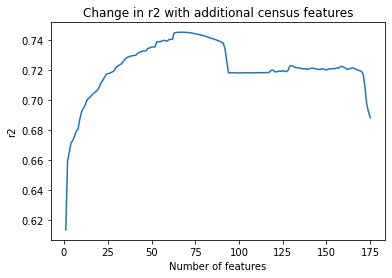

In [283]:
plt.plot(lin_feat_subsets, r2s)
plt.xlabel('Number of features')
plt.ylabel('r2')
plt.title('Change in r2 with additional census features')
plt.show()

## Generate train-test set

In [351]:
np.insert(temp, 0, 0, axis=0).shape

(73,)

In [352]:
# Select only the top features
temp = np.append(optimal_feat_index+1, month_data_with_census.shape[1]-1)
month_data_with_census = month_data_with_census[:, np.insert(temp, 0, 0, axis=0)] # Insert month and target columns
month_data_with_census.shape

(546, 73)

In [353]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_no_census, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_with_census, 5)

0 455 546
0 455 546


In [354]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_no_census, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_with_census, 4)

0 364 455
91 455 546
0 364 455
91 455 546


In [355]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_no_census, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_with_census, 3)

0 273 364
91 364 455
182 455 546
0 273 364
91 364 455
182 455 546


In [356]:
nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, nc2m_ptX_arr, nc2m_pty_arr = n_month_window_split(month_data_no_census, 2)
wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, wc2m_ptX_arr, wc2m_pty_arr = n_month_window_split(month_data_with_census, 2)

0 182 273
91 273 364
182 364 455
273 455 546
0 182 273
91 273 364
182 364 455
273 455 546


In [357]:
nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, nc1m_ptX_arr, nc1m_pty_arr = n_month_window_split(month_data_no_census, 1)
wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, wc1m_ptX_arr, wc1m_pty_arr = n_month_window_split(month_data_with_census, 1)

0 91 182
91 182 273
182 273 364
273 364 455
364 455 546
0 91 182
91 182 273


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountere

182 273 364
273 364 455
364 455 546


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


# Model Training

In [369]:
def train_model(X_train_arr, X_test_arr, y_train_arr, y_test_arr, model, graph_title, n):
    y_pred_arr = []
    mse_arr = []
    r2_arr = []
    mae_arr = []
    avg_arr = []

    for i in range(len(X_train_arr)):
        model.fit(X_train_arr[i], y_train_arr[i])
        y_pred_arr.append(model.predict(X_test_arr[i]))
        mse_arr.append(mean_squared_error(y_pred_arr[i], y_test_arr[i]))
        r2_arr.append(r2_score(y_pred_arr[i], y_test_arr[i]))
        mae_arr.append(mean_absolute_error(y_pred_arr[i], y_test_arr[i]))
        avg_arr.append(np.average(y_test_arr[i]))
    print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=mse_arr, b=r2_arr, c=mae_arr, d=avg_arr))

    if len(avg_arr)==1:
        # Graph
        fig, ax = plt.subplots(figsize=[8,6])
        ax.scatter(y_test_arr[0], y_pred_arr[0])
        ax.plot([y_test_arr[0].min(), y_test_arr[0].max()], [y_test_arr[0].min(), y_test_arr[0].max()], 'k--', lw=4)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        ax.set_title('{graph_title}\nPrediction for month {m}'.format(graph_title=graph_title, m=calendar.month_name[i+5+n]))
        plt.show()
        return
    fig, axs = plt.subplots(len(avg_arr), figsize=[8,12], constrained_layout=True)
    for i in range(len(avg_arr)):
        axs[i].scatter(y_test_arr[i], y_pred_arr[i])
        axs[i].plot([y_test_arr[i].min(), y_test_arr[i].max()], [y_test_arr[i].min(), y_test_arr[i].max()], 'k--', lw=4)
        axs[i].set_xlabel('Measured')
        axs[i].set_ylabel('Predicted')
        axs[i].set_title('Prediction for {m}'.format(m=calendar.month_name[i+5+n]))
    fig.suptitle(graph_title, fontsize=16)
    plt.show()

In [359]:
def search_model(X_train, X_test, y_train, y_test, model, graph_title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    r2 = r2_score(y_pred, y_test)
    mae = mean_absolute_error(y_pred, y_test)
    error = {
        'mse': mse,
        'r2': r2,
        'mae': mae
    }
    print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=mse, b=r2, c=mae, d=np.average(y_test)))
    
    # Graph
    fig, ax = plt.subplots(figsize=[8,6])
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_title(graph_title)
    plt.show()
    print(model.best_estimator_)

# Linear Reg

In [370]:
lin_model = LinearRegression()

## 5 month window

MSE: [0.15315804605035307] 
r2: [0.7553357353957801] 
MAE: [0.24062210752808416] 
avg: [-0.08040828841961946]


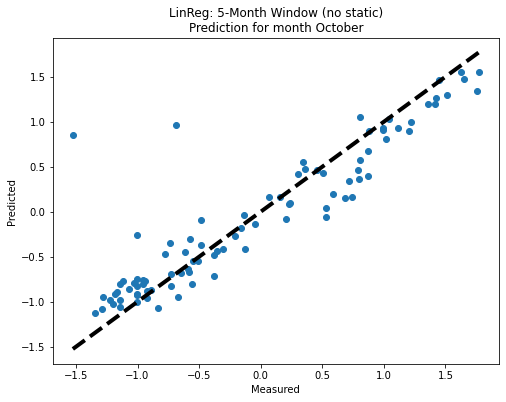

In [371]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "LinReg: 5-Month Window (no static)", 5)

MSE: [0.17233415905076466] 
r2: [0.7881181899427576] 
MAE: [0.2880946926707445] 
avg: [-0.08040828841961946]


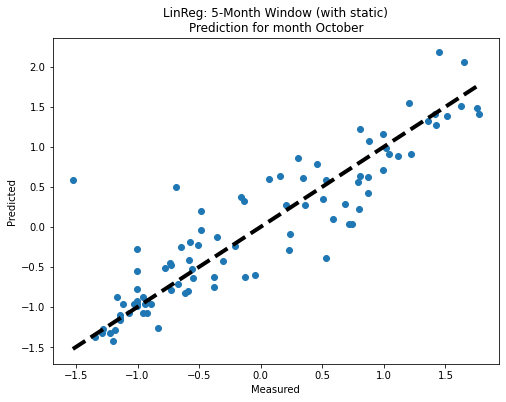

In [372]:
train_model(wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, lin_model, "LinReg: 5-Month Window (with static)", 5)

## 4 month window

MSE: [0.34832004125268456, 0.19665944265767996] 
r2: [0.5794640757018158, 0.6506013531251607] 
MAE: [0.5003725757253604, 0.2978949658822434] 
avg: [-0.37194413949722904, -0.14805463261534021]


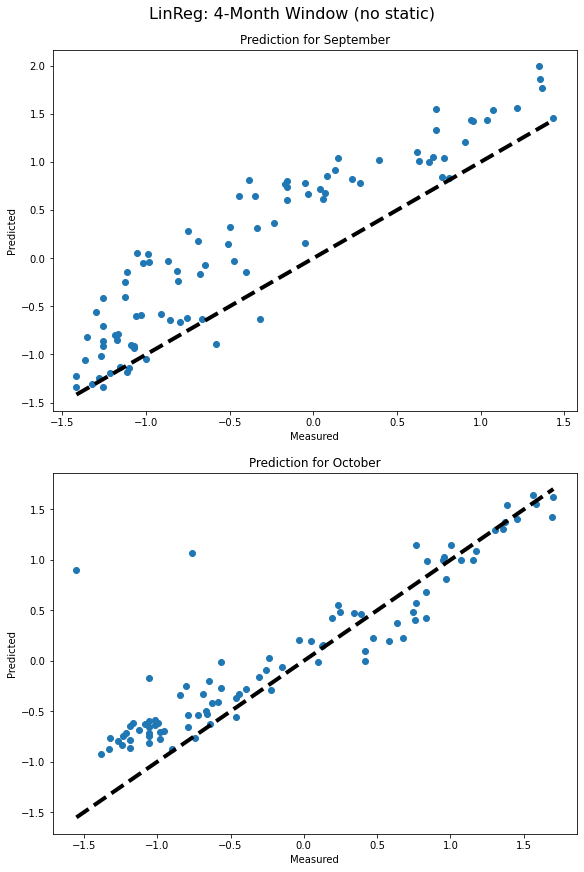

In [373]:
train_model(nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, lin_model, "LinReg: 4-Month Window (no static)", 4)

MSE: [0.33521664422557357, 0.20055102897668955] 
r2: [0.6122543360879856, 0.761102636702483] 
MAE: [0.4844877487265394, 0.3101374351899113] 
avg: [-0.37194413949722904, -0.14805463261534021]


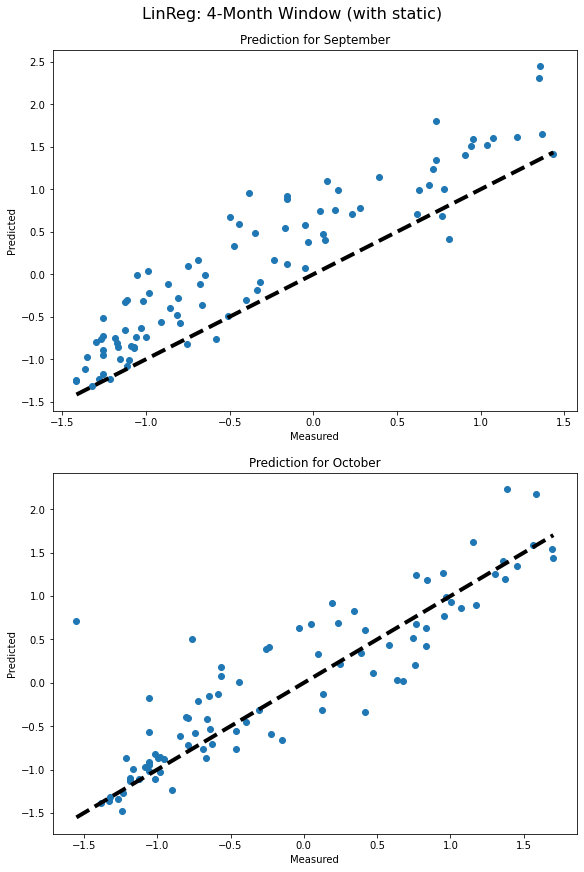

In [374]:
train_model(wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, lin_model, "LinReg: 4-Month Window (with static)", 4)

## 3 month window

MSE: [1.379310941328999, 0.33480494078443473, 0.7066024089105336] 
r2: [-0.383431994281872, 0.5706813772164578, -0.35849154579453746] 
MAE: [1.1044803031936095, 0.4925437558280796, 0.7422005338432299] 
avg: [0.05720047139443175, -0.47997242681385144, -0.1849817336475336]


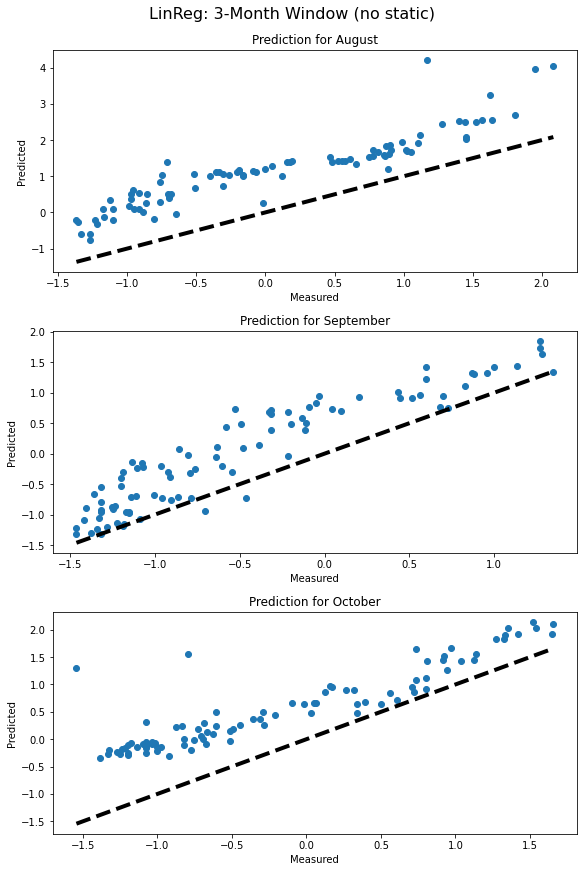

In [375]:
train_model(nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, lin_model, "LinReg: 3-Month Window (no static)", 3)

MSE: [0.8290906006444033, 0.40310958965712484, 0.3073447050310558] 
r2: [0.06109114273399674, 0.5410187158365325, 0.6462974998593716] 
MAE: [0.8754775616147576, 0.5340418948510566, 0.3944130339037817] 
avg: [0.05720047139443175, -0.47997242681385144, -0.1849817336475336]


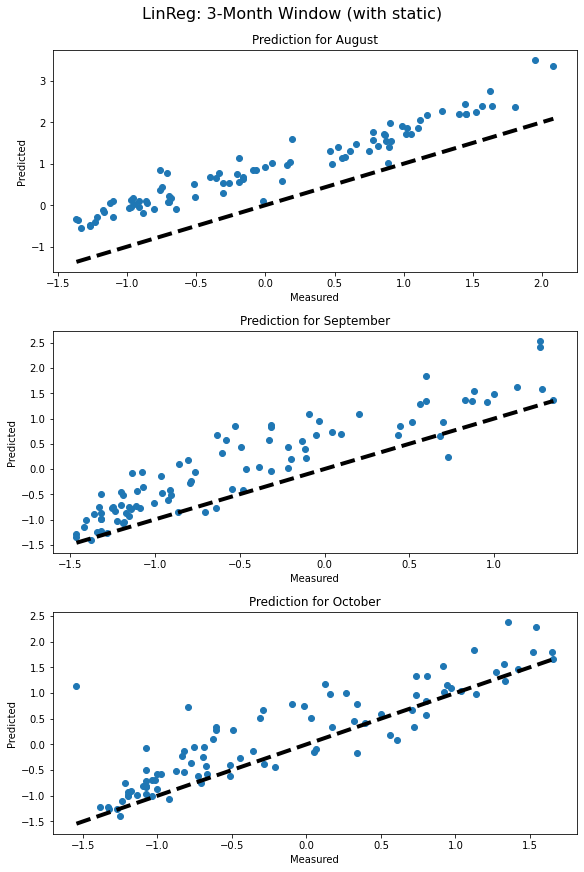

In [376]:
train_model(wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, lin_model, "LinReg: 3-Month Window (with static)", 3)

## 2 month window

MSE: [0.3767839607176381, 2.4896711912112917, 0.7864213911049868, 0.6953086003404159] 
r2: [0.641410632408773, -1.6008223300425537, -0.01706855446274358, -0.26899650508987905] 
MAE: [0.3746811217405278, 1.5301959790343942, 0.828017537778968, 0.7582127783811471] 
avg: [0.7155761055356249, -0.10065569585709884, -0.5844421251774592, 0.013171521909767742]


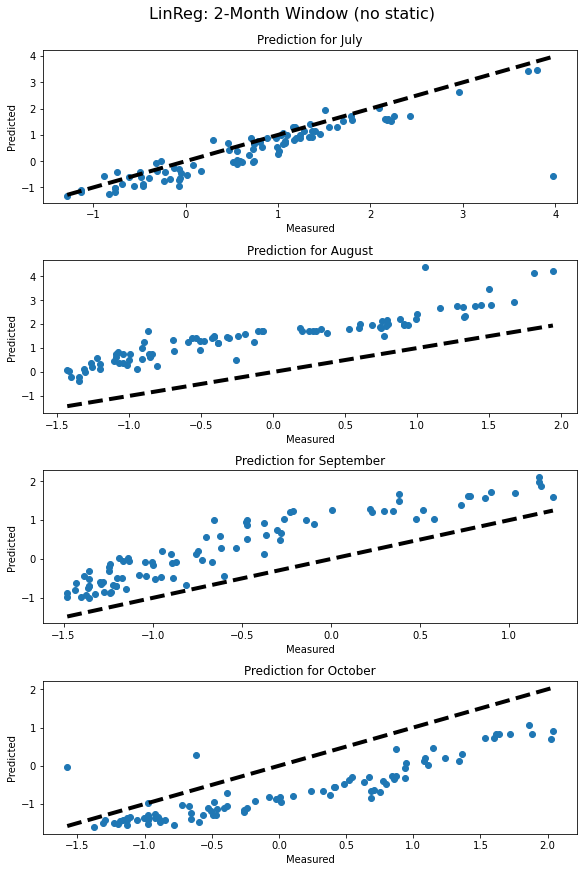

In [377]:
train_model(nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, lin_model, "LinReg: 2-Month Window (no static)", 2)

MSE: [0.3202072437367226, 1.8842911897743055, 0.6478126023328237, 0.5719339435130831] 
r2: [0.690463068068746, -1.1951544291148823, 0.28847855480100437, 0.2805113130052478] 
MAE: [0.3654467063047791, 1.3490856906377489, 0.7057269189958442, 0.6993340204800268] 
avg: [0.7155761055356249, -0.10065569585709884, -0.5844421251774592, 0.013171521909767742]


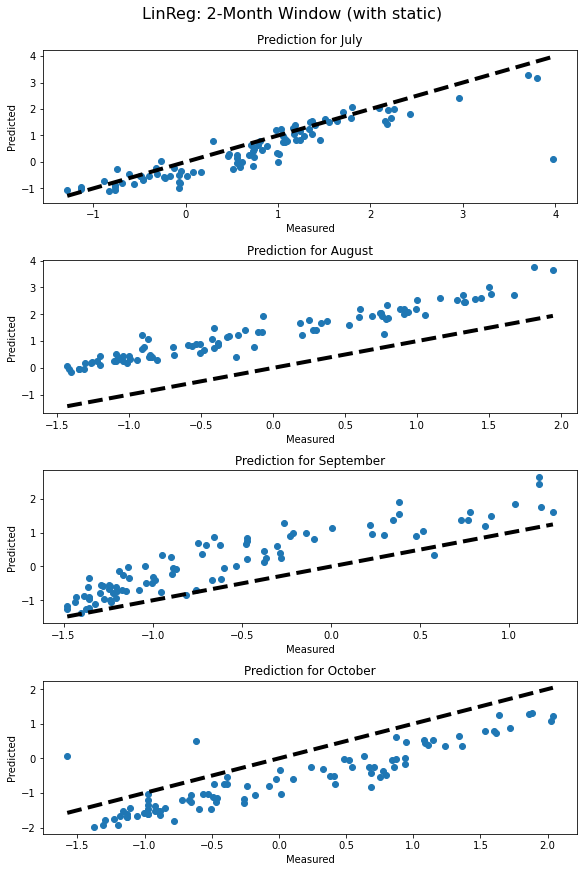

In [378]:
train_model(wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, lin_model, "LinReg: 2-Month Window (with static)", 2)

# SVR

# Feature Selection

## The following takes a long time to run!!! Just use the cell below this section

In [409]:
month_data_with_census = build_month_data_with_census(census_data)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_no_census, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_with_census, 5)

In [410]:
svr_params = {
    'C': 1,
    'gamma': 0.0001,
    'kernel': 'linear',
}
svr_model = SVR(**svr_params)
svr_feat_subsets = f_selection(svr_model,wc5m_X_train_arr[0].shape[1],wc5m_X_train_arr[0],wc5m_y_train_arr[0])

In [411]:
print(svr_feat_subsets)
np.save('../data/svr_feat_subsets.npy',svr_feat_subsets, allow_pickle=True)

{1: {'feature_idx': (0,), 'cv_scores': array([0.73347998, 0.8161115 , 0.34517045, 0.61968864, 0.46885929]), 'avg_score': 0.5966619720458215, 'feature_names': ('0',)}, 2: {'feature_idx': (0, 1), 'cv_scores': array([0.76492683, 0.89453549, 0.35222746, 0.8125219 , 0.52418433]), 'avg_score': 0.6696792015185971, 'feature_names': ('0', '1')}, 3: {'feature_idx': (0, 1, 172), 'cv_scores': array([0.78089029, 0.88822498, 0.35164029, 0.84783849, 0.52083289]), 'avg_score': 0.6778853874877052, 'feature_names': ('0', '1', '172')}, 4: {'feature_idx': (0, 1, 129, 172), 'cv_scores': array([0.79210343, 0.89201727, 0.35353407, 0.86131451, 0.51980067]), 'avg_score': 0.6837539885960784, 'feature_names': ('0', '1', '129', '172')}, 5: {'feature_idx': (0, 1, 129, 136, 172), 'cv_scores': array([0.79385839, 0.88837114, 0.36482614, 0.85014582, 0.53451148]), 'avg_score': 0.6863425929305487, 'feature_names': ('0', '1', '129', '136', '172')}, 6: {'feature_idx': (0, 1, 105, 129, 136, 172), 'cv_scores': array([0.7904

## Run this section instead!!

In [418]:
month_data_with_census = build_month_data_with_census(census_data)
svr_feat_subsets = np.load('../data/svr_feat_subsets.npy', allow_pickle=True)[()]
svr_feat_subsets

{1: {'feature_idx': (0,),
  'cv_scores': array([0.73347998, 0.8161115 , 0.34517045, 0.61968864, 0.46885929]),
  'avg_score': 0.5966619720458215,
  'feature_names': ('0',)},
 2: {'feature_idx': (0, 1),
  'cv_scores': array([0.76492683, 0.89453549, 0.35222746, 0.8125219 , 0.52418433]),
  'avg_score': 0.6696792015185971,
  'feature_names': ('0', '1')},
 3: {'feature_idx': (0, 1, 172),
  'cv_scores': array([0.78089029, 0.88822498, 0.35164029, 0.84783849, 0.52083289]),
  'avg_score': 0.6778853874877052,
  'feature_names': ('0', '1', '172')},
 4: {'feature_idx': (0, 1, 129, 172),
  'cv_scores': array([0.79210343, 0.89201727, 0.35353407, 0.86131451, 0.51980067]),
  'avg_score': 0.6837539885960784,
  'feature_names': ('0', '1', '129', '172')},
 5: {'feature_idx': (0, 1, 129, 136, 172),
  'cv_scores': array([0.79385839, 0.88837114, 0.36482614, 0.85014582, 0.53451148]),
  'avg_score': 0.6863425929305487,
  'feature_names': ('0', '1', '129', '136', '172')},
 6: {'feature_idx': (0, 1, 105, 129, 13

In [419]:
def get_optimal_index(feat_subsets):
    feature_counts = []
    r2s = []
    optimal_feat = None
    optimal_r2 = None
    for key, value in feat_subsets.items():
        if key == 1:
            optimal_r2 = value['avg_score']
            optimal_feat = value
        elif (value['avg_score'] > optimal_r2):
            optimal_feat = value
            optimal_r2 = value['avg_score']
        feature_counts.append(key)
        r2s.append(value['avg_score'])
    optimal_index = np.array(list(set(optimal_feat['feature_idx']) | {0, 1, 2, 3, 4})) ## Add dynamic features to the list of optimal features
    print(np.array(feature_names)[optimal_feat_index])
    
    plt.plot(feature_counts, r2s)
    plt.xlabel('Number of features')
    plt.ylabel('r2')
    plt.title('Change in r2 with additional census features')
    plt.show()
    return optimal_index

['cases' 'County total cases' 'Incoming migration' 'Outgoing migration'
 'Nursing home density' 'Healthcare workers' 'Food Services workers'
 '% Area Total: Area (Water)' '% Total Population: 10 to 14 Years'
 '% Total Population: 15 to 17 Years' '% Total Population: 25 to 34 Years'
 '% Total Population: 35 to 44 Years' '% Total Population: 55 to 64 Years'
 '% Total Population: 85 Years and Over' '% Households: Family Households'
 '% Households: Family Households: Married-Couple Family'
 '% Households: Family Households: Other Family'
 '% Households: Family Households: Other Family: Male Householder, No Wife Present'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present'
 '% Households: Nonfamily Households'
 '% Households: Nonfamily Households: Male Householder'
 '% Population 16 Years and Over: in Labor Force'
 '% Population 16 Years and Over: in Labor Force: Civilian'
 '% In Labor Force 16 Years and Over: in Armed Forces'
 '% Employed Civilian Popula

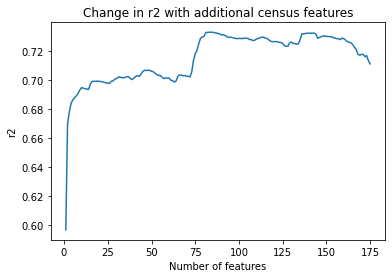

array([  0,   1,   2,   3,   4,   6,   7,   8,   9,  12,  13,  18,  22,
        26,  27,  28,  29,  30,  32,  33,  34,  35,  39,  41,  42,  46,
        48,  49,  50,  52,  54,  68,  69,  74,  75,  76,  78,  79,  80,
        81,  82,  83,  86,  87,  88,  89,  90,  92,  93,  98, 102, 103,
       104, 105, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 124,
       128, 129, 130, 135, 136, 137, 138, 139, 140, 141, 143, 144, 149,
       150, 157, 158, 159, 160, 167, 168, 170, 172, 173])

In [420]:
svr_optimal_index = get_optimal_index(svr_feat_subsets)
svr_optimal_index

## Generate train-test set

In [421]:
# Select only the top features
temp = np.append(svr_optimal_index+1, month_data_with_census.shape[1]-1)
month_data_with_census = month_data_with_census[:, np.insert(temp, 0, 0, axis=0)] # Insert month and target columns
month_data_with_census.shape

(546, 90)

In [422]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_no_census, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_with_census, 5)

In [423]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_no_census, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_with_census, 4)

In [424]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_no_census, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_with_census, 3)

In [425]:
nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, nc2m_ptX_arr, nc2m_pty_arr = n_month_window_split(month_data_no_census, 2)
wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, wc2m_ptX_arr, wc2m_pty_arr = n_month_window_split(month_data_with_census, 2)

In [426]:
nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, nc1m_ptX_arr, nc1m_pty_arr = n_month_window_split(month_data_no_census, 1)
wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, wc1m_ptX_arr, wc1m_pty_arr = n_month_window_split(month_data_with_census, 1)

/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountere

In [379]:
# svr_param_grid = {
#     'C':[0.1,1,10, 100, 1000],
#     "gamma": [1e-6, 1e-4, 1e-2, 1e-1, 1],
#     'kernel': ['rbf', 'linear'],
# }

svr_param_grid = {
    'C':[0.1,1,10, 20, 30, 50, 100],
    "gamma": [1e-4, 1e-3, 1e-2, 1e-1, 1],
    'kernel': ['linear'],
}

svr_search = GridSearchCV(svr_model, svr_param_grid)

MSE: 0.19546767583812658 
r2: 0.7654778616977455 
MAE: 0.308481572597639 
avg: -0.08040828841961946


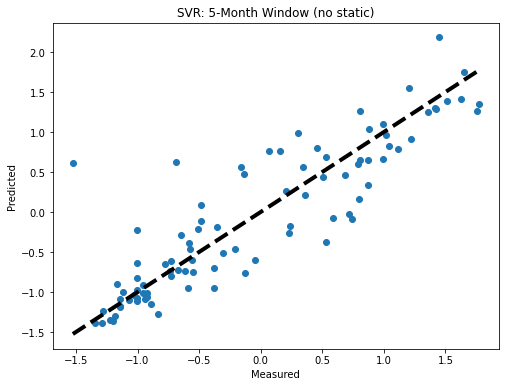

SVR(C=1, gamma=0.0001, kernel='linear')


In [176]:
## Grid search
search_model(wc5m_X_train_arr[0], wc5m_X_test_arr[0], wc5m_y_train_arr[0], wc5m_y_test_arr[0], svr_search, "SVR: 5-Month Window (no static)")

In [427]:
# svr_params = {
#     'C': 10,
# }

# svr_params = {
#     'C': 100,
#     'gamma': 0.001,
#     'kernel': 'linear',
# }

# svr_params = {
#     'C': 10,
#     'gamma': 0.01,
#     'kernel': 'linear',
# }

# svr_params = {
#     'C': 20,
#     'gamma': 0.01,
#     'kernel': 'linear',
# }

svr_params = {
    'C': 1,
    'gamma': 0.0001,
    'kernel': 'linear',
}

In [428]:
svr_model = SVR(**svr_params)

## 5 month window

MSE: [0.1529040512218465] 
r2: [0.770204920616304] 
MAE: [0.23927368012942707] 
avg: [-0.08040828841961946]


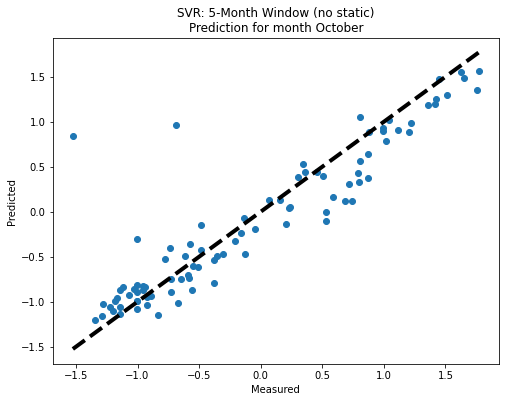

In [429]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR: 5-Month Window (no static)", 5)

MSE: [0.18014415377056203] 
r2: [0.7655750541506645] 
MAE: [0.28982518544692815] 
avg: [-0.08040828841961946]


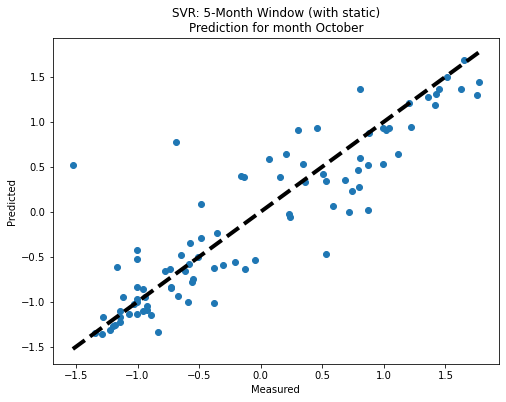

In [430]:
train_model(wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, svr_model, "SVR: 5-Month Window (with static)", 5)

## 4 month window

MSE: [0.327711338986908, 0.17095756458486072] 
r2: [0.633360983256531, 0.709766953286919] 
MAE: [0.48212312153193654, 0.2645421839950866] 
avg: [-0.37194413949722904, -0.14805463261534021]


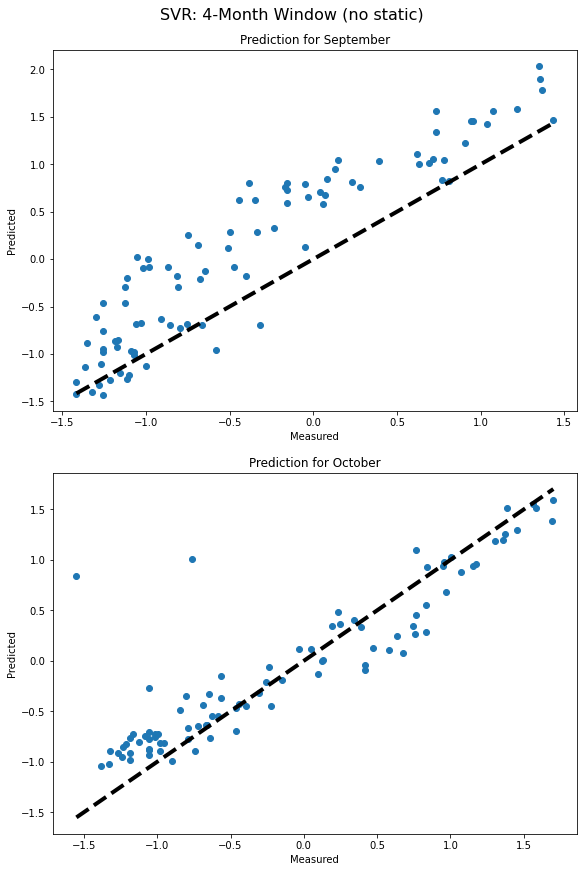

In [384]:
train_model(nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, svr_model, "SVR: 4-Month Window (no static)", 4)

MSE: [0.32214039998752475, 0.18293737795553297] 
r2: [0.6267695333902374, 0.7402677991074861] 
MAE: [0.46951424752699333, 0.2948486412778763] 
avg: [-0.37194413949722904, -0.14805463261534021]


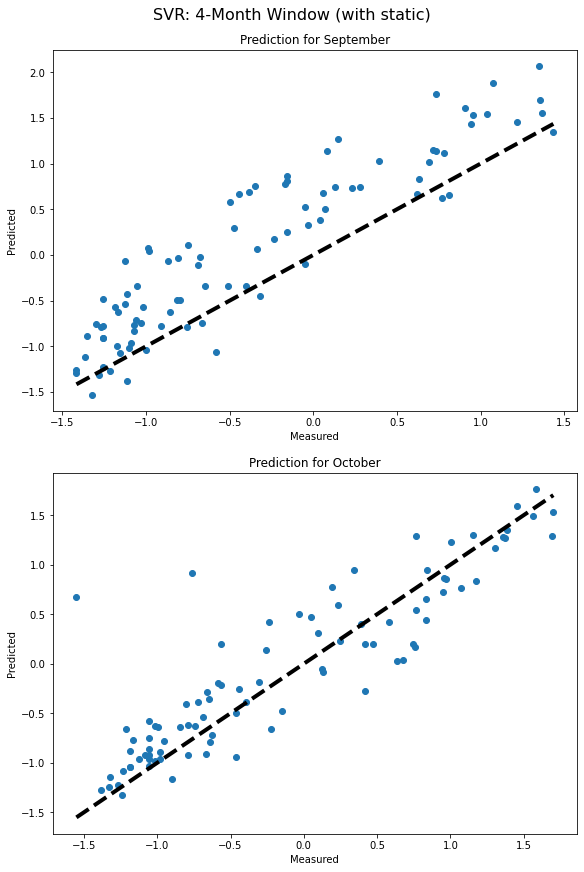

In [385]:
train_model(wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, svr_model, "SVR: 4-Month Window (with static)", 4)

## 3 month window

MSE: [1.403426262041886, 0.3084563505056977, 0.5897859389401591] 
r2: [-0.405207508555089, 0.6405972101627901, -0.029825744532373966] 
MAE: [1.1186359299027557, 0.46433676071799224, 0.6625502126305884] 
avg: [0.05720047139443175, -0.47997242681385144, -0.1849817336475336]


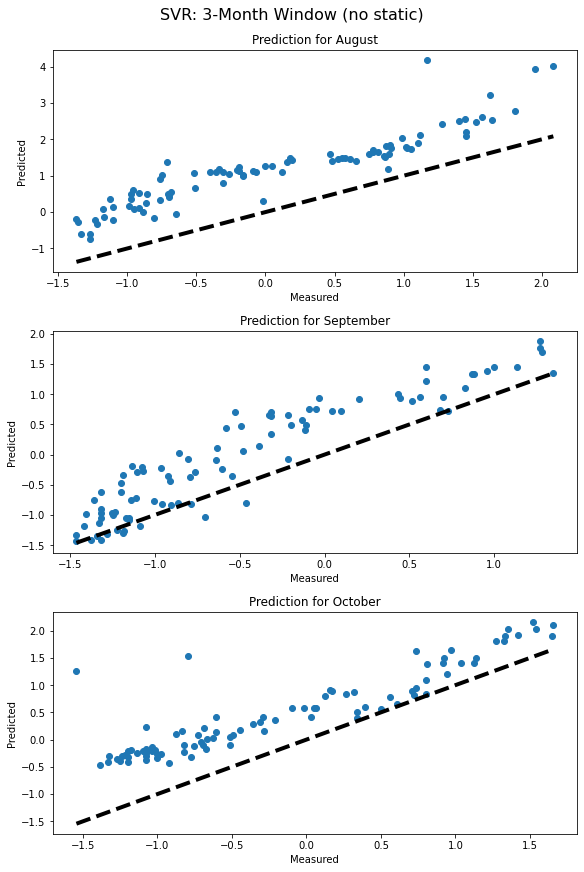

In [386]:
train_model(nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, svr_model, "SVR: 3-Month Window (no static)", 3)

MSE: [0.9604395409989228, 0.34068376758393304, 0.48929452421834074] 
r2: [-0.004098500939593297, 0.6037189274911057, 0.32808693558691515] 
MAE: [0.9232248756333864, 0.4886150747085117, 0.5934121077946873] 
avg: [0.05720047139443175, -0.47997242681385144, -0.1849817336475336]


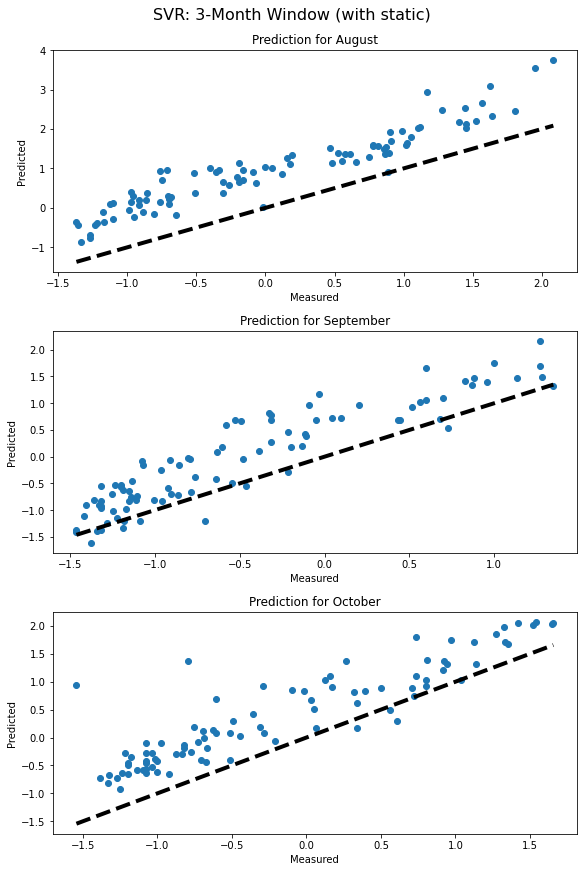

In [387]:
train_model(wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, svr_model, "SVR: 3-Month Window (with static)", 3)

## 2 month window

MSE: [0.3898794581746391, 2.2611377020171006, 0.7367285951966397, 0.7165581953820719] 
r2: [0.6128636303701094, -1.2889575210596793, 0.12943384205684805, -0.27670867780212527] 
MAE: [0.38776839098039767, 1.4545245382168597, 0.7889450976415474, 0.772975882826908] 
avg: [0.7155761055356249, -0.10065569585709884, -0.5844421251774592, 0.013171521909767742]


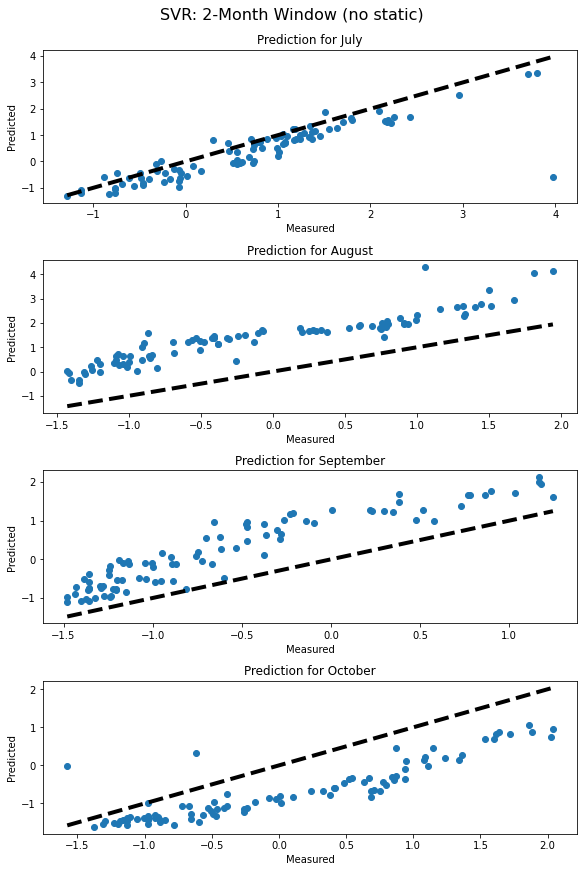

In [388]:
train_model(nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, svr_model, "SVR: 2-Month Window (no static)", 2)

MSE: [0.32160453926022053, 2.039541090741858, 0.656822189466187, 0.7028975024646232] 
r2: [0.7014589067919946, -1.0707970458699183, 0.2509587757466408, -0.020302463238579094] 
MAE: [0.3663745608680089, 1.3819020192872669, 0.7274611887341761, 0.7737752880026285] 
avg: [0.7155761055356249, -0.10065569585709884, -0.5844421251774592, 0.013171521909767742]


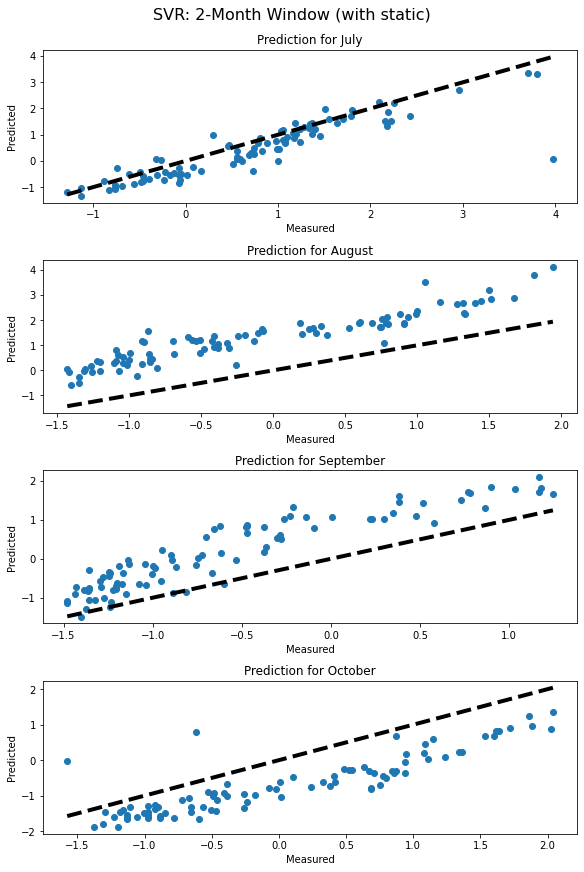

In [389]:
train_model(wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, svr_model, "SVR: 2-Month Window (with static)", 2)

## 1 month window

MSE: [0.13293588015096555, 0.4016725416735243, 0.8883194595895316, 0.08406882182250892, 0.7154370721117294] 
r2: [0.8928522917472101, 0.5911217802106796, 0.10357157849723408, 0.9006677078766294, -0.1284289989119618] 
MAE: [0.28837689987100856, 0.4167434114085517, 0.8625591918046257, 0.2281837670315354, 0.7507907871897569] 
avg: [0.2517505863138194, 0.5818911829303556, -0.35094313926184517, -0.4297594728956761, 0.2694229752988186]


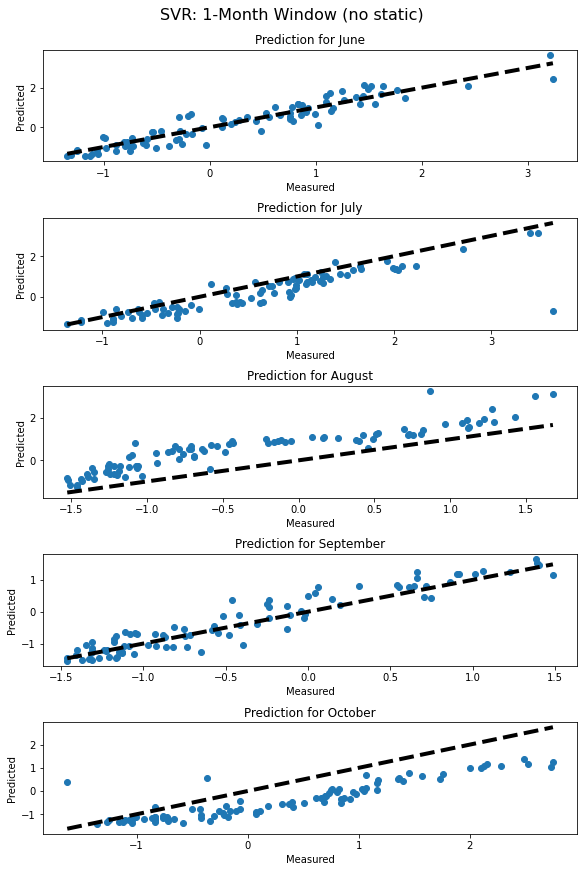

In [390]:
train_model(nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, svr_model, "SVR: 1-Month Window (no static)", 1)

MSE: [0.20886836978326911, 0.4400223826469767, 0.6185405024098751, 0.14576705637732165, 0.7440118259530011] 
r2: [0.8641348830257155, 0.6031859570579088, 0.3991027554338302, 0.8451887404061453, 0.09499048083214356] 
MAE: [0.37183073744544604, 0.43636222362179483, 0.69910672409273, 0.3157637958440136, 0.7396787801586305] 
avg: [0.2517505863138194, 0.5818911829303556, -0.35094313926184517, -0.4297594728956761, 0.2694229752988186]


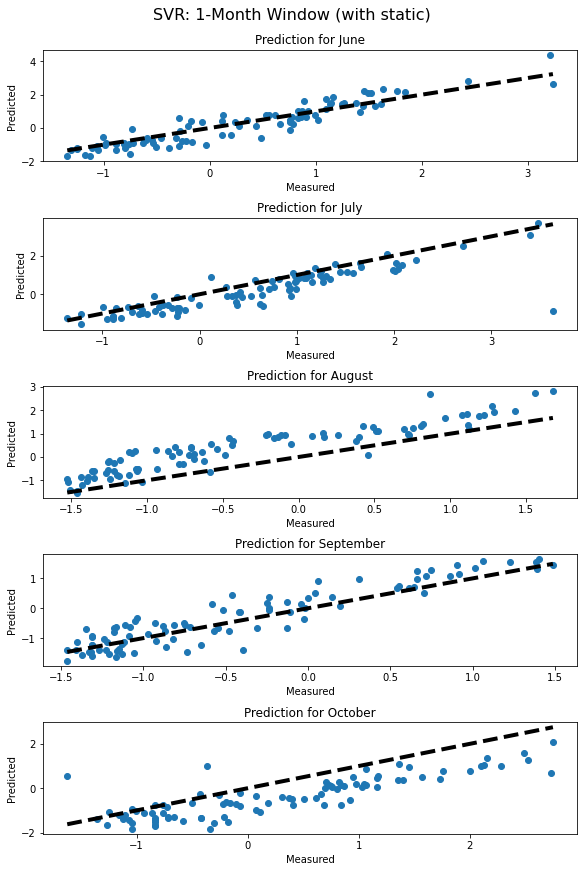

In [391]:
train_model(wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, svr_model, "SVR: 1-Month Window (with static)", 1)

# Gradient Boosting

# Feature Selection

## The following takes a long time to run!!! Just use the cell below this section

In [440]:
month_data_with_census = build_month_data_with_census(census_data)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_no_census, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_with_census, 5)

In [441]:
gb_param = {
    'n_estimators': 700,
    'max_depth': 16,
    'min_samples_split': 100,
    'learning_rate': 0.01,
    'loss': 'ls'
}
gb_model = GradientBoostingRegressor(**gb_param)
gb_feat_subsets = f_selection(gb_model,wc5m_X_train_arr[0].shape[1],wc5m_X_train_arr[0],wc5m_y_train_arr[0])


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [442]:
print(gb_feat_subsets)
np.save('../data/gb_feat_subsets.npy',gb_feat_subsets, allow_pickle=True)

{1: {'feature_idx': (5,), 'cv_scores': array([0.71334786, 0.85631655, 0.4407976 , 0.89241409, 0.65262675]), 'avg_score': 0.7111005703977666, 'feature_names': ('5',)}, 2: {'feature_idx': (5, 173), 'cv_scores': array([0.71631205, 0.87347404, 0.46369581, 0.91649605, 0.62930466]), 'avg_score': 0.7198565217811982, 'feature_names': ('5', '173')}, 3: {'feature_idx': (5, 102, 173), 'cv_scores': array([0.72230848, 0.87870934, 0.46211911, 0.91833898, 0.62882895]), 'avg_score': 0.7220609719982137, 'feature_names': ('5', '102', '173')}, 4: {'feature_idx': (5, 49, 102, 173), 'cv_scores': array([0.7160169 , 0.88020998, 0.46427012, 0.91892262, 0.634972  ]), 'avg_score': 0.7228783254526783, 'feature_names': ('5', '49', '102', '173')}, 5: {'feature_idx': (5, 49, 102, 103, 173), 'cv_scores': array([0.7160169 , 0.88020998, 0.46427012, 0.91892262, 0.634972  ]), 'avg_score': 0.7228783254526783, 'feature_names': ('5', '49', '102', '103', '173')}, 6: {'feature_idx': (5, 48, 49, 102, 103, 173), 'cv_scores': a

## Run this section instead!!

In [418]:
month_data_with_census = build_month_data_with_census(census_data)
svr_feat_subsets = np.load('../data/svr_feat_subsets.npy', allow_pickle=True)[()]
svr_feat_subsets

{1: {'feature_idx': (0,),
  'cv_scores': array([0.73347998, 0.8161115 , 0.34517045, 0.61968864, 0.46885929]),
  'avg_score': 0.5966619720458215,
  'feature_names': ('0',)},
 2: {'feature_idx': (0, 1),
  'cv_scores': array([0.76492683, 0.89453549, 0.35222746, 0.8125219 , 0.52418433]),
  'avg_score': 0.6696792015185971,
  'feature_names': ('0', '1')},
 3: {'feature_idx': (0, 1, 172),
  'cv_scores': array([0.78089029, 0.88822498, 0.35164029, 0.84783849, 0.52083289]),
  'avg_score': 0.6778853874877052,
  'feature_names': ('0', '1', '172')},
 4: {'feature_idx': (0, 1, 129, 172),
  'cv_scores': array([0.79210343, 0.89201727, 0.35353407, 0.86131451, 0.51980067]),
  'avg_score': 0.6837539885960784,
  'feature_names': ('0', '1', '129', '172')},
 5: {'feature_idx': (0, 1, 129, 136, 172),
  'cv_scores': array([0.79385839, 0.88837114, 0.36482614, 0.85014582, 0.53451148]),
  'avg_score': 0.6863425929305487,
  'feature_names': ('0', '1', '129', '136', '172')},
 6: {'feature_idx': (0, 1, 105, 129, 13

In [419]:
def get_optimal_index(feat_subsets):
    feature_counts = []
    r2s = []
    optimal_feat = None
    optimal_r2 = None
    for key, value in feat_subsets.items():
        if key == 1:
            optimal_r2 = value['avg_score']
            optimal_feat = value
        elif (value['avg_score'] > optimal_r2):
            optimal_feat = value
            optimal_r2 = value['avg_score']
        feature_counts.append(key)
        r2s.append(value['avg_score'])
    optimal_index = np.array(list(set(optimal_feat['feature_idx']) | {0, 1, 2, 3, 4})) ## Add dynamic features to the list of optimal features
    print(np.array(feature_names)[optimal_feat_index])
    
    plt.plot(feature_counts, r2s)
    plt.xlabel('Number of features')
    plt.ylabel('r2')
    plt.title('Change in r2 with additional census features')
    plt.show()
    return optimal_index

['cases' 'County total cases' 'Incoming migration' 'Outgoing migration'
 'Nursing home density' 'Healthcare workers' 'Food Services workers'
 '% Area Total: Area (Water)' '% Total Population: 10 to 14 Years'
 '% Total Population: 15 to 17 Years' '% Total Population: 25 to 34 Years'
 '% Total Population: 35 to 44 Years' '% Total Population: 55 to 64 Years'
 '% Total Population: 85 Years and Over' '% Households: Family Households'
 '% Households: Family Households: Married-Couple Family'
 '% Households: Family Households: Other Family'
 '% Households: Family Households: Other Family: Male Householder, No Wife Present'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present'
 '% Households: Nonfamily Households'
 '% Households: Nonfamily Households: Male Householder'
 '% Population 16 Years and Over: in Labor Force'
 '% Population 16 Years and Over: in Labor Force: Civilian'
 '% In Labor Force 16 Years and Over: in Armed Forces'
 '% Employed Civilian Popula

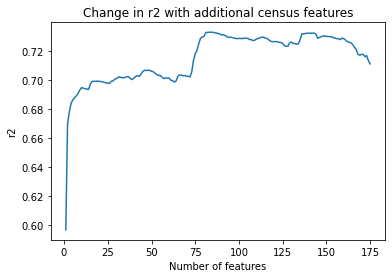

array([  0,   1,   2,   3,   4,   6,   7,   8,   9,  12,  13,  18,  22,
        26,  27,  28,  29,  30,  32,  33,  34,  35,  39,  41,  42,  46,
        48,  49,  50,  52,  54,  68,  69,  74,  75,  76,  78,  79,  80,
        81,  82,  83,  86,  87,  88,  89,  90,  92,  93,  98, 102, 103,
       104, 105, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 124,
       128, 129, 130, 135, 136, 137, 138, 139, 140, 141, 143, 144, 149,
       150, 157, 158, 159, 160, 167, 168, 170, 172, 173])

In [420]:
svr_optimal_index = get_optimal_index(svr_feat_subsets)
svr_optimal_index

## Generate train-test set

In [421]:
# Select only the top features
temp = np.append(svr_optimal_index+1, month_data_with_census.shape[1]-1)
month_data_with_census = month_data_with_census[:, np.insert(temp, 0, 0, axis=0)] # Insert month and target columns
month_data_with_census.shape

(546, 90)

In [422]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_no_census, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_with_census, 5)

In [423]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_no_census, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_with_census, 4)

In [424]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_no_census, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_with_census, 3)

In [425]:
nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, nc2m_ptX_arr, nc2m_pty_arr = n_month_window_split(month_data_no_census, 2)
wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, wc2m_ptX_arr, wc2m_pty_arr = n_month_window_split(month_data_with_census, 2)

In [426]:
nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, nc1m_ptX_arr, nc1m_pty_arr = n_month_window_split(month_data_no_census, 1)
wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, wc1m_ptX_arr, wc1m_pty_arr = n_month_window_split(month_data_with_census, 1)

/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountere

In [392]:
gb_param_grid = {
   'n_estimators': [700, 900, 1100],
    'max_depth': [16, 32, 48],
    'min_samples_split': [50, 100, 200],
}

gb_model = GradientBoostingRegressor()
gb_search = GridSearchCV(gb_model, gb_param_grid)

## One split

### No census

In [ ]:
gb_param = {
    'n_estimators': 700,
    'max_depth': 16,
    'min_samples_split': 100,
    'learning_rate': 0.01,
    'loss': 'ls'
}
gb_model = GradientBoostingRegressor(**gb_param)

MSE: [0.18065031501034082] 
r2: [0.7759799196311643] 
MAE: [0.25437419978680714] 
avg: [-0.08040828841961946]


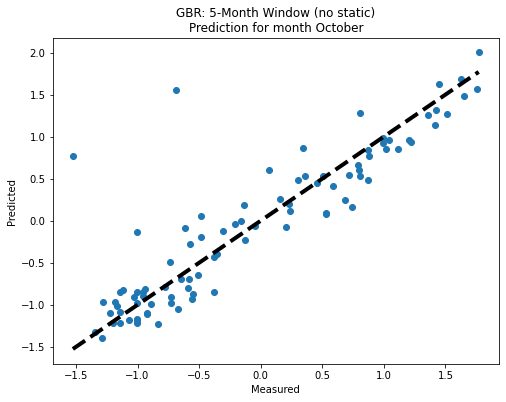

In [396]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "GBR: 5-Month Window (no static)", 5)

MSE: [0.1332532769398973] 
r2: [0.8348117268213702] 
MAE: [0.24416971271068239] 
avg: [-0.08040828841961946]


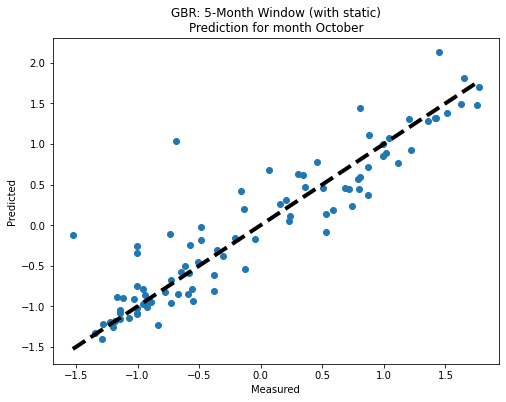

In [397]:
train_model(wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, gb_model, "GBR: 5-Month Window (with static)", 5)

MSE: [0.935531438069353, 0.1751462752016095] 
r2: [-0.12475462622686484, 0.7528933293130073] 
MAE: [0.8924636699296704, 0.2521088811142437] 
avg: [-0.37194413949722904, -0.14805463261534021]


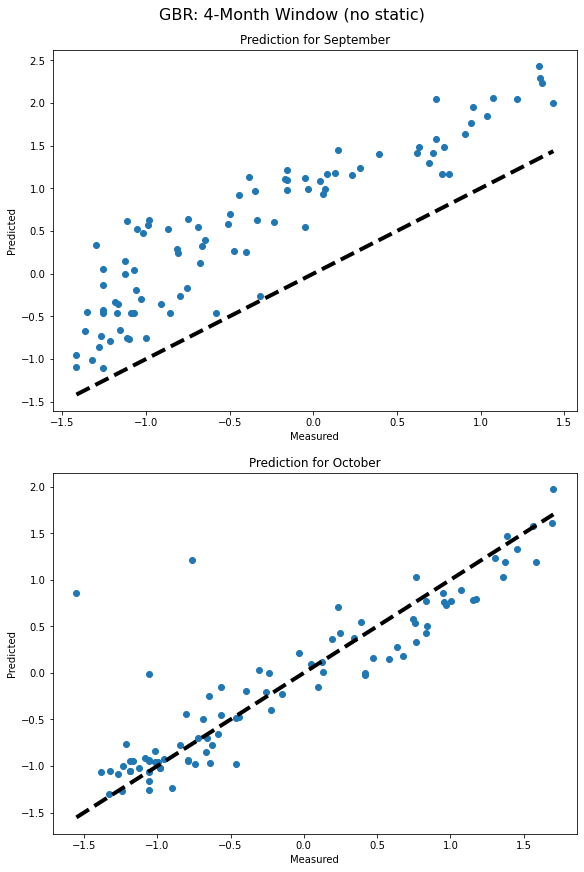

In [394]:
train_model(nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, gb_model, "GBR: 4-Month Window (no static)", 4)

### With census

In [ ]:
gb_model = GradientBoostingRegressor(**gb_param)
one_split_model(month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test, gb_model, "GB: One Split & With Census")

In [ ]:
# gb_search.best_estimator_

In [ ]:
feat_im = np.array(gb_model.feature_importances_)
feat_im_indices = feat_im.argsort()[-10:][::-1]
important_features = feature_names[feat_im_indices]
for i in feat_im_indices:
    print(feature_names[i])
    print(feat_im[i])

plt.figure()
plt.title("Feature importances")
plt.barh(range(len(important_features)), feat_im[feat_im_indices],
       color="r", align="center")
plt.yticks(range(len(important_features)), important_features)
plt.ylim([-1, len(important_features)])
plt.show()

# XGBoost

In [ ]:
!pip install xgboost

In [398]:
from xgboost import XGBRegressor

# Feature Selection

## The following takes a long time to run!!! Just use the cell below this section

In [443]:
month_data_with_census = build_month_data_with_census(census_data)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_no_census, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_with_census, 5)

KeyboardInterrupt: 

In [ ]:
gb_param = {
    'n_estimators': 900,
    'max_depth': 2,
    'min_samples_split': 100,
    'learning_rate': 0.01,
    'loss': 'ls'
}
xg_model = XGBRegressor(**gb_param)
xg_feat_subsets = f_selection(xg_model,wc5m_X_train_arr[0].shape[1],wc5m_X_train_arr[0],wc5m_y_train_arr[0])

In [ ]:
print(xg_feat_subsets)
np.save('../data/xg_feat_subsets.npy',xg_feat_subsets, allow_pickle=True)

## Run this section instead!!

In [418]:
month_data_with_census = build_month_data_with_census(census_data)
svr_feat_subsets = np.load('../data/svr_feat_subsets.npy', allow_pickle=True)[()]
svr_feat_subsets

{1: {'feature_idx': (0,),
  'cv_scores': array([0.73347998, 0.8161115 , 0.34517045, 0.61968864, 0.46885929]),
  'avg_score': 0.5966619720458215,
  'feature_names': ('0',)},
 2: {'feature_idx': (0, 1),
  'cv_scores': array([0.76492683, 0.89453549, 0.35222746, 0.8125219 , 0.52418433]),
  'avg_score': 0.6696792015185971,
  'feature_names': ('0', '1')},
 3: {'feature_idx': (0, 1, 172),
  'cv_scores': array([0.78089029, 0.88822498, 0.35164029, 0.84783849, 0.52083289]),
  'avg_score': 0.6778853874877052,
  'feature_names': ('0', '1', '172')},
 4: {'feature_idx': (0, 1, 129, 172),
  'cv_scores': array([0.79210343, 0.89201727, 0.35353407, 0.86131451, 0.51980067]),
  'avg_score': 0.6837539885960784,
  'feature_names': ('0', '1', '129', '172')},
 5: {'feature_idx': (0, 1, 129, 136, 172),
  'cv_scores': array([0.79385839, 0.88837114, 0.36482614, 0.85014582, 0.53451148]),
  'avg_score': 0.6863425929305487,
  'feature_names': ('0', '1', '129', '136', '172')},
 6: {'feature_idx': (0, 1, 105, 129, 13

In [419]:
def get_optimal_index(feat_subsets):
    feature_counts = []
    r2s = []
    optimal_feat = None
    optimal_r2 = None
    for key, value in feat_subsets.items():
        if key == 1:
            optimal_r2 = value['avg_score']
            optimal_feat = value
        elif (value['avg_score'] > optimal_r2):
            optimal_feat = value
            optimal_r2 = value['avg_score']
        feature_counts.append(key)
        r2s.append(value['avg_score'])
    optimal_index = np.array(list(set(optimal_feat['feature_idx']) | {0, 1, 2, 3, 4})) ## Add dynamic features to the list of optimal features
    print(np.array(feature_names)[optimal_feat_index])
    
    plt.plot(feature_counts, r2s)
    plt.xlabel('Number of features')
    plt.ylabel('r2')
    plt.title('Change in r2 with additional census features')
    plt.show()
    return optimal_index

['cases' 'County total cases' 'Incoming migration' 'Outgoing migration'
 'Nursing home density' 'Healthcare workers' 'Food Services workers'
 '% Area Total: Area (Water)' '% Total Population: 10 to 14 Years'
 '% Total Population: 15 to 17 Years' '% Total Population: 25 to 34 Years'
 '% Total Population: 35 to 44 Years' '% Total Population: 55 to 64 Years'
 '% Total Population: 85 Years and Over' '% Households: Family Households'
 '% Households: Family Households: Married-Couple Family'
 '% Households: Family Households: Other Family'
 '% Households: Family Households: Other Family: Male Householder, No Wife Present'
 '% Households: Family Households: Other Family: Female Householder, No Husband Present'
 '% Households: Nonfamily Households'
 '% Households: Nonfamily Households: Male Householder'
 '% Population 16 Years and Over: in Labor Force'
 '% Population 16 Years and Over: in Labor Force: Civilian'
 '% In Labor Force 16 Years and Over: in Armed Forces'
 '% Employed Civilian Popula

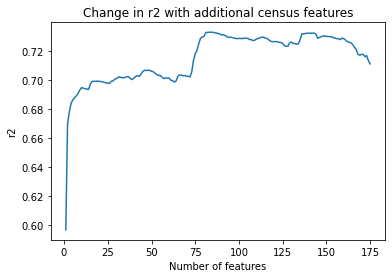

array([  0,   1,   2,   3,   4,   6,   7,   8,   9,  12,  13,  18,  22,
        26,  27,  28,  29,  30,  32,  33,  34,  35,  39,  41,  42,  46,
        48,  49,  50,  52,  54,  68,  69,  74,  75,  76,  78,  79,  80,
        81,  82,  83,  86,  87,  88,  89,  90,  92,  93,  98, 102, 103,
       104, 105, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 124,
       128, 129, 130, 135, 136, 137, 138, 139, 140, 141, 143, 144, 149,
       150, 157, 158, 159, 160, 167, 168, 170, 172, 173])

In [420]:
svr_optimal_index = get_optimal_index(svr_feat_subsets)
svr_optimal_index

## Generate train-test set

In [421]:
# Select only the top features
temp = np.append(svr_optimal_index+1, month_data_with_census.shape[1]-1)
month_data_with_census = month_data_with_census[:, np.insert(temp, 0, 0, axis=0)] # Insert month and target columns
month_data_with_census.shape

(546, 90)

In [422]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_no_census, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_with_census, 5)

In [423]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_no_census, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_with_census, 4)

In [424]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_no_census, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_with_census, 3)

In [425]:
nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, nc2m_ptX_arr, nc2m_pty_arr = n_month_window_split(month_data_no_census, 2)
wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, wc2m_ptX_arr, wc2m_pty_arr = n_month_window_split(month_data_with_census, 2)

In [426]:
nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, nc1m_ptX_arr, nc1m_pty_arr = n_month_window_split(month_data_no_census, 1)
wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, wc1m_ptX_arr, wc1m_pty_arr = n_month_window_split(month_data_with_census, 1)

/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountere

In [437]:
gb_param = {
    'n_estimators': 900,
    'max_depth': 2,
    'min_samples_split': 100,
    'learning_rate': 0.01,
    'loss': 'ls'
}
xg_model = XGBRegressor(**gb_param)

[00:35:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { loss, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE: [0.1495041226296426] 
r2: [0.802294469997854] 
MAE: [0.23176203761861325] 
avg: [-0.08040828841961946]


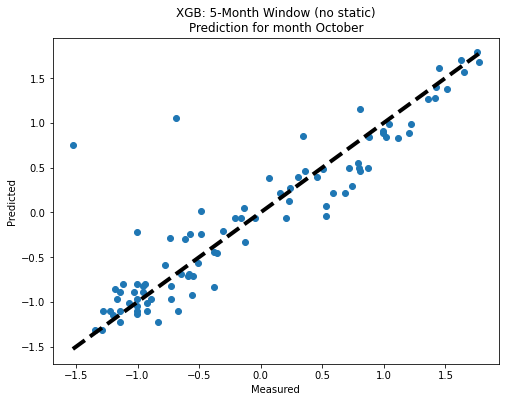

In [438]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, xg_model, "XGB: 5-Month Window (no static)", 5)

[00:35:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { loss, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE: [0.1614497400172439] 
r2: [0.7910883535596398] 
MAE: [0.24655981282501718] 
avg: [-0.08040828841961946]


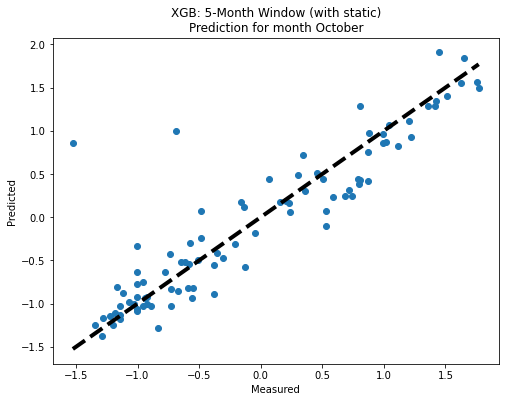

In [439]:
train_model(wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, xg_model, "XGB: 5-Month Window (with static)", 5)

# Scratch Work

In [ ]:
for i in range(1, month_data_with_census.shape[1]-1):
    s = skew(month_data_with_census[:,i])
    if abs(s) > 1:
        print("skewness: " + str(s))
        plt.hist(month_data_with_census[:,i])
        plt.title(feature_names[i-1])
        plt.show()
        print('###### Transform')
#         feat = (month_data_with_census[:,i].max()+1)-month_data_with_census[:,i]
        feat = (1+month_data_with_census[:,i])
        t1 = scale(power_transform(feat.reshape(-1,1)))
        print('yeo-johnson: ' + str(skew(t1)[0]))
        t2 = scale(np.log(feat))
        print('log: ' + str(skew(t2)))
        plt.hist(t2, alpha=0.5)
        plt.hist(t1, color='green')
        plt.title(feature_names[i-1])
        green_patch = mpatches.Patch(color='green', label='Yeo-Johnson')
        purple_patch = mpatches.Patch(color='blue', label='Log')
        plt.legend(handles=[green_patch, purple_patch])
        plt.show()
        


skewness: 2.9762547487661686


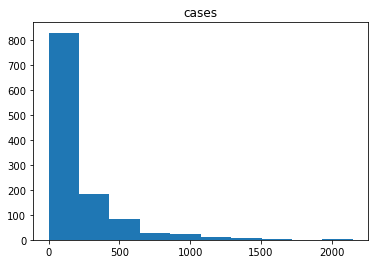

###### Transform
yeo-johnson: 0.48113957763969706
log: -0.71428111871356


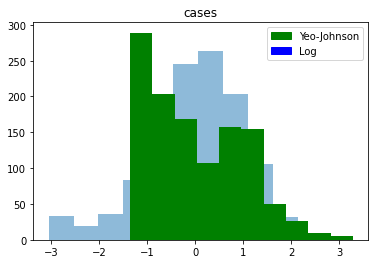

skewness: -4.7949961002304065


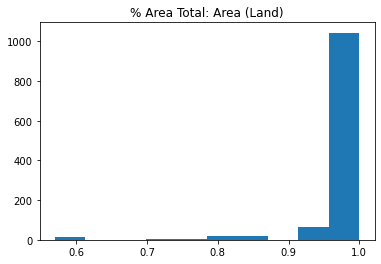

###### Transform
yeo-johnson: -1.3080951431080712
log: -5.03421510239529


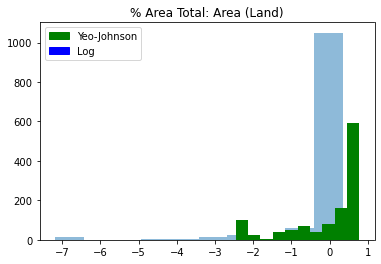

skewness: 4.794996113301362


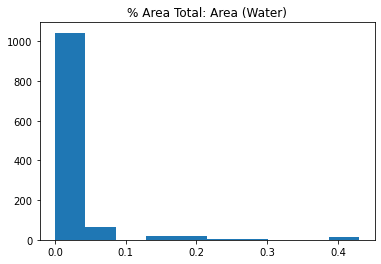

###### Transform
yeo-johnson: 1.3080956026718742
log: 4.462042116043954


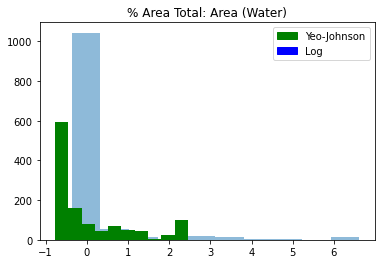

skewness: 6.007001959232682


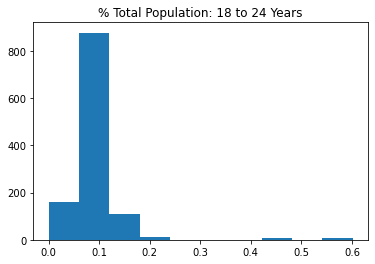

###### Transform
yeo-johnson: -0.3021198745503583
log: 4.928319288784161


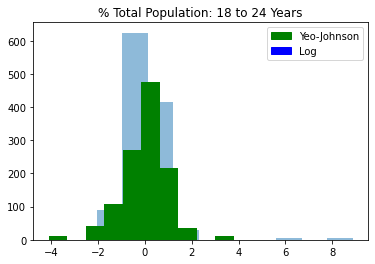

skewness: 2.182637401230593


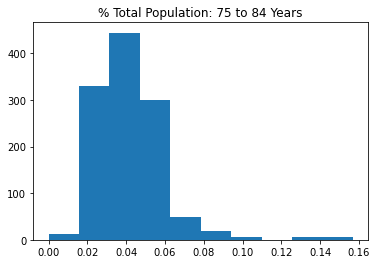

###### Transform
yeo-johnson: -0.09071875698875437
log: 2.0079324729120027


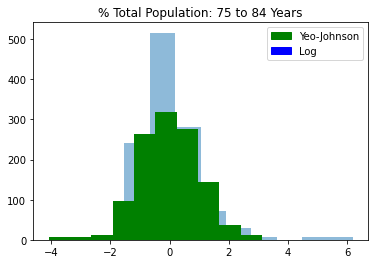

skewness: 4.516707000025778


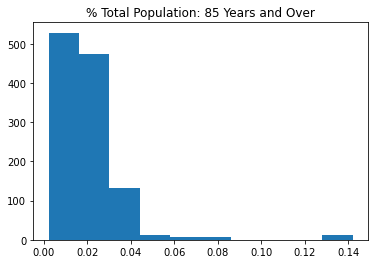

###### Transform
yeo-johnson: 0.15025620177088414
log: 4.2789038757775355


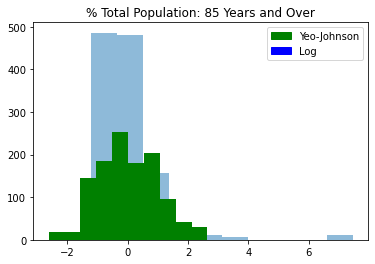

skewness: 1.3856279732160195


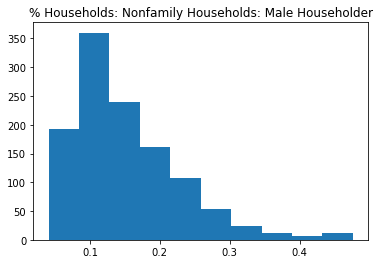

###### Transform
yeo-johnson: 0.14148192055120332
log: 1.1644444794041036


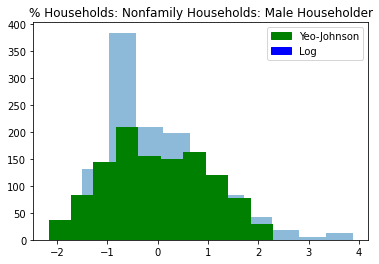

skewness: 4.055394228378427


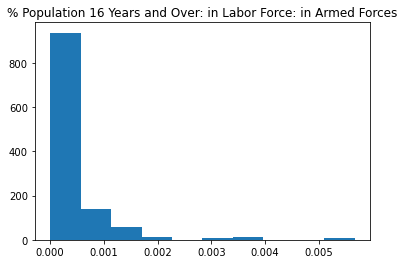

###### Transform
yeo-johnson: 0.7470850752026075
log: 4.047575131042297


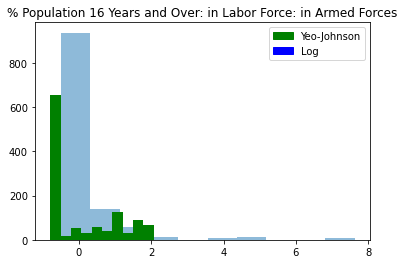

skewness: 3.5039151395008865


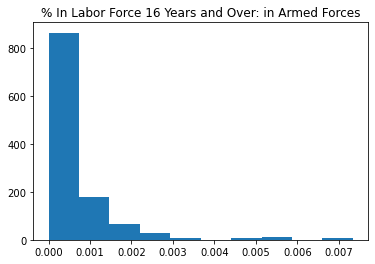

###### Transform
yeo-johnson: 0.7365112417736647
log: 3.495563727337855


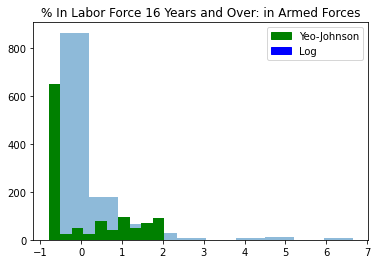

skewness: -3.503915124812041


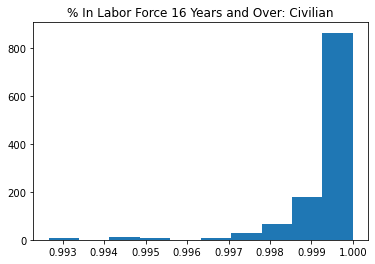

###### Transform
yeo-johnson: -0.7365112304174944
log: -3.508116759984531


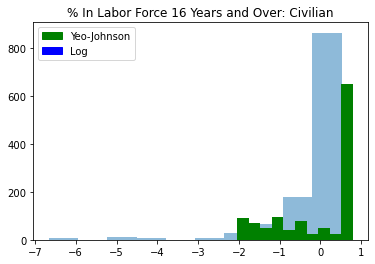

skewness: 1.413380947585506


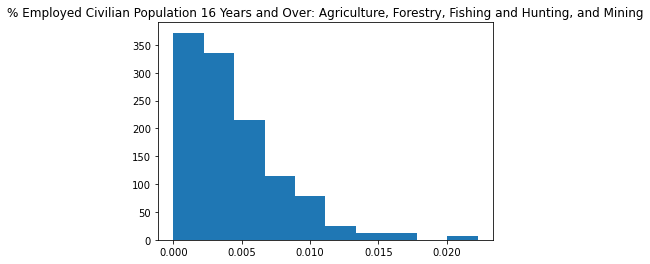

###### Transform
yeo-johnson: 0.12736250704943403
log: 1.3970087903441557


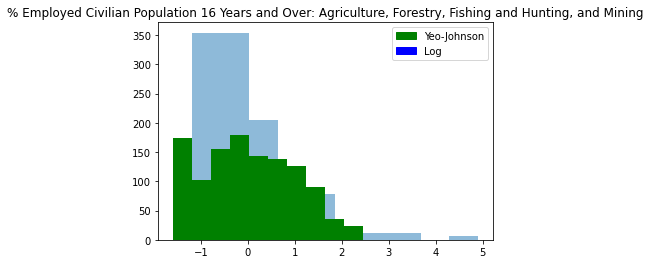

skewness: 1.3941967132671191


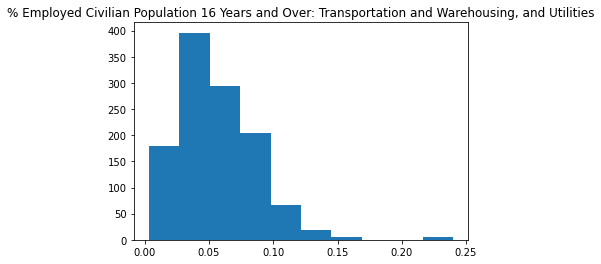

###### Transform
yeo-johnson: 0.026429013937023963
log: 1.1916602906541807


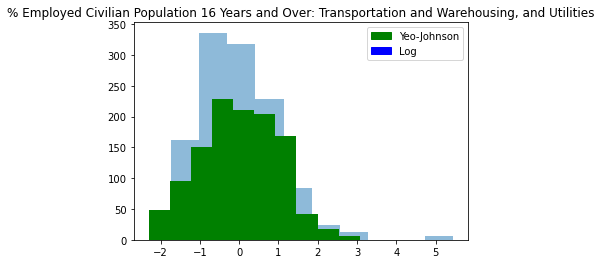

skewness: 1.5490195573916714


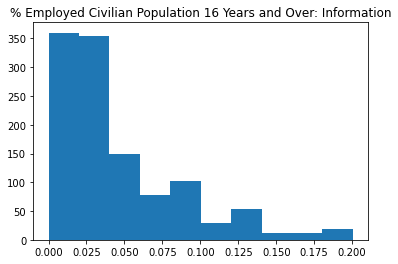

###### Transform
yeo-johnson: 0.30568342104093926
log: 1.4494624274369834


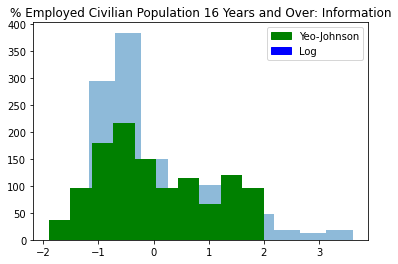

skewness: 1.3823708954893648


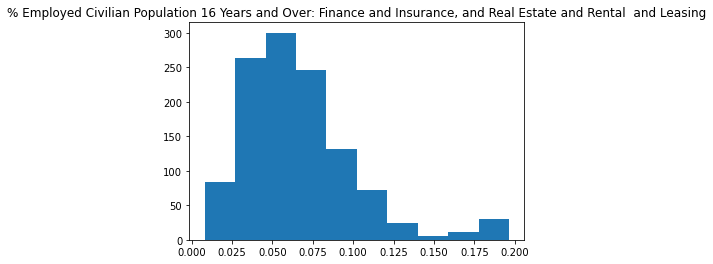

###### Transform
yeo-johnson: 0.07639351052032103
log: 1.2664266253189054


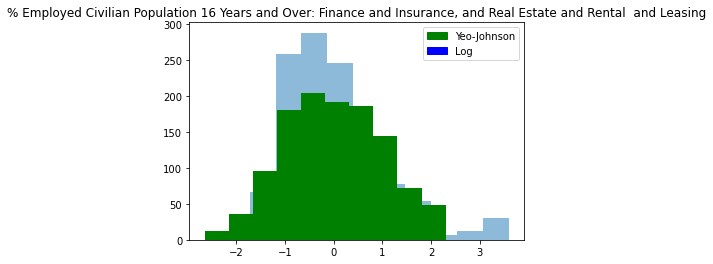

skewness: 1.2709251302963944


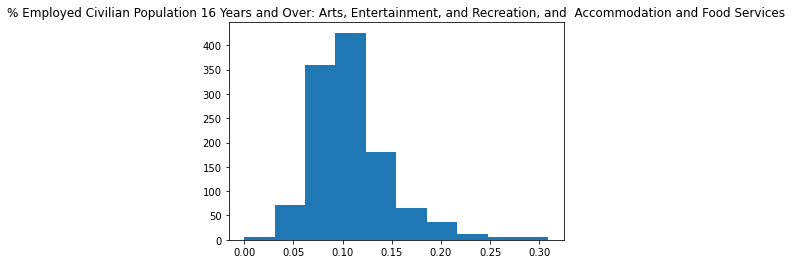

###### Transform
yeo-johnson: -0.10220110324679496
log: 1.0681567339471545


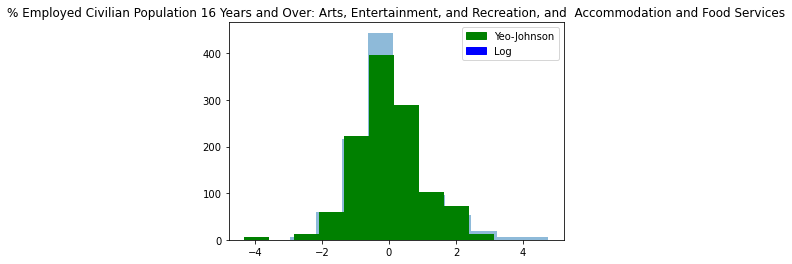

skewness: 6.725396298805839


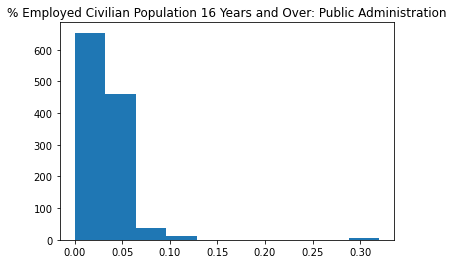

###### Transform
yeo-johnson: 0.058656293567650356
log: 5.904271897197785


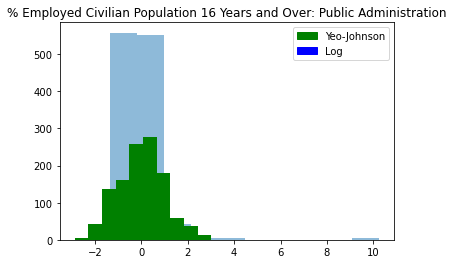

skewness: 1.2629345210429836


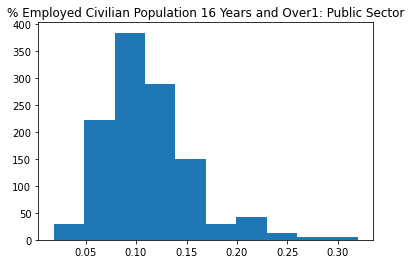

###### Transform
yeo-johnson: 0.005745082507055816
log: 1.0839812536657267


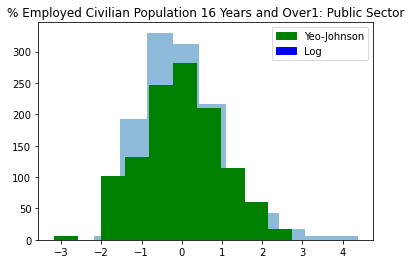

skewness: 1.3552909751843618


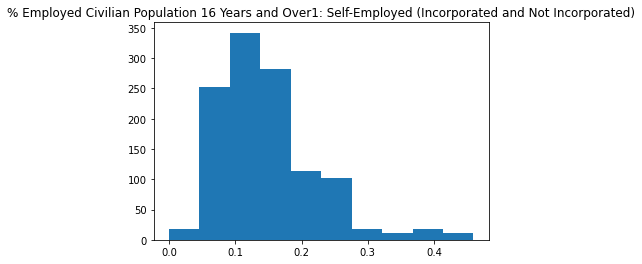

###### Transform
yeo-johnson: 0.017758862739235957
log: 1.103933684710842


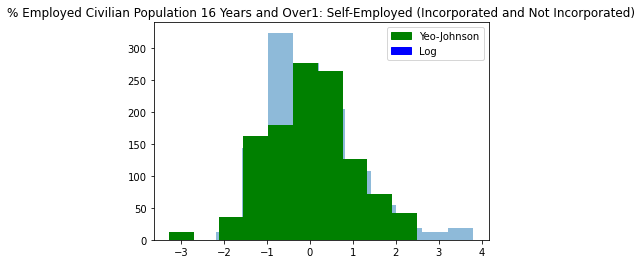

skewness: 1.8855207466722015


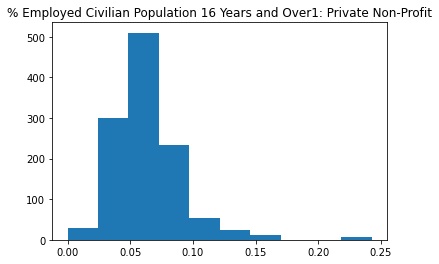

###### Transform
yeo-johnson: -0.12250541157318594
log: 1.6370446215960435


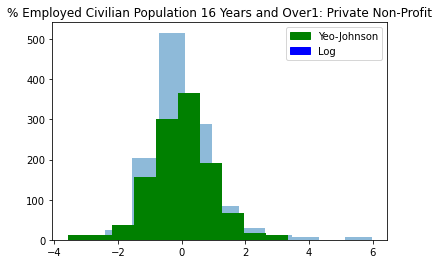

skewness: 4.972531729363612


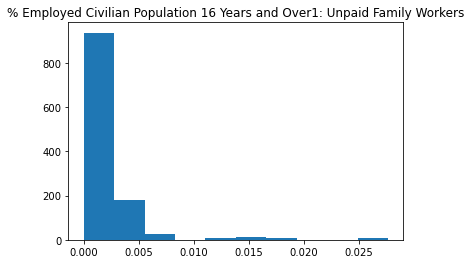

###### Transform
yeo-johnson: 0.33653477684738764
log: 4.927944848394479


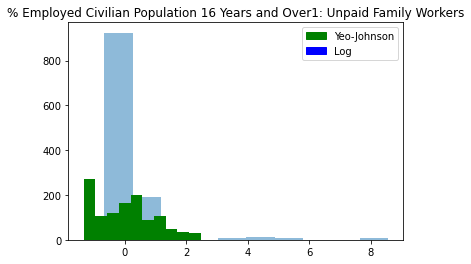

skewness: -2.1174141440519114


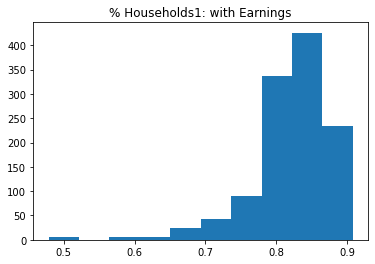

###### Transform
yeo-johnson: -0.046206333105672535
log: -2.4044853133089976


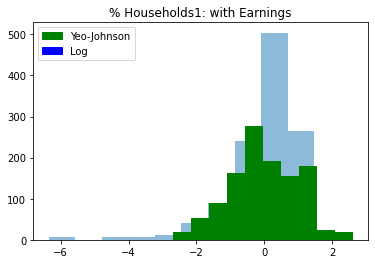

skewness: 2.1174141440763834


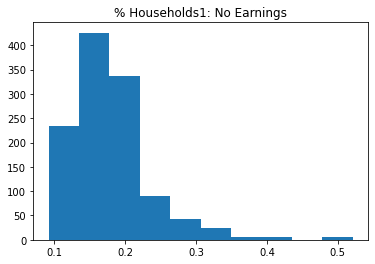

###### Transform
yeo-johnson: 0.046206344131653664
log: 1.7769049866186224


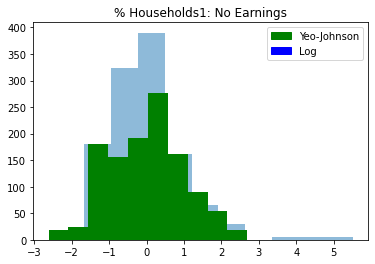

skewness: -1.4658866446096197


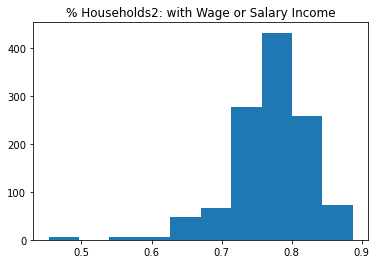

###### Transform
yeo-johnson: 0.055734099238485726
log: -1.7396913576773247


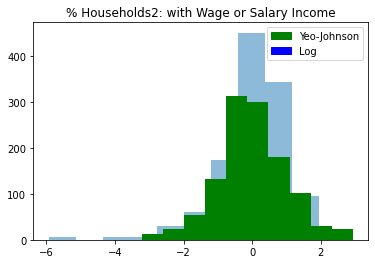

skewness: 1.4658866446096188


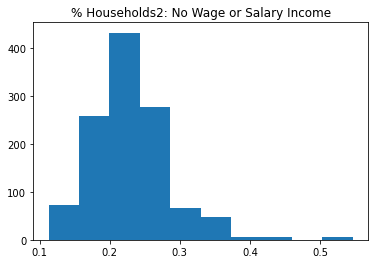

###### Transform
yeo-johnson: -0.05573404635936069
log: 1.15110500578795


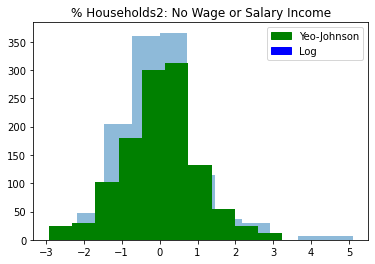

skewness: 1.130141865217886


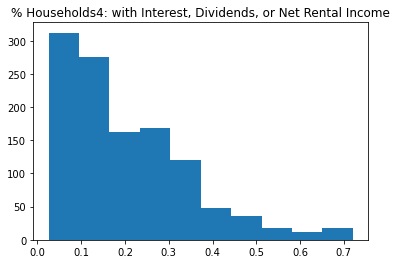

###### Transform
yeo-johnson: 0.19527607510560763
log: 0.8702112443158774


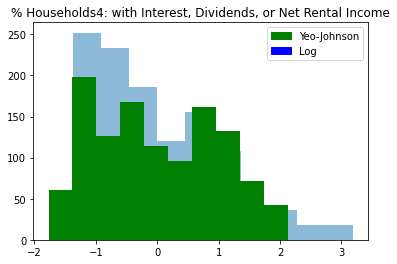

skewness: -1.1301418651733064


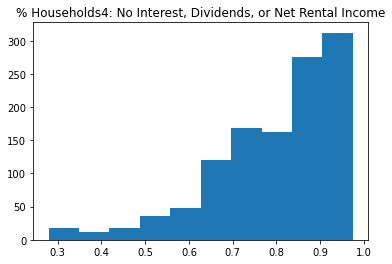

###### Transform
yeo-johnson: -0.19527604221167605
log: -1.3715462861426455


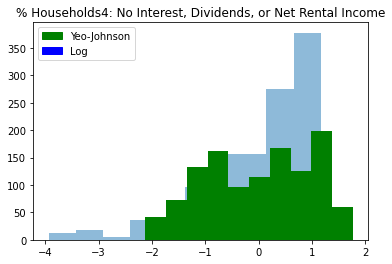

skewness: 1.332222894265681


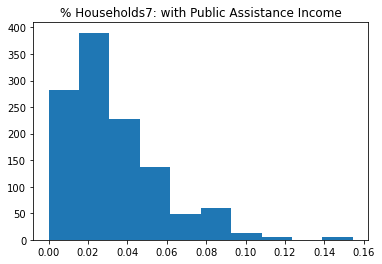

###### Transform
yeo-johnson: 0.11320867226193936
log: 1.2361448275525875


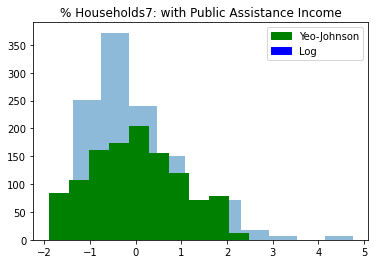

skewness: -1.332222894048607


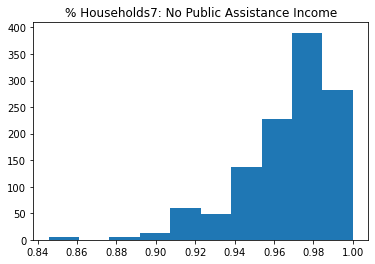

###### Transform
yeo-johnson: -0.11320865807469446
log: -1.3879632985939507


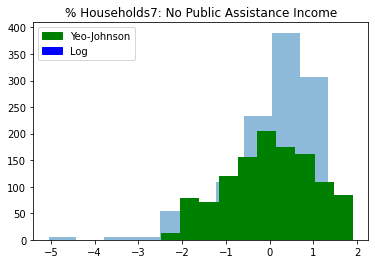

skewness: 1.0528514706448768


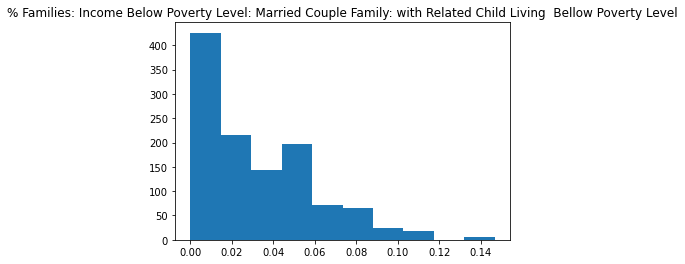

###### Transform
yeo-johnson: 0.19298001020352715
log: 0.9851729794538815


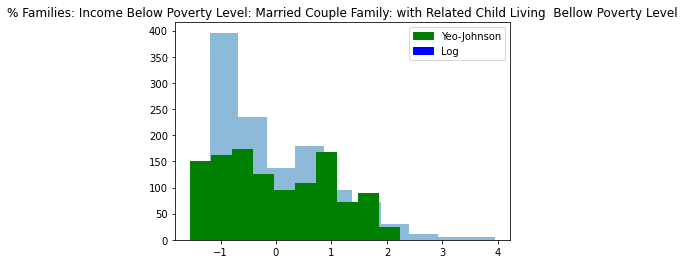

skewness: 3.253398004191487


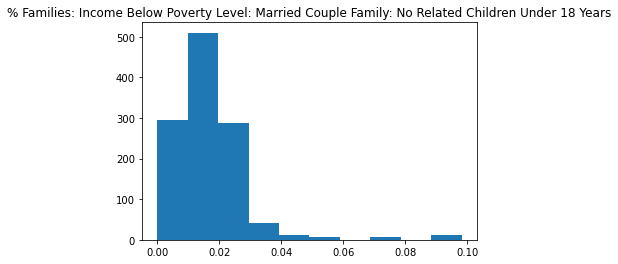

###### Transform
yeo-johnson: -0.04528760890394471
log: 3.09921071928261


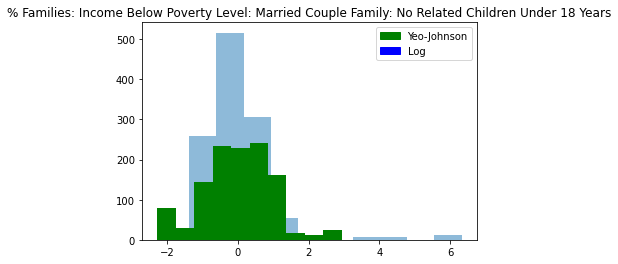

skewness: 1.3274115023391513


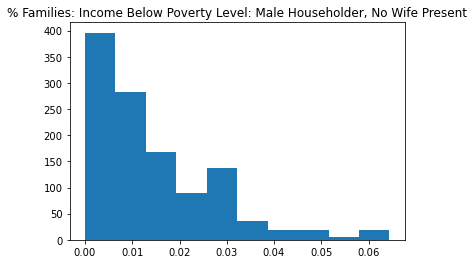

###### Transform
yeo-johnson: 0.20210755796085314
log: 1.2880687943284514


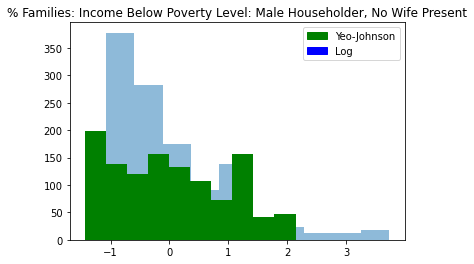

skewness: 1.5018077460023347


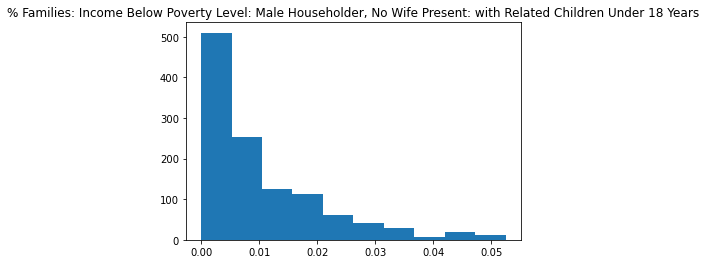

###### Transform
yeo-johnson: 0.29976680859321747
log: 1.4711738764667381


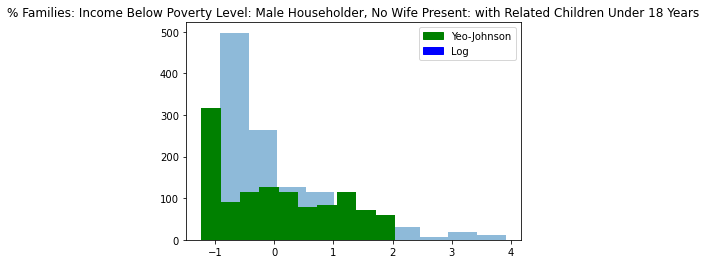

skewness: 1.9940860110467893


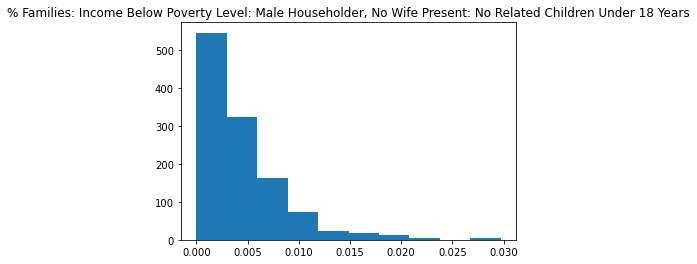

###### Transform
yeo-johnson: 0.20962190336687667
log: 1.9673395277452583


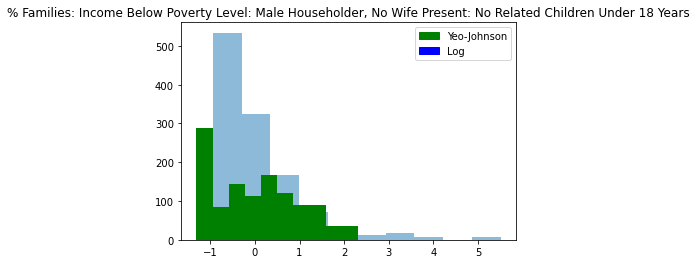

skewness: 1.2199213830893185


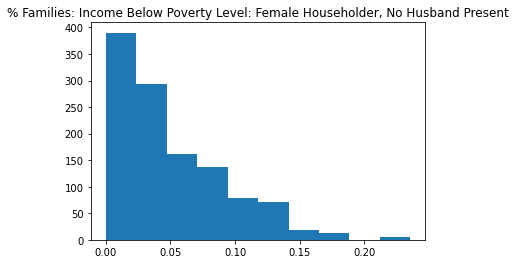

###### Transform
yeo-johnson: 0.21550360930005633
log: 1.1138474243372558


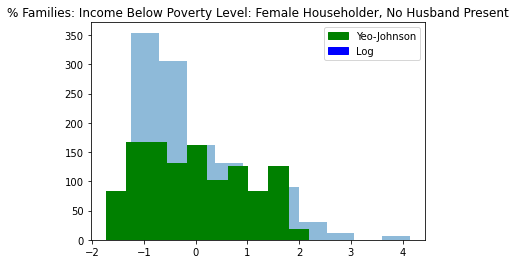

skewness: 1.3928854362716723


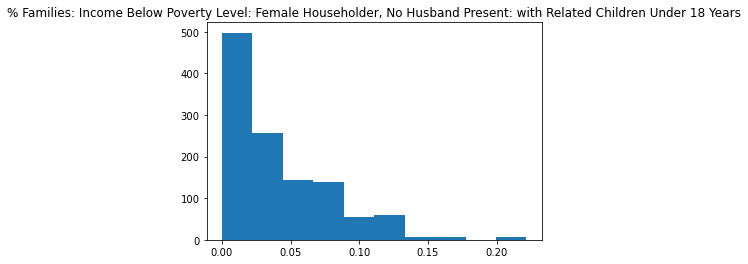

###### Transform
yeo-johnson: 0.2489677391970462
log: 1.2746749542488225


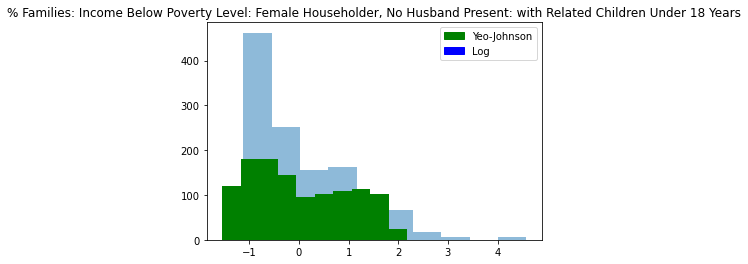

skewness: 1.38031691056559


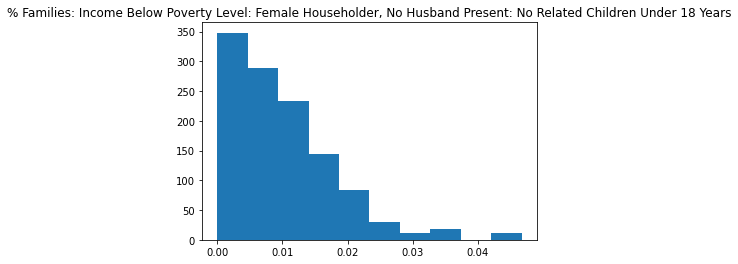

###### Transform
yeo-johnson: 0.11098705112584255
log: 1.3443835720301773


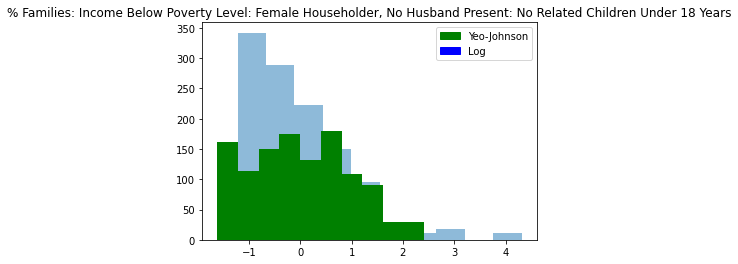

skewness: 1.5401213119370571


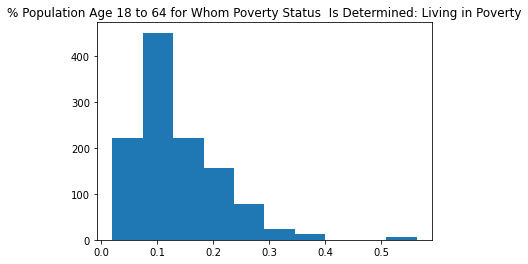

###### Transform
yeo-johnson: 0.11344819552262651
log: 1.2109854829230142


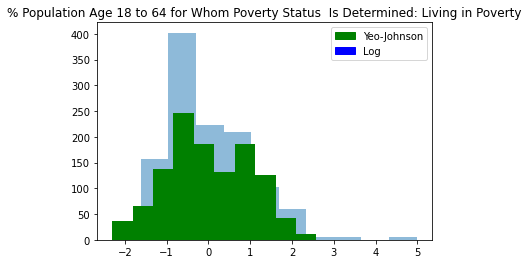

skewness: -1.5401213120267128


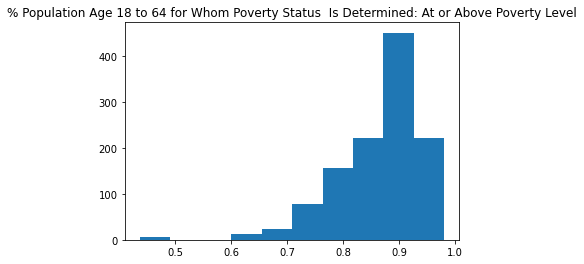

###### Transform
yeo-johnson: -0.11344818906266435
log: -1.8363684136298537


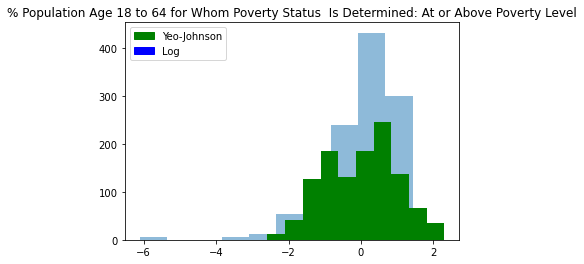

skewness: 1.3690716991595346


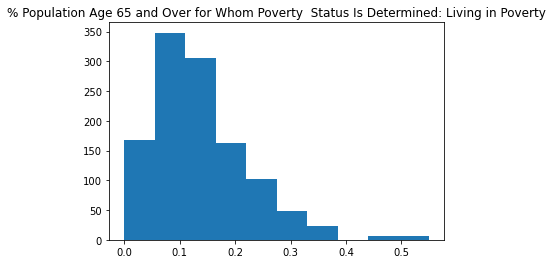

###### Transform
yeo-johnson: 0.06534801098769255
log: 1.062870191447161


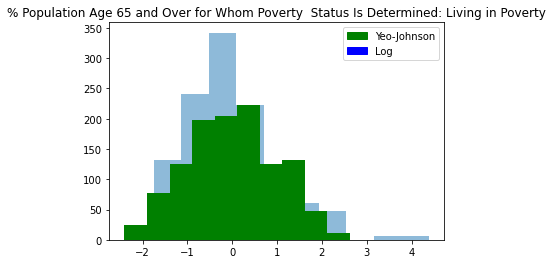

skewness: -1.3690716991256324


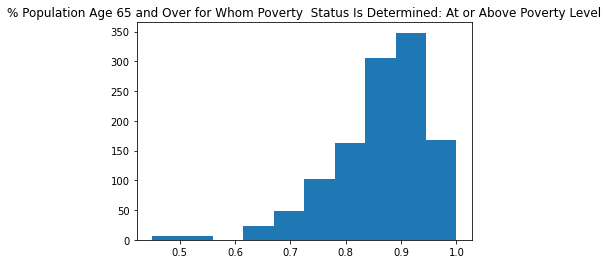

###### Transform
yeo-johnson: -0.06534803854125781
log: -1.6219934423844775


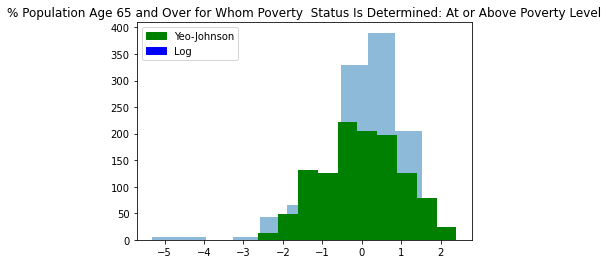

skewness: 2.7834402540364214


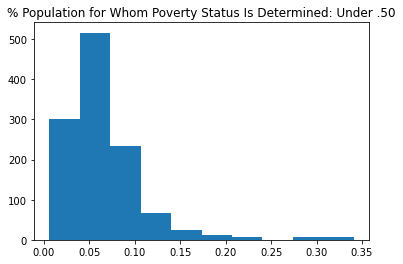

###### Transform
yeo-johnson: 0.09424187573151092
log: 2.440125492211598


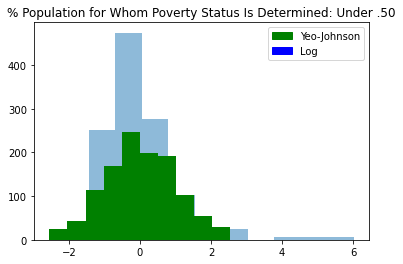

skewness: 1.0124239644576347


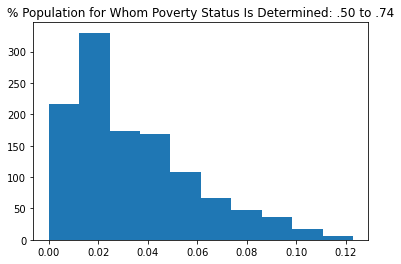

###### Transform
yeo-johnson: 0.16315599871238376
log: 0.9588407637007872


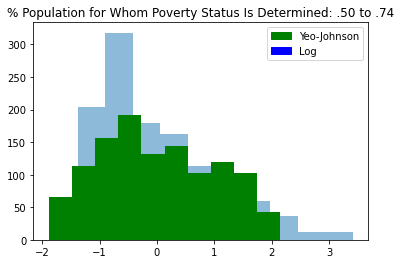

skewness: 1.0377192605902008


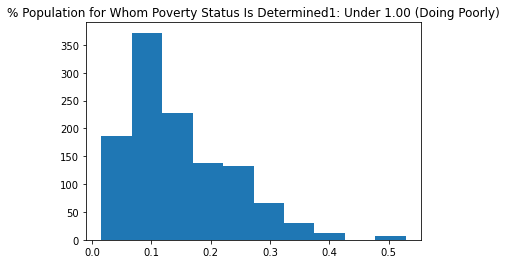

###### Transform
yeo-johnson: 0.12728450432835836
log: 0.8357694460993387


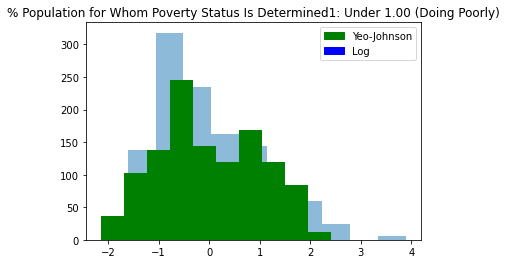

skewness: 1.0042833273493772


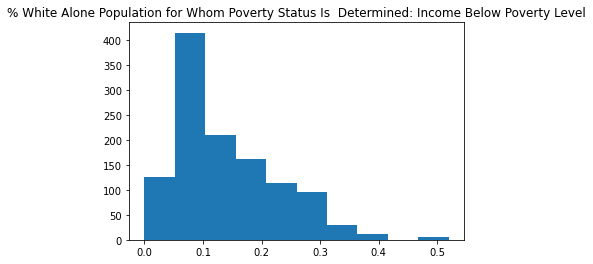

###### Transform
yeo-johnson: 0.13389947296492616
log: 0.8059820840634847


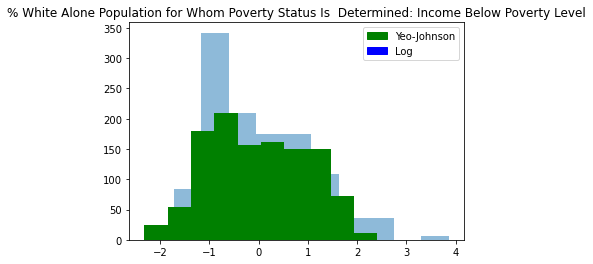

skewness: -1.00428332736808


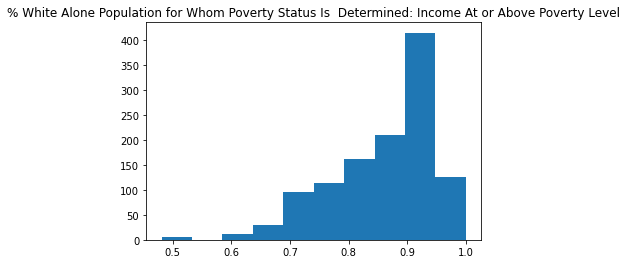

###### Transform
yeo-johnson: -0.13389949128059234
log: -1.163973139156107


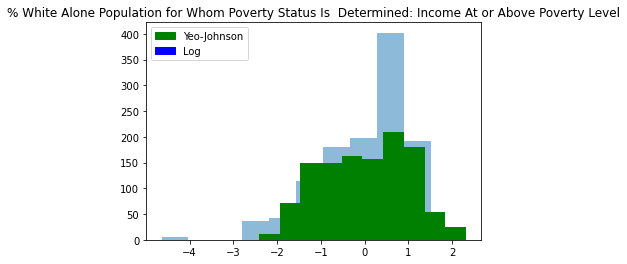

skewness: 2.2191232795470586


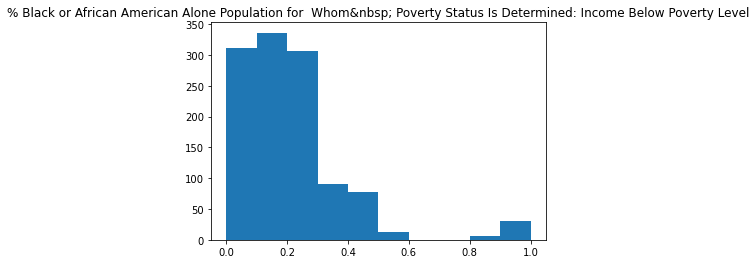

###### Transform
yeo-johnson: 0.07049361048126958
log: 1.5134797069300887


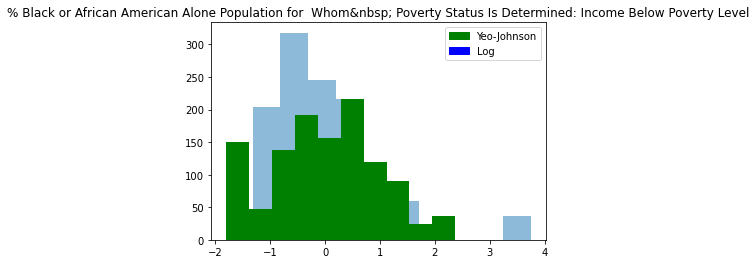

skewness: -2.219123279513483


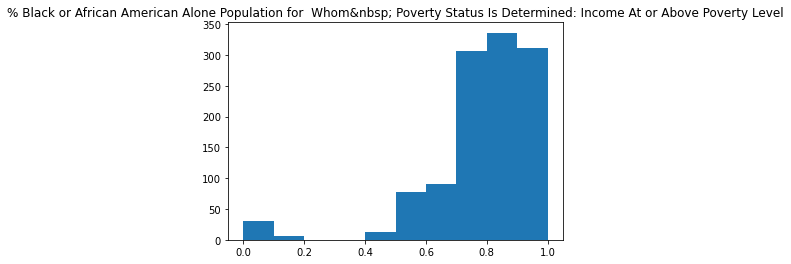

###### Transform
yeo-johnson: -0.07049358670295339
log: -2.956940649206257


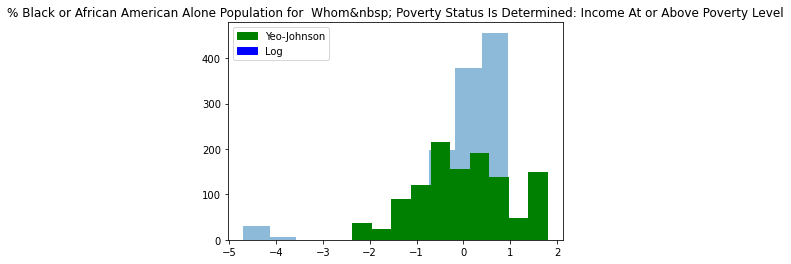

skewness: 1.8038237435037854


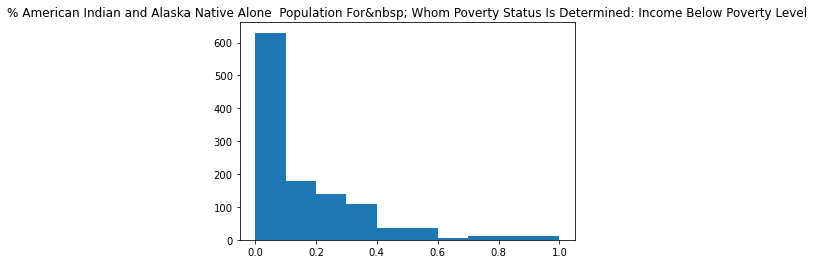

###### Transform
yeo-johnson: 0.370310004148365
log: 1.3407380729413487


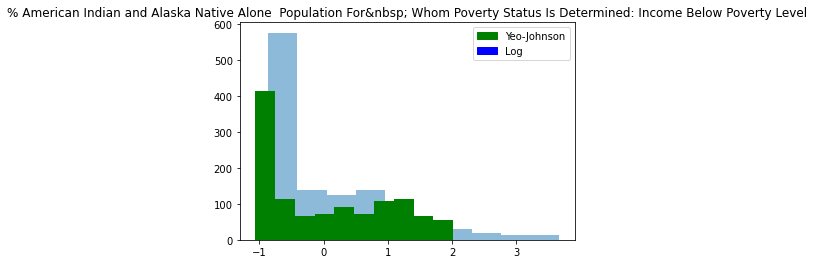

skewness: -1.3625930463791642


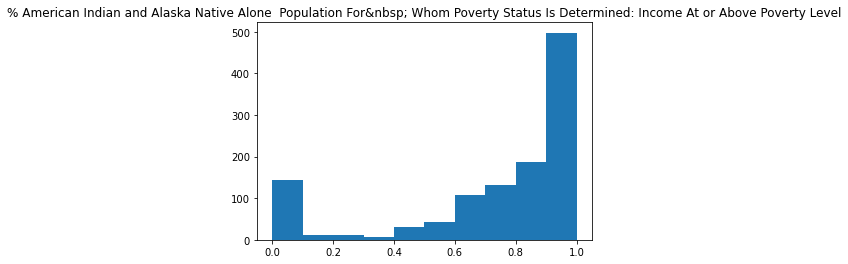

###### Transform
yeo-johnson: -0.37180733180068604
log: -1.5896675775991727


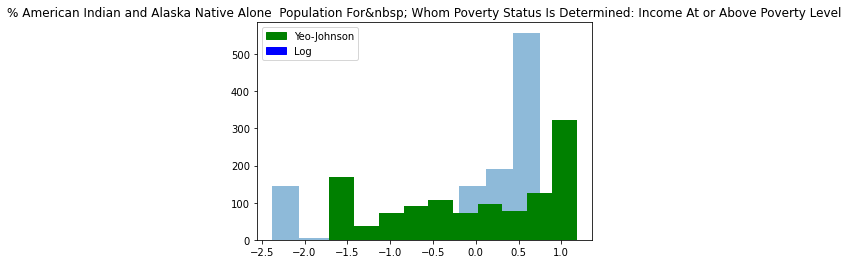

skewness: 3.11688083590141


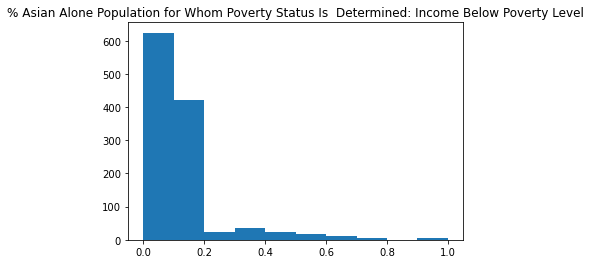

###### Transform
yeo-johnson: 0.11993560217221408
log: 2.5458042883504524


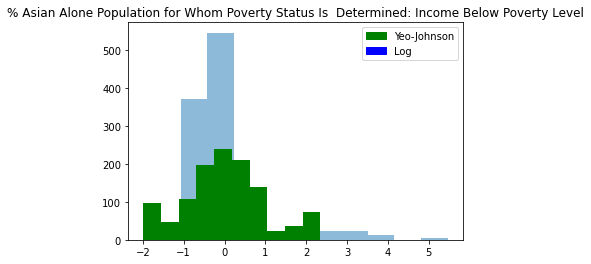

skewness: -3.2775456199202306


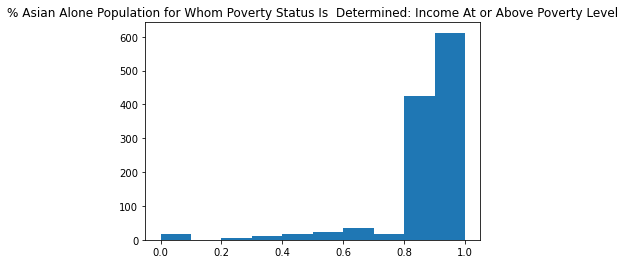

###### Transform
yeo-johnson: -0.18820855850283988
log: -3.888467514775514


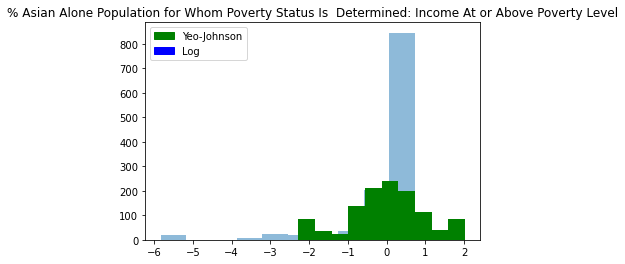

skewness: 2.916514982433868


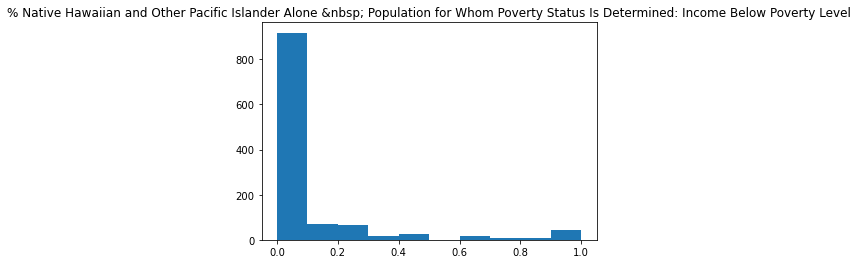

###### Transform
yeo-johnson: 1.1700918096688495
log: 2.570975500217522


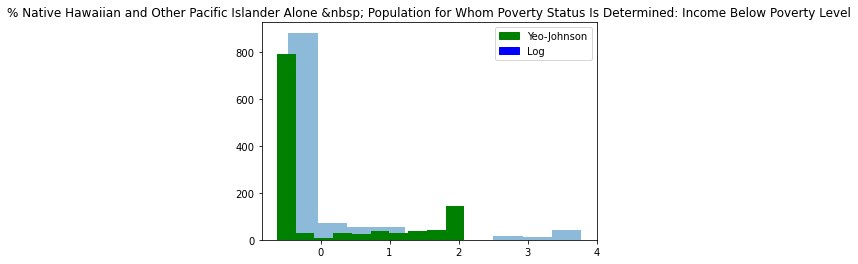

skewness: 1.8227657001378885


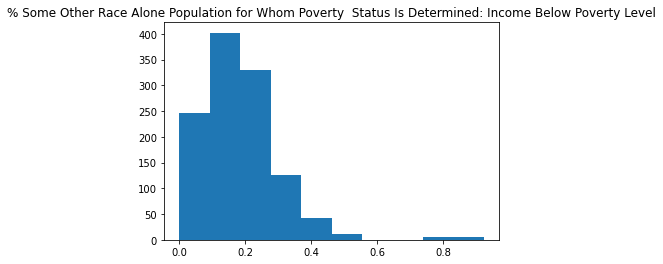

###### Transform
yeo-johnson: -0.011408892301383176
log: 1.0621229838486077


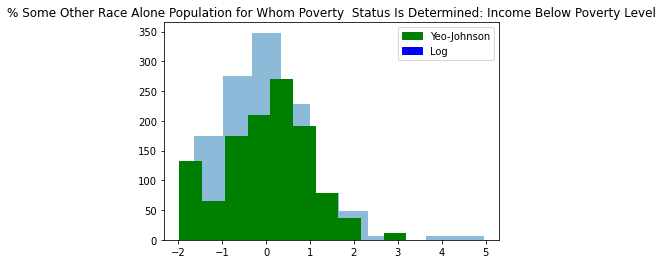

skewness: -2.360058041346531


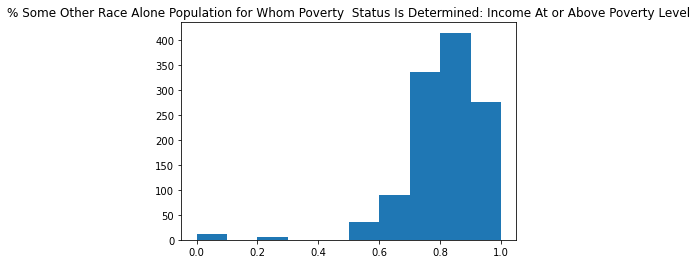

###### Transform
yeo-johnson: 0.02174633392422419
log: -3.3984113053078766


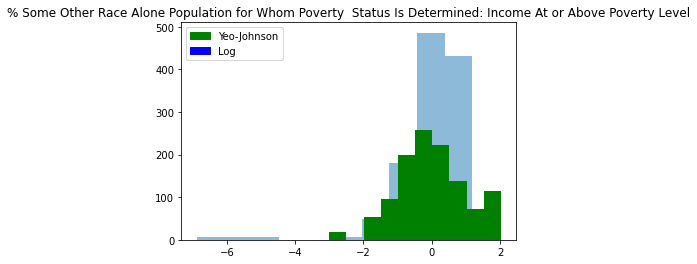

skewness: 1.4172197115319096


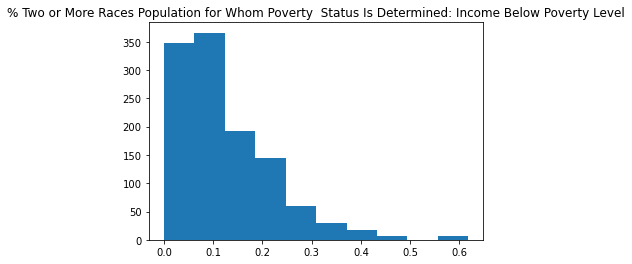

###### Transform
yeo-johnson: 0.11886031600169271
log: 1.0899663530575892


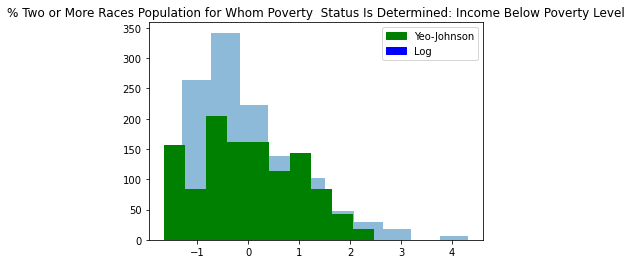

skewness: -2.834242418850117


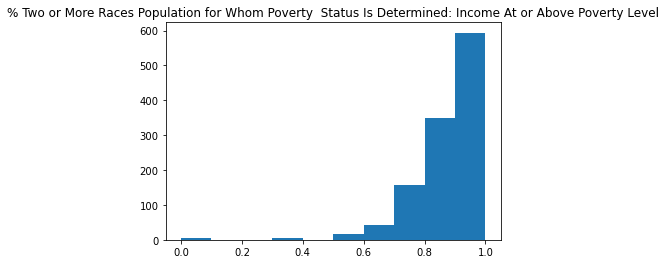

###### Transform
yeo-johnson: -0.12675308626504253
log: -4.108655848797457


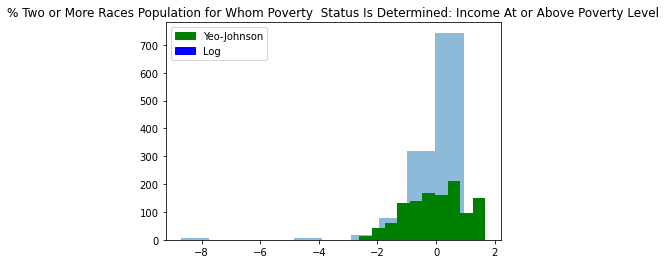

skewness: 2.2944252105592247


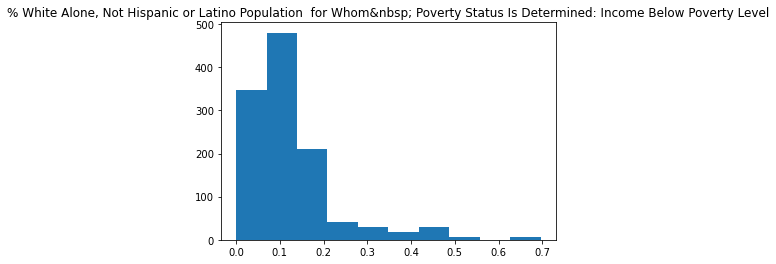

###### Transform
yeo-johnson: 0.18693388560538488
log: 1.9083771251827124


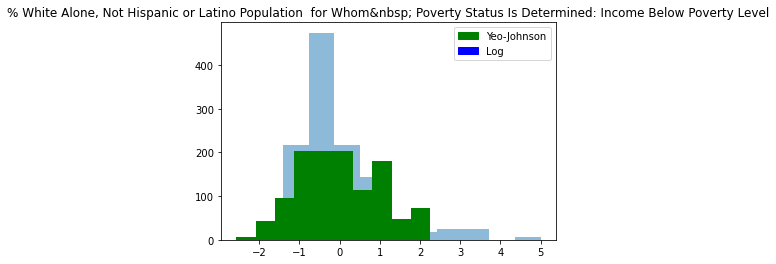

skewness: -2.2944252105204996


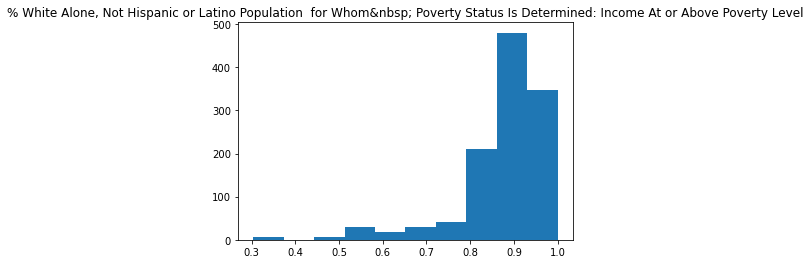

###### Transform
yeo-johnson: -0.18693389084670425
log: -2.64454196673997


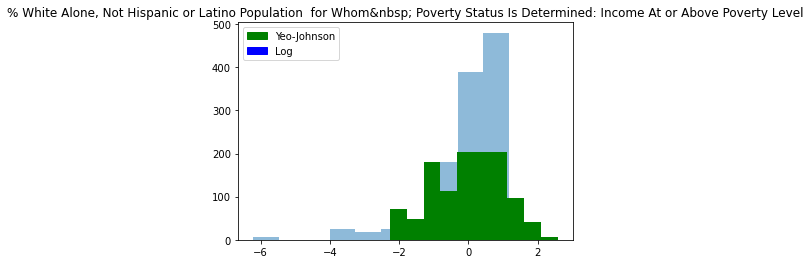

skewness: -2.359662135375562


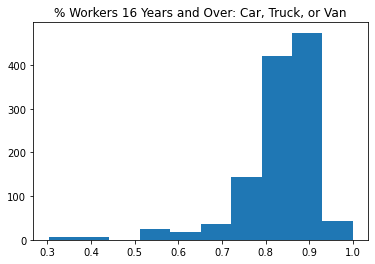

###### Transform
yeo-johnson: 0.010397084719279472
log: -2.7879299476706194


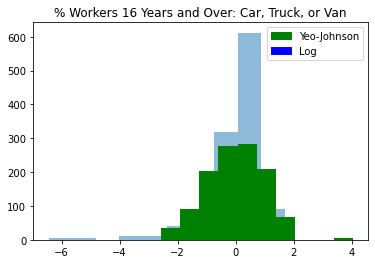

skewness: -2.1937787593822184


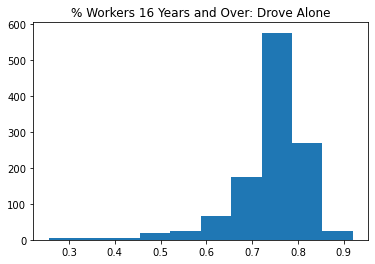

###### Transform
yeo-johnson: 0.13350834605410292
log: -2.6150095283382098


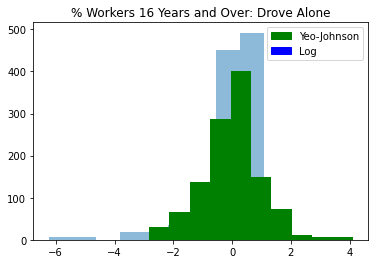

skewness: 2.2840279217684625


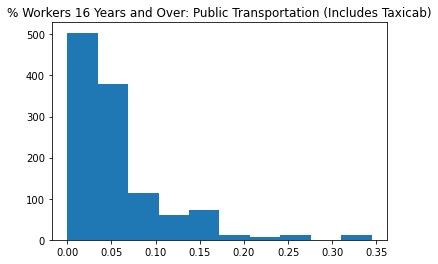

###### Transform
yeo-johnson: 0.27036441531512273
log: 2.0459439560096553


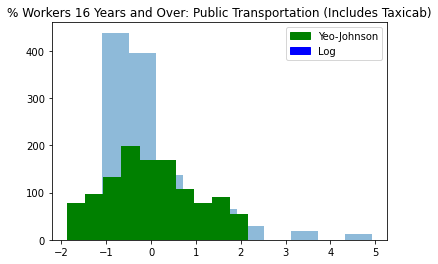

skewness: 2.2203586986839086


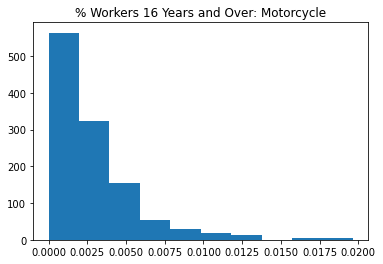

###### Transform
yeo-johnson: 0.23737758731128464
log: 2.2013574877060074


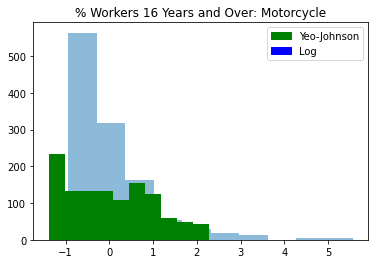

skewness: 4.655956491796831


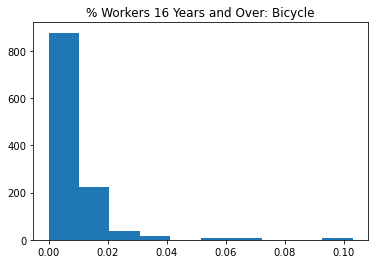

###### Transform
yeo-johnson: 0.33359723088133275
log: 4.479111758998151


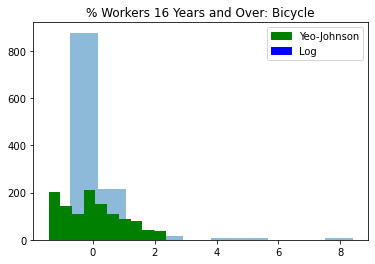

skewness: 6.838988867108768


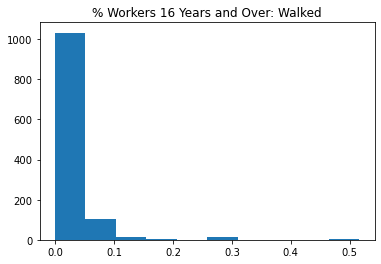

###### Transform
yeo-johnson: 0.4605578245909095
log: 6.050667603384809


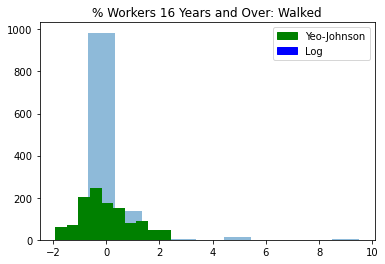

skewness: 2.824217563113897


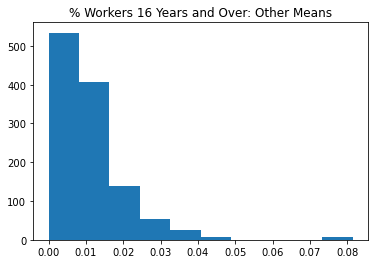

###### Transform
yeo-johnson: 0.10873846067185208
log: 2.702582579124601


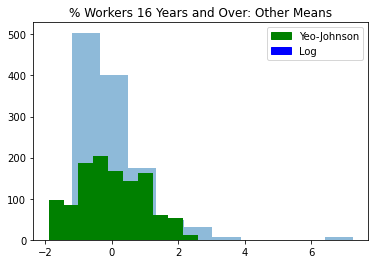

skewness: 2.663827238145871


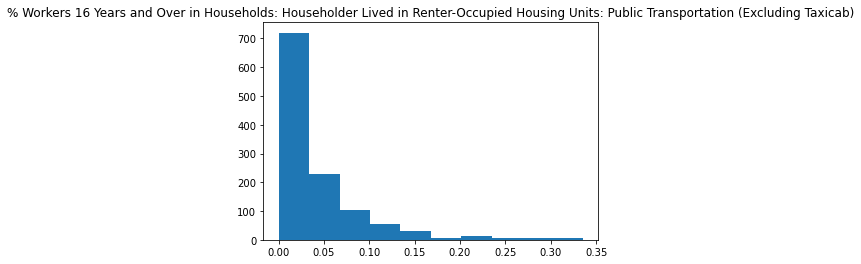

###### Transform
yeo-johnson: 0.41634953764075305
log: 2.405227067891901


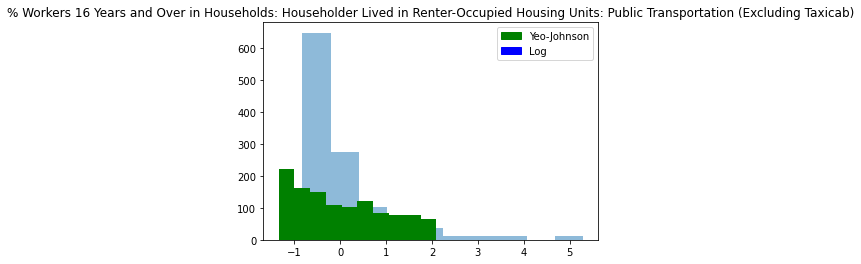

skewness: 7.8264550818058884


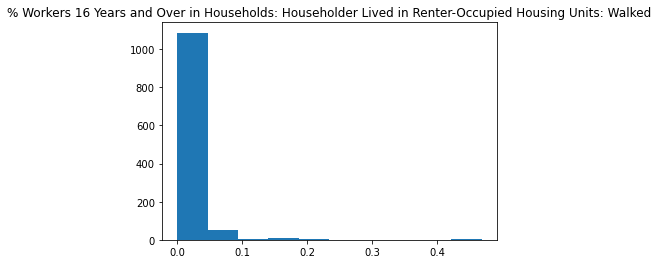

###### Transform
yeo-johnson: 0.5349485733812455
log: 6.953095612758595


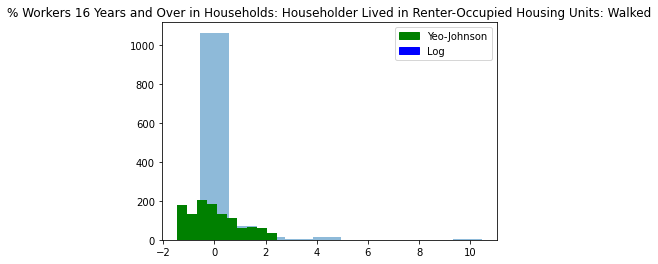

skewness: 3.0831466950987614


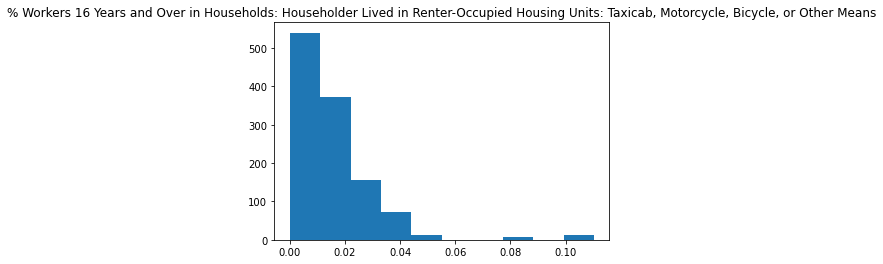

###### Transform
yeo-johnson: 0.14434066407446156
log: 2.920447630064841


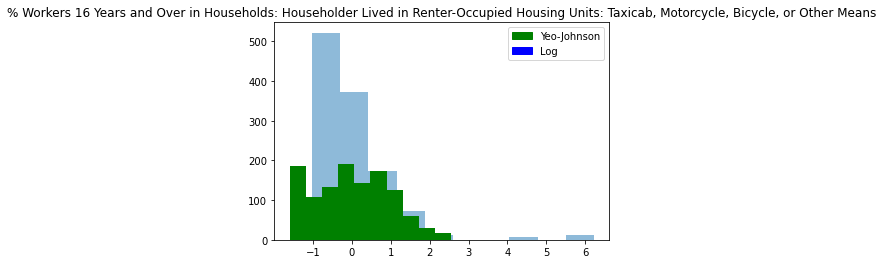

skewness: 1.5523726362555745


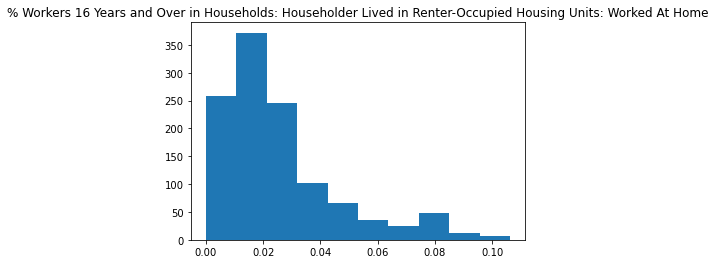

###### Transform
yeo-johnson: 0.18217585514628268
log: 1.5000229568402275


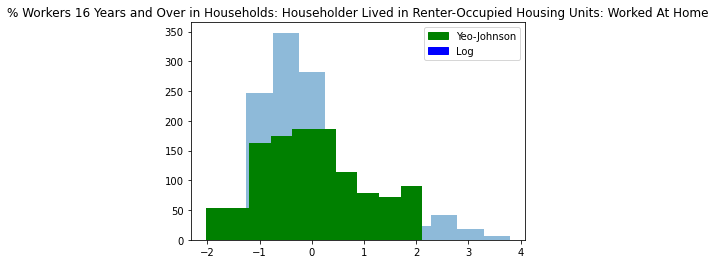

skewness: 6.542878945316615


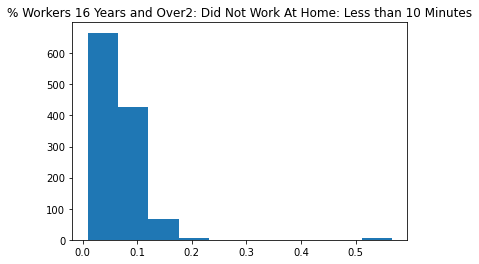

###### Transform
yeo-johnson: 0.00918476574187173
log: 5.209685144930256


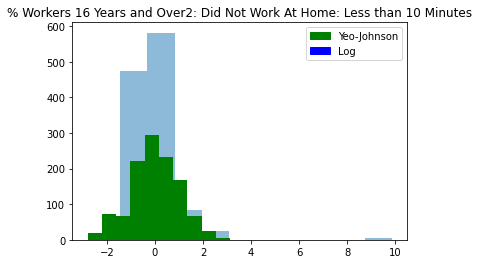

skewness: 2.049341614234752


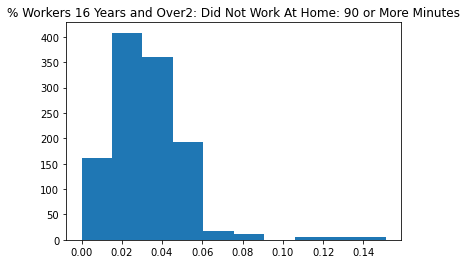

###### Transform
yeo-johnson: -0.07742280471312937
log: 1.8646885089171088


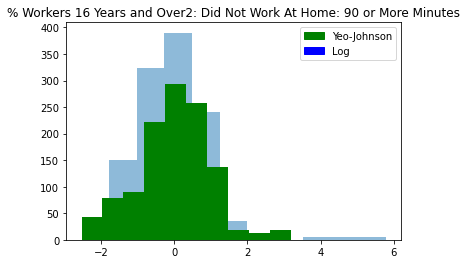

skewness: 1.3831457797522244


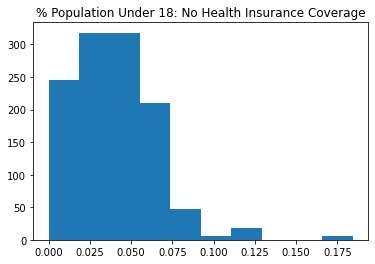

###### Transform
yeo-johnson: 0.0024062373963486543
log: 1.212999012715787


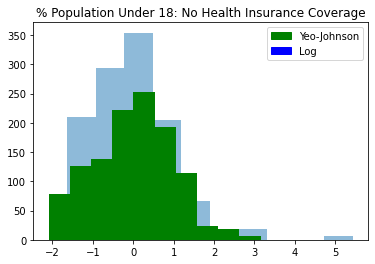

skewness: -1.3831457799177322


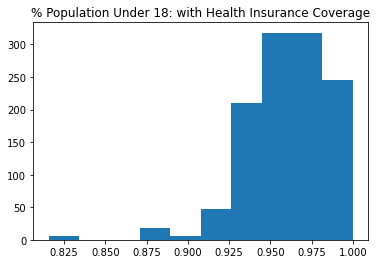

###### Transform
yeo-johnson: -0.0024061971385184694
log: -1.485914800025174


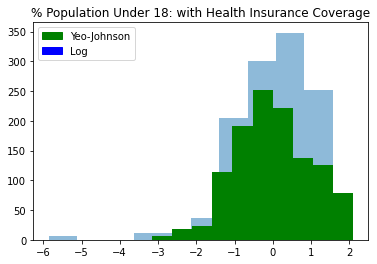

skewness: -3.402537376907379


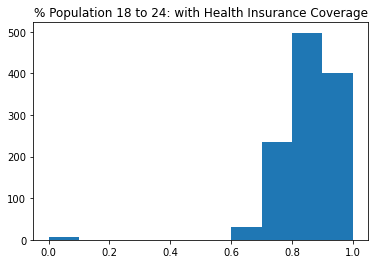

###### Transform
yeo-johnson: 0.04695122029995181
log: -5.381397953147537


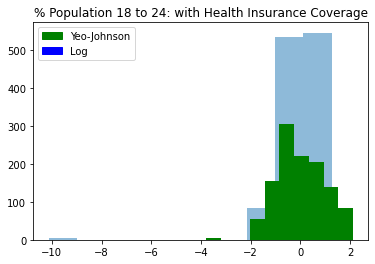

skewness: 1.720905685589176


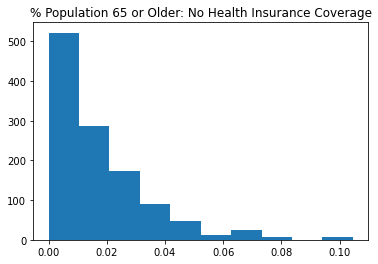

###### Transform
yeo-johnson: 0.20284970645396944
log: 1.6406005247490976


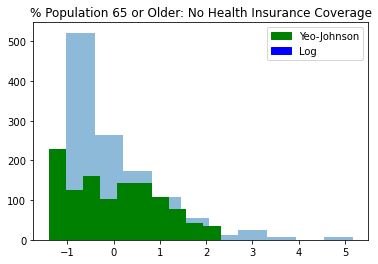

skewness: -1.7209056854446396


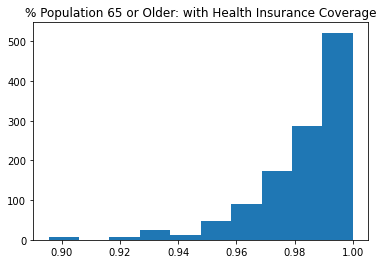

###### Transform
yeo-johnson: -0.2028497642572945
log: -1.7652946644949994


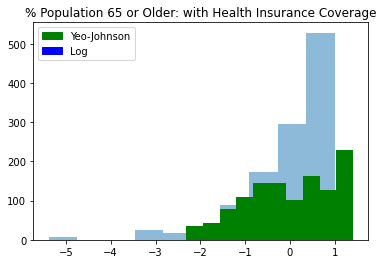

skewness: 1.441391444248443


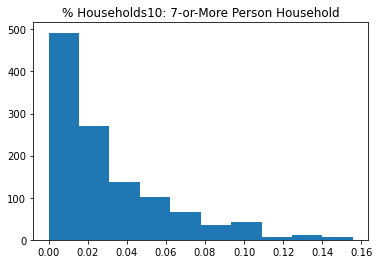

###### Transform
yeo-johnson: 0.28579316639971347
log: 1.3618581484297867


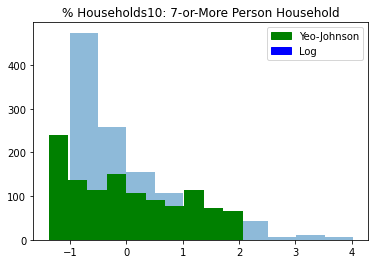

In [99]:
pipe = make_pipeline(StandardScaler(with_std=False), PowerTransformer(standardize=True))
for i in range(1, month_data_with_census.shape[1]-1):
    s = skew(month_data_with_census[:,i])
    if abs(s) > 1:
        print("skewness: " + str(s))
        plt.hist(month_data_with_census[:,i])
        plt.title(feature_names[i-1])
        plt.show()
        print('###### Transform')
#         feat = (month_data_with_census[:,i].max()+1)-month_data_with_census[:,i]
        feat = (1+month_data_with_census[:,i])
#         t1 = scale(power_transform(feat.reshape(-1,1)))
        t1 = pipe.fit_transform(feat.reshape(-1,1))
        print('yeo-johnson: ' + str(skew(t1)[0]))
        t2 = scale(np.log(feat))
        print('log: ' + str(skew(t2)))
        plt.hist(t2, alpha=0.5)
        plt.hist(t1, color='green')
        plt.title(feature_names[i-1])
        green_patch = mpatches.Patch(color='green', label='Yeo-Johnson')
        purple_patch = mpatches.Patch(color='blue', label='Log')
        plt.legend(handles=[green_patch, purple_patch])
        plt.show()
        


skewness: 0.5064490673919555


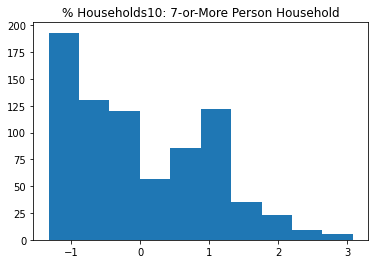

skewness: 0.3090412098025316


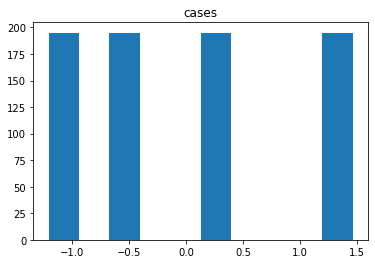

skewness: -1.308095142270768


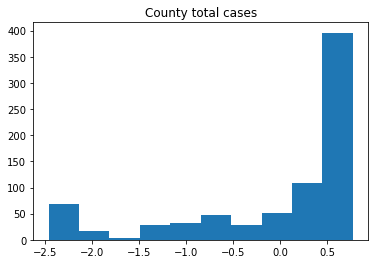

skewness: 1.3080955900658437


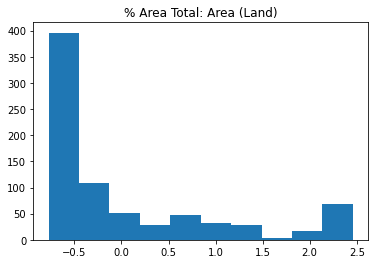

skewness: 0.011813500741797496


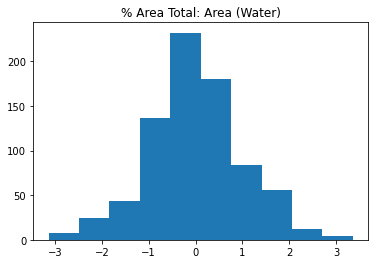

skewness: 0.004767130686792724


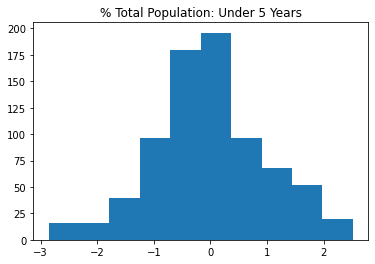

skewness: -0.007984318250033946


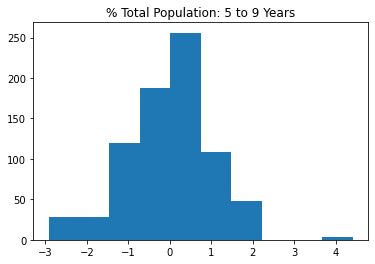

skewness: 0.005552599188141118


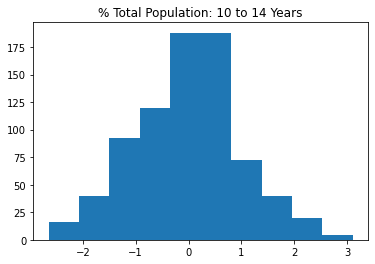

skewness: -0.30211987450172767


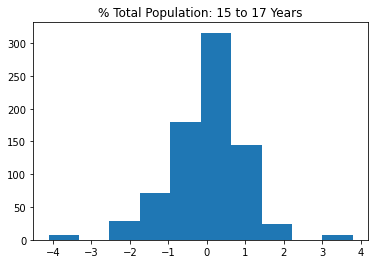

skewness: -0.05521094849258715


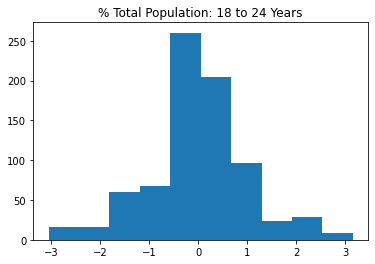

skewness: 0.02046963540140671


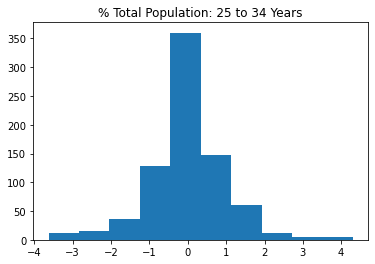

skewness: 0.0768951461753422


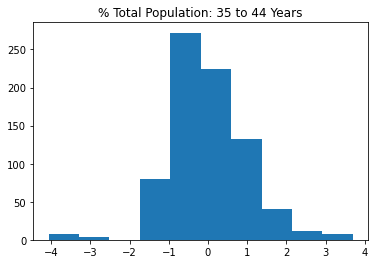

skewness: -0.018647708776119196


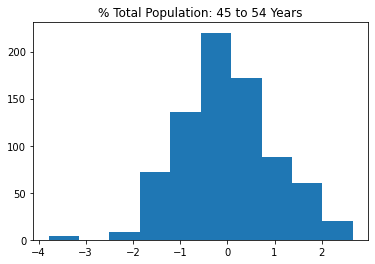

skewness: 0.023485747175819367


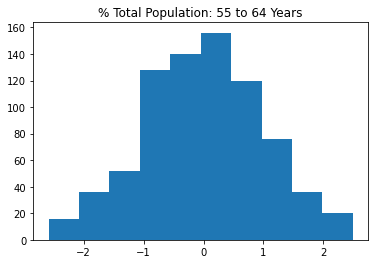

skewness: -0.09071875122987795


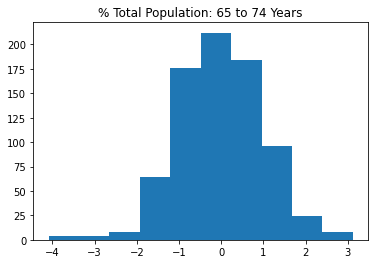

skewness: 0.15025618343883282


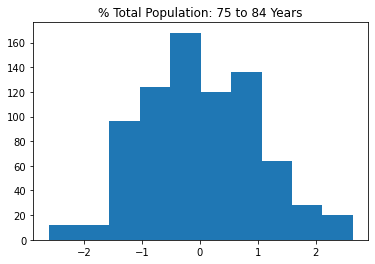

skewness: -0.1006866888642325


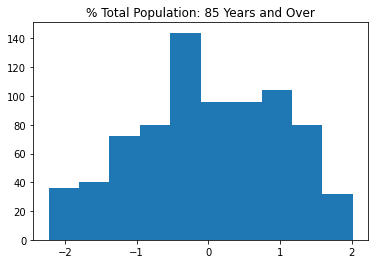

skewness: 0.002873277137215966


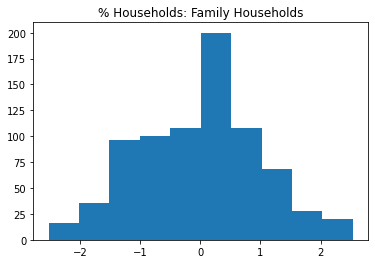

skewness: 0.04083128459026957


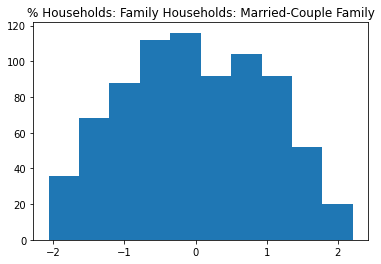

skewness: 0.024762679968671136


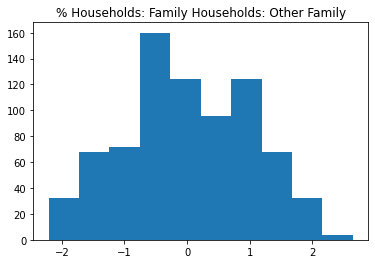

skewness: 0.04306304286783797


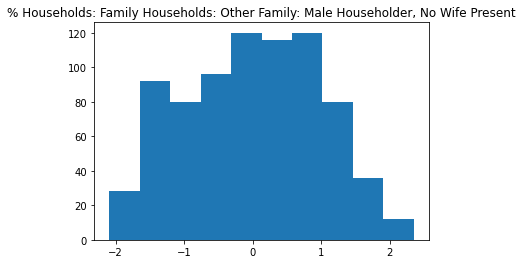

skewness: 0.10068669498310408


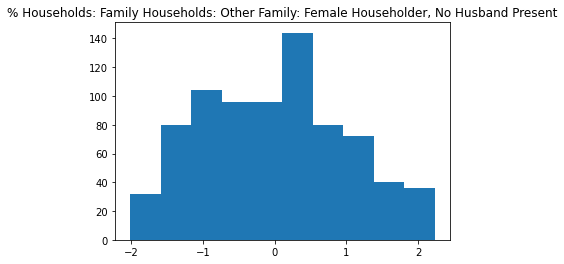

skewness: 0.14148190178781175


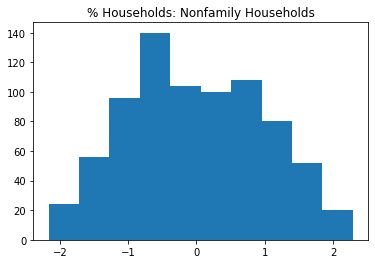

skewness: 0.07747140796368922


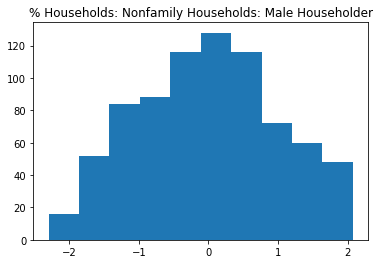

skewness: 0.06775618030216897


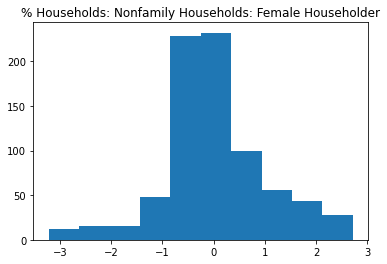

skewness: 0.7470851059715546


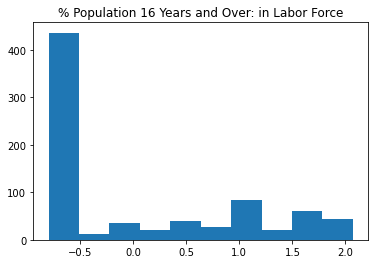

skewness: 0.06767609238709459


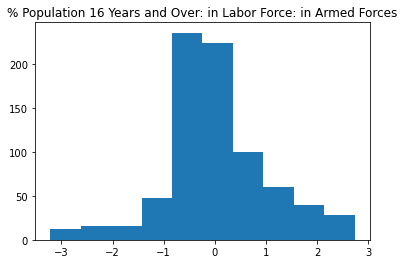

skewness: 0.06377368674531936


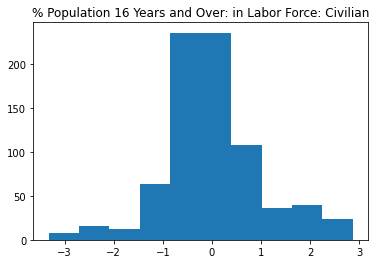

skewness: -0.0052054290068845755


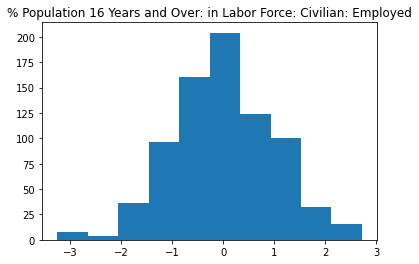

skewness: -0.06775611407105034


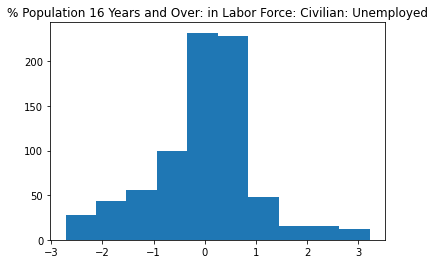

skewness: 0.7365112342425791


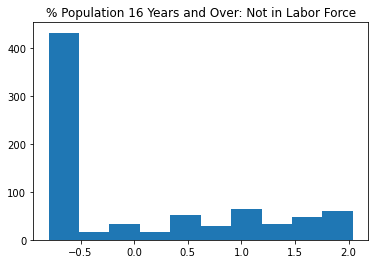

skewness: -0.736511253235446


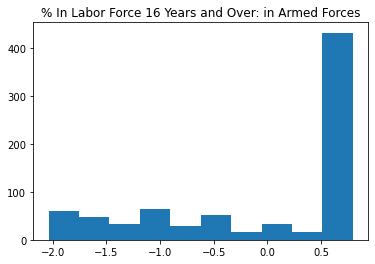

skewness: 0.12736249377331696


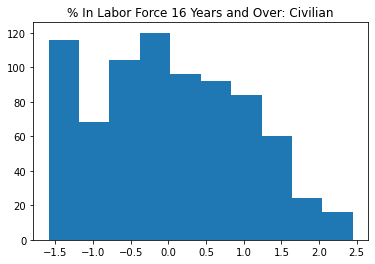

skewness: 0.026420291431020565


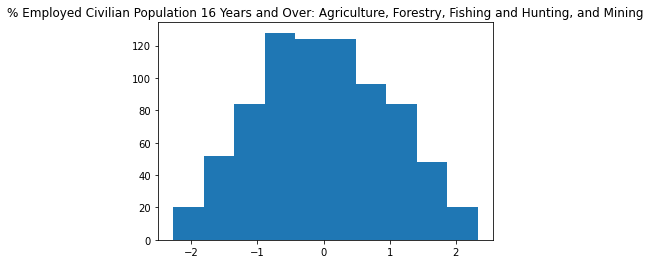

skewness: 0.07139897236547914


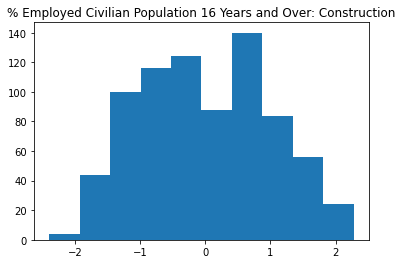

skewness: 0.08967671541758157


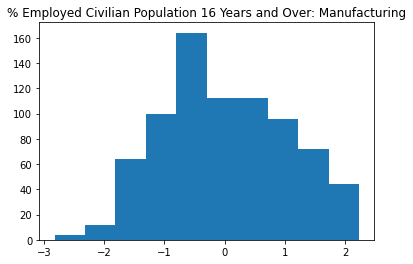

skewness: 0.017931348715966567


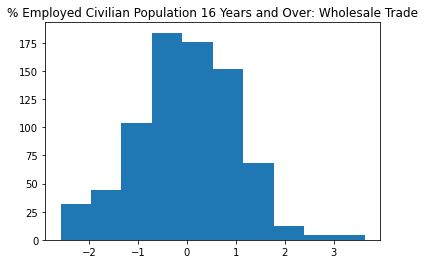

skewness: 0.026429045942165344


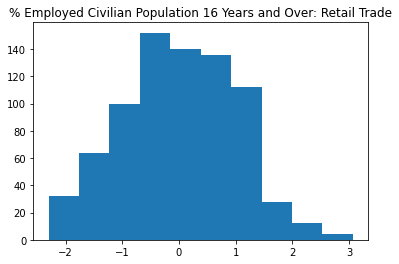

skewness: 0.3056833761263595


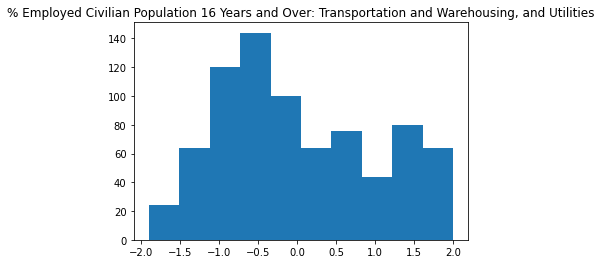

skewness: 0.07639351048523838


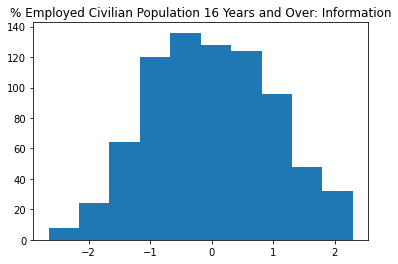

skewness: -0.06892751356842163


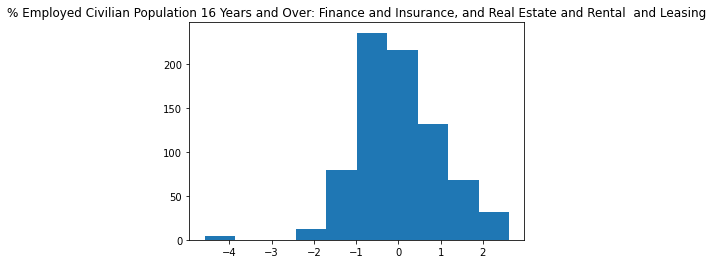

skewness: -0.013913407370118647


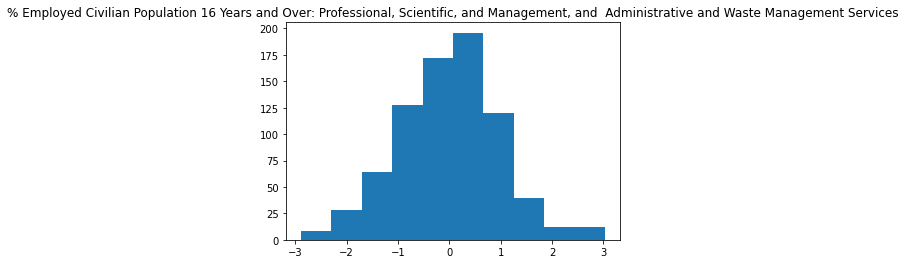

skewness: -0.10220115204092711


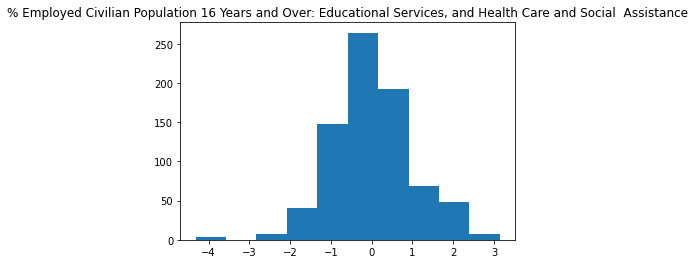

skewness: -0.022562834868312703


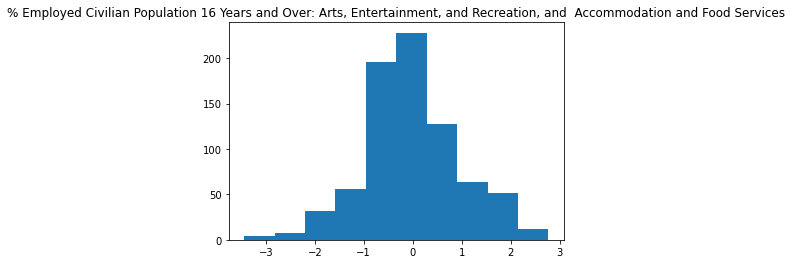

skewness: 0.058656229124440004


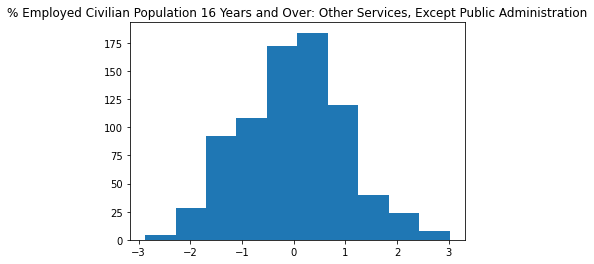

skewness: 0.005279681452842233


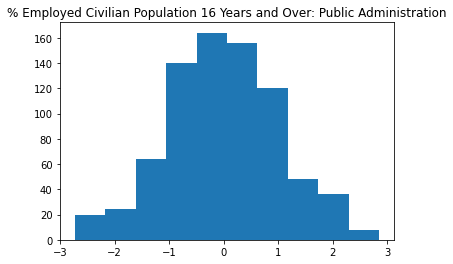

skewness: 0.005745102445576262


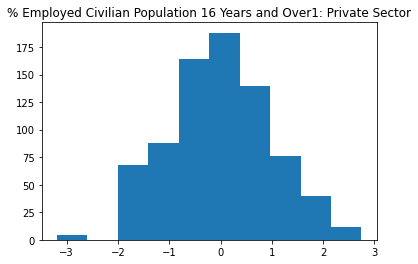

skewness: 0.017758889928703402


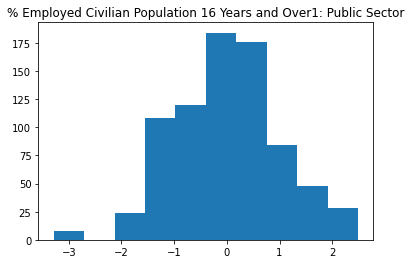

skewness: -0.12250544954849332


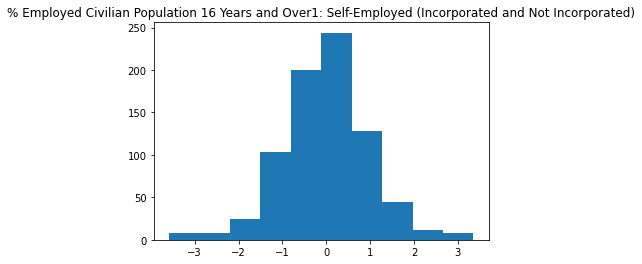

skewness: 0.336534828071675


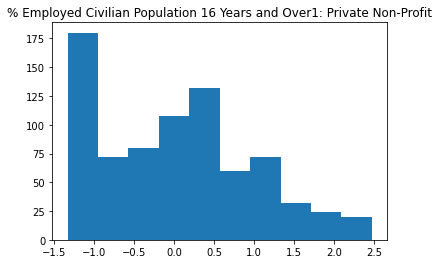

skewness: -0.04620636387463639


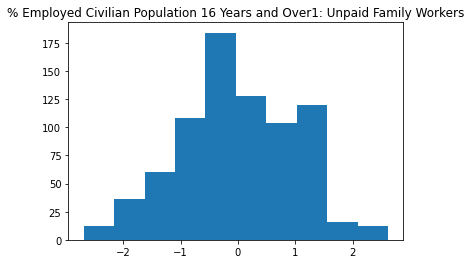

skewness: 0.04620624242758791


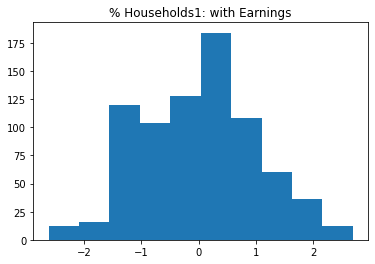

skewness: 0.05573406101214414


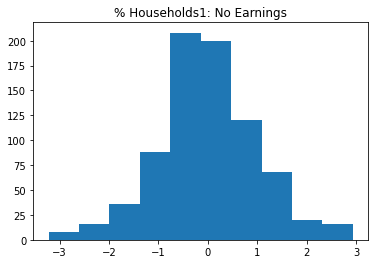

skewness: -0.05573408599250579


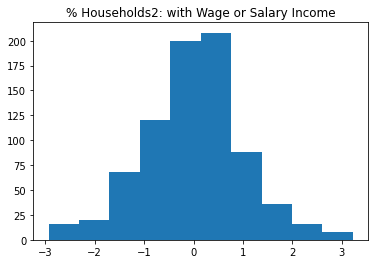

skewness: -0.004799172445005262


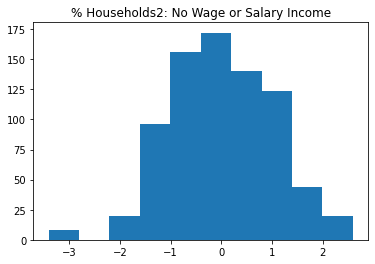

skewness: 0.0047991876872028735


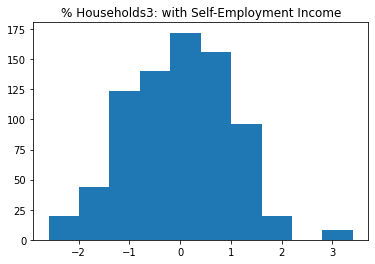

skewness: 0.19527606069262285


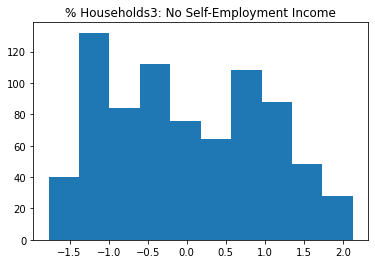

skewness: -0.1952760795293238


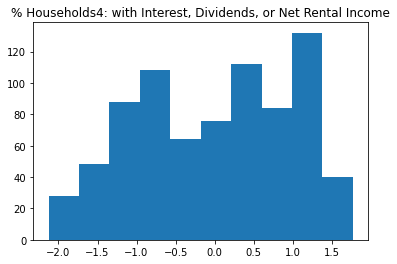

skewness: 0.005020376056947197


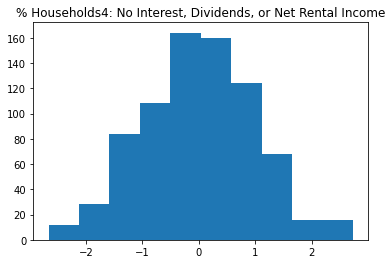

skewness: -0.005020389851757866


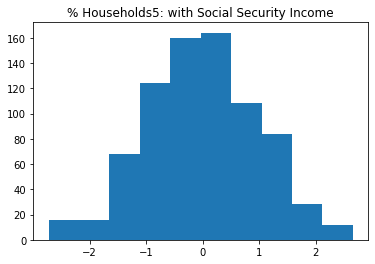

skewness: 0.0211487024641452


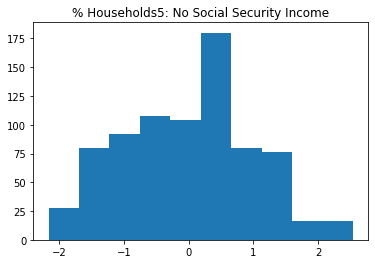

skewness: -0.021148722521451776


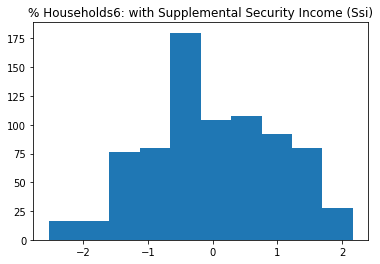

skewness: 0.1132086971614446


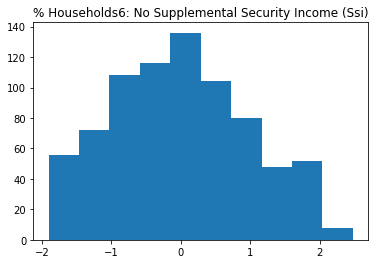

skewness: -0.11320864218307213


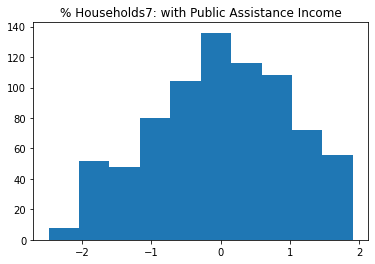

skewness: 0.011218896818347208


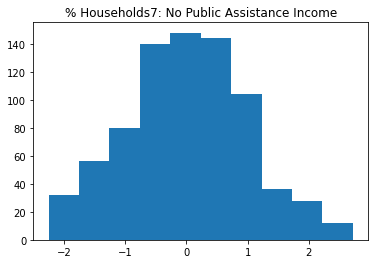

skewness: -0.011218854132577016


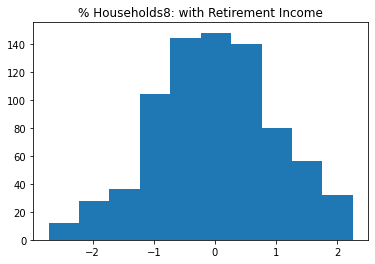

skewness: -0.003146060554536397


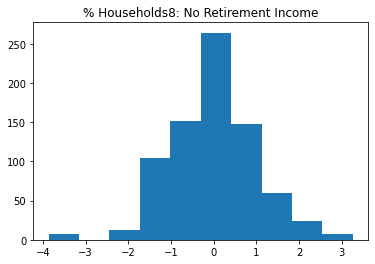

skewness: 0.0031460808129773862


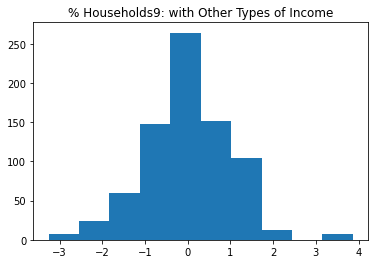

skewness: 0.17071695107860058


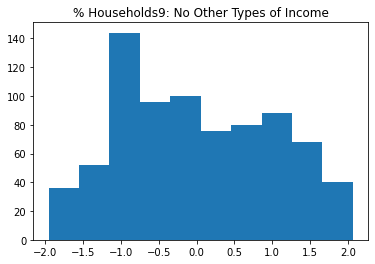

skewness: 0.1929799813043955


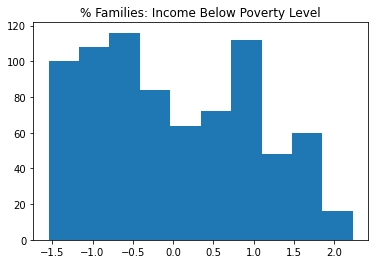

skewness: -0.045287589156859334


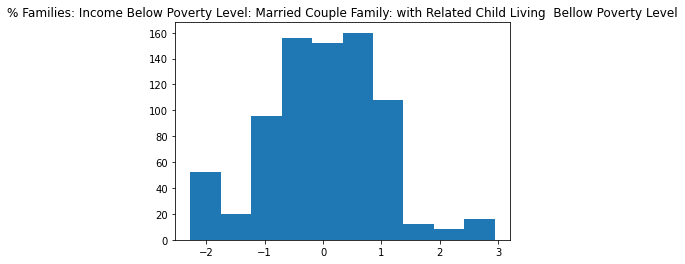

skewness: 0.20210760300143416


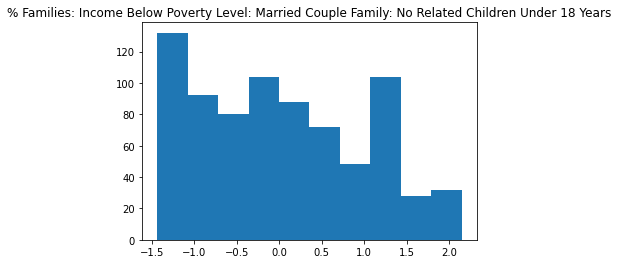

skewness: 0.29976683338769855


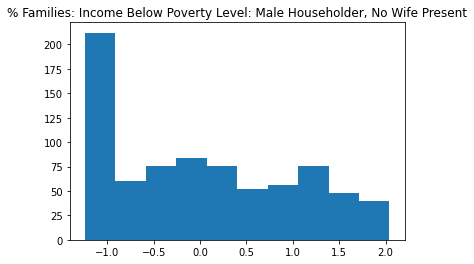

skewness: 0.20962194060494252


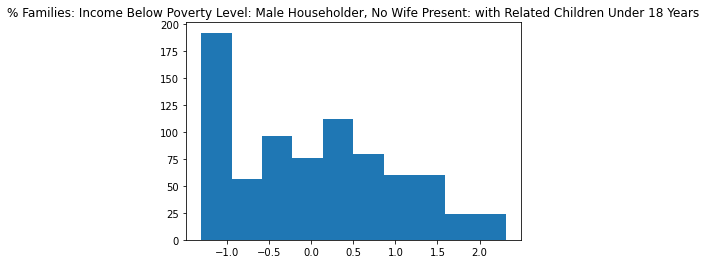

skewness: 0.21550361145108055


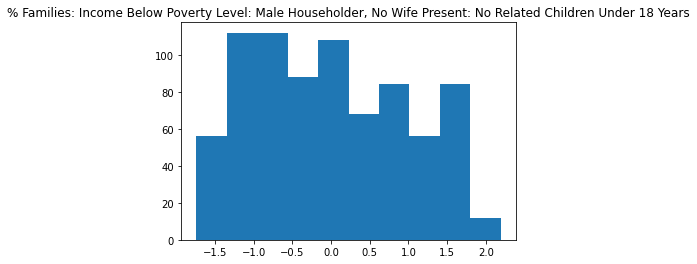

skewness: 0.2489677241040479


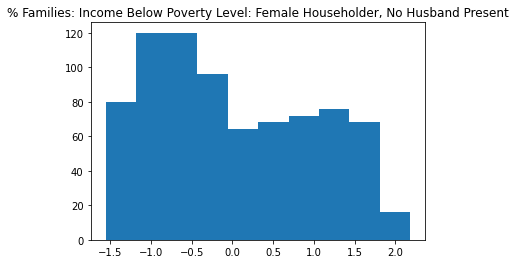

skewness: 0.11098700867982914


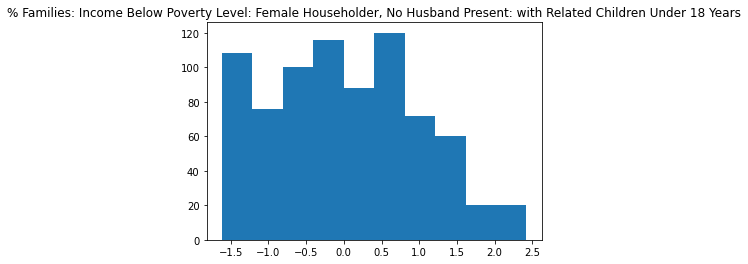

skewness: -0.1707169860269813


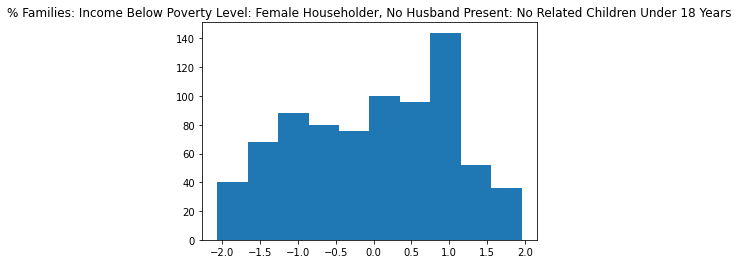

skewness: 0.11013431968694527


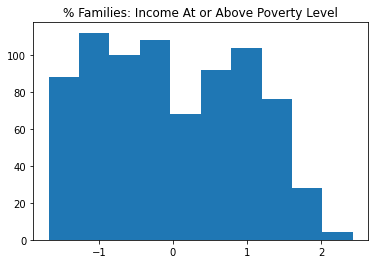

skewness: -0.11013428366479602


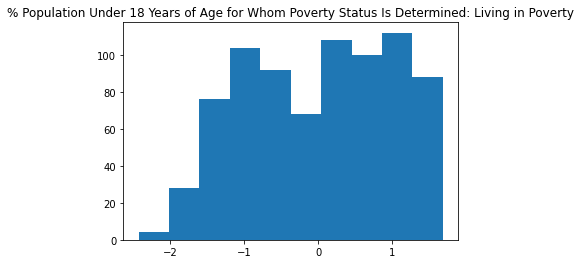

skewness: 0.11344820486267186


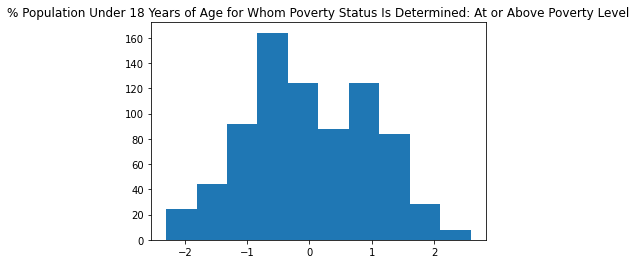

skewness: -0.11344824676161523


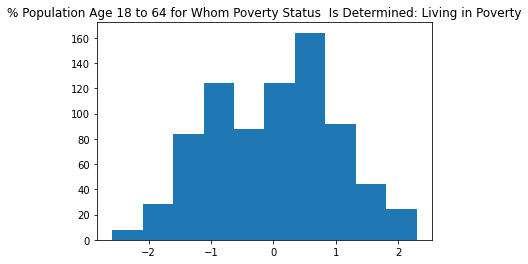

skewness: 0.06534807598736798


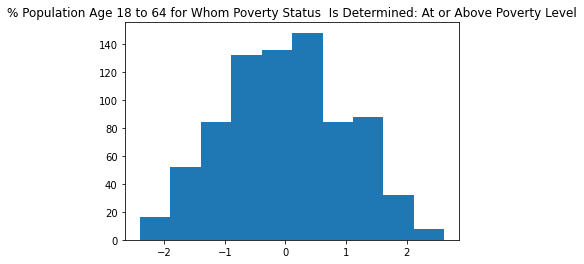

skewness: -0.06534803857268466


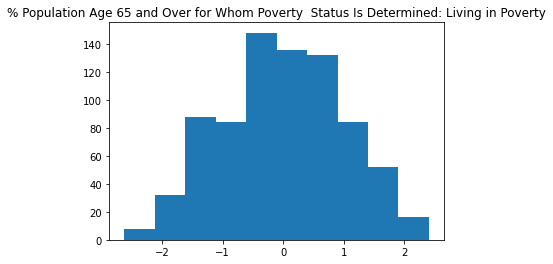

skewness: 0.09424183866999206


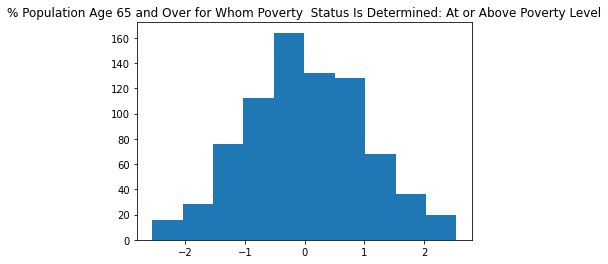

skewness: 0.1631559848319762


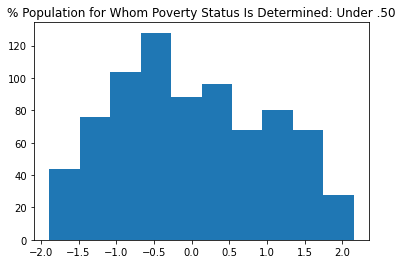

skewness: 0.10000017357174174


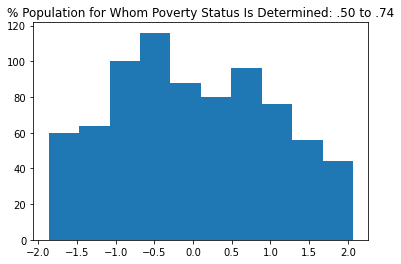

skewness: 0.04405099070411616


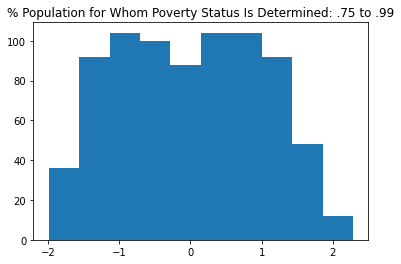

skewness: 0.010535070733433877


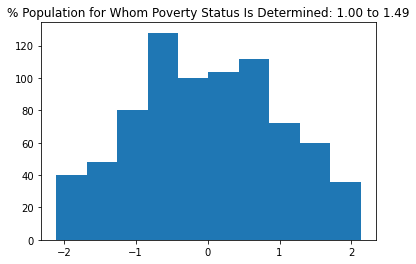

skewness: -0.05892015239167362


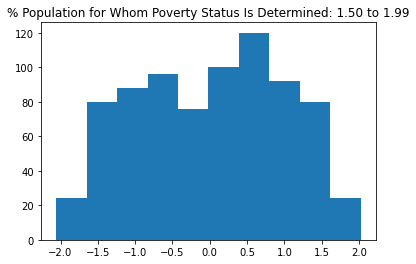

skewness: 0.12728451268575783


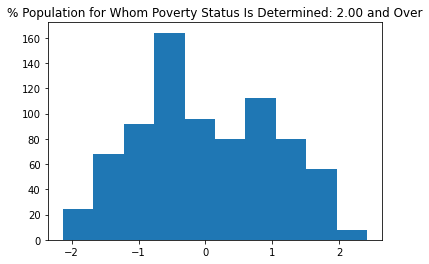

skewness: 0.024918266863838044


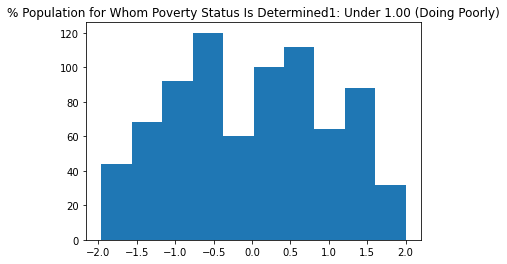

skewness: 0.058920175153568996


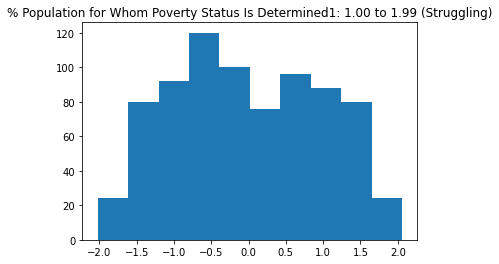

skewness: -0.05892015239167362


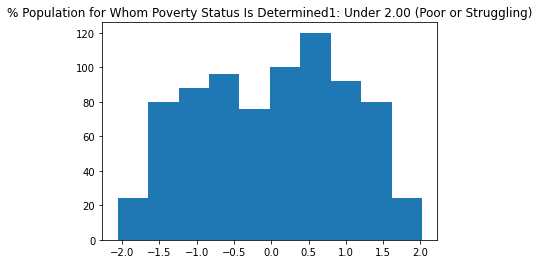

skewness: 0.1338994651757627


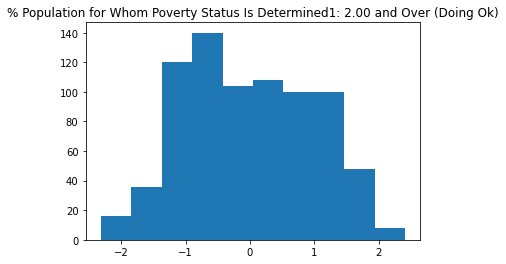

skewness: -0.1338994554660018


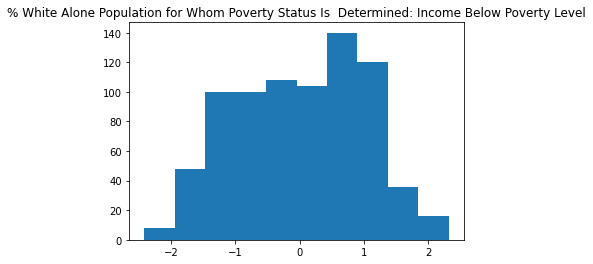

skewness: 0.07049363782242037


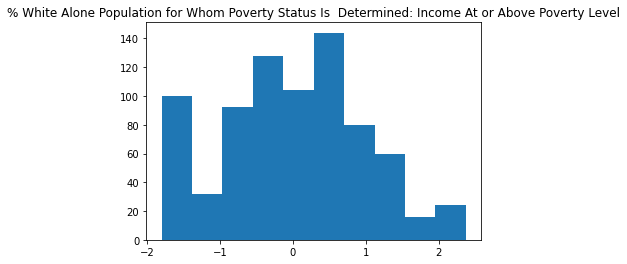

skewness: -0.07049361035655119


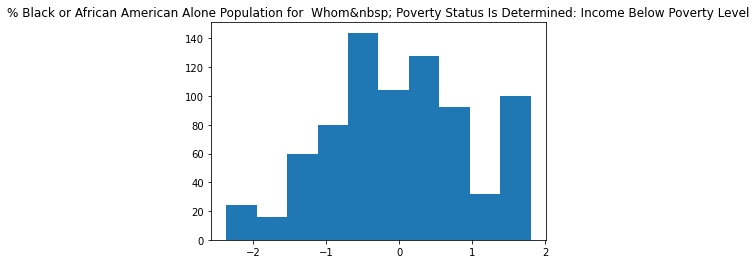

skewness: 0.3703099981647423


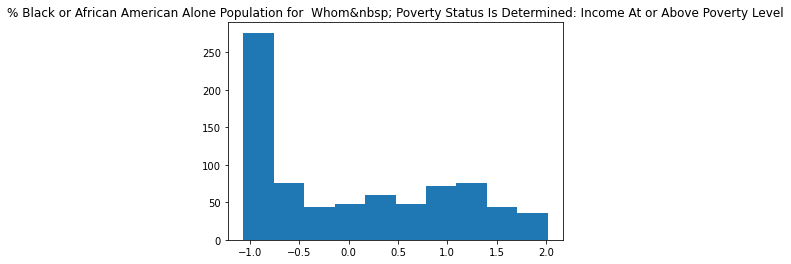

skewness: -0.37180733179300013


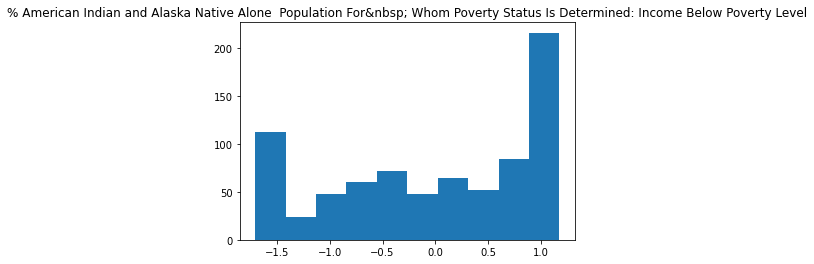

skewness: 0.11993562544415222


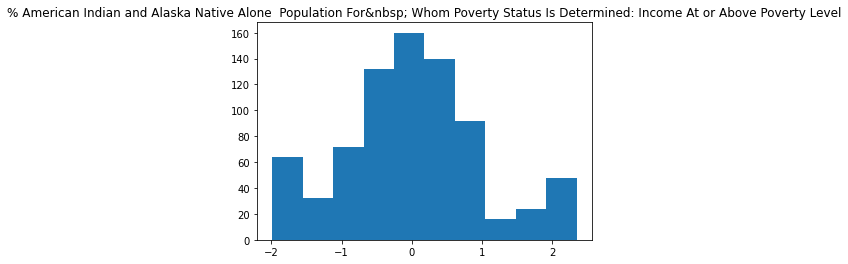

skewness: -0.18820859065829346


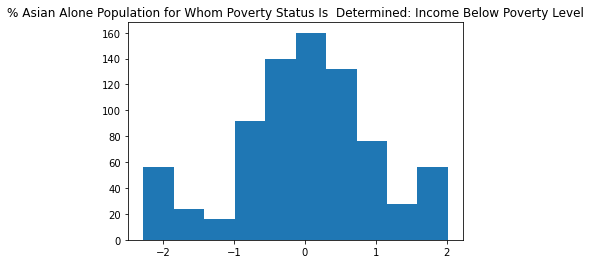

skewness: 1.170091815317092


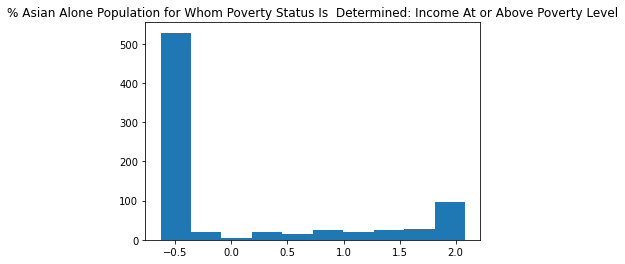

skewness: -0.586493511733741


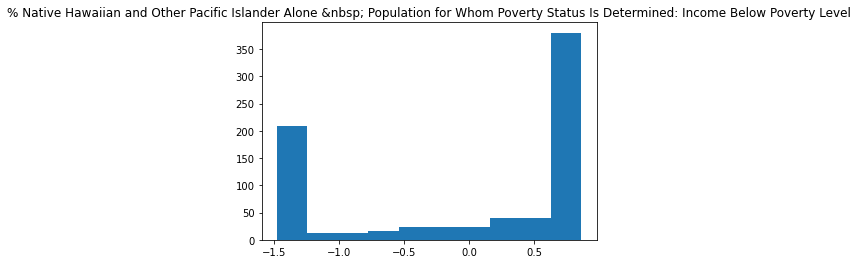

skewness: -0.011408883234603184


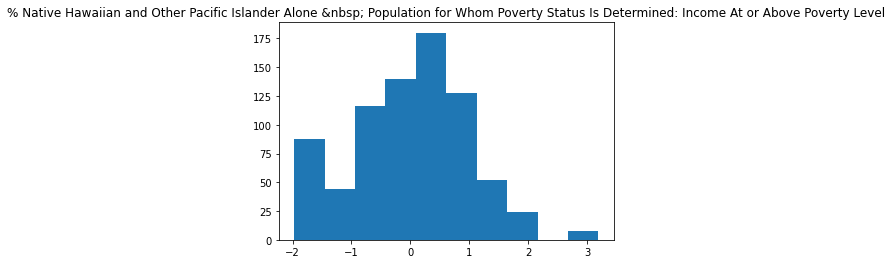

skewness: 0.02174630984442505


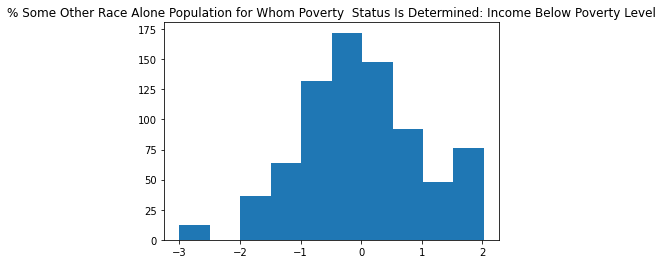

skewness: 0.11886033984832495


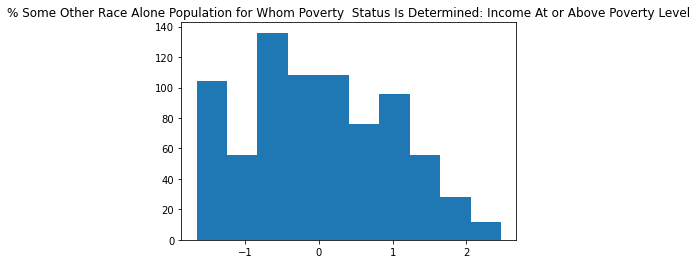

skewness: -0.12675306833487535


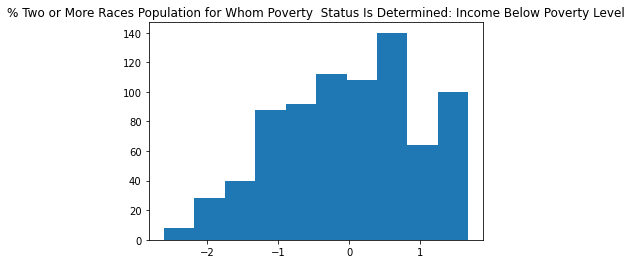

skewness: 0.01560435632539048


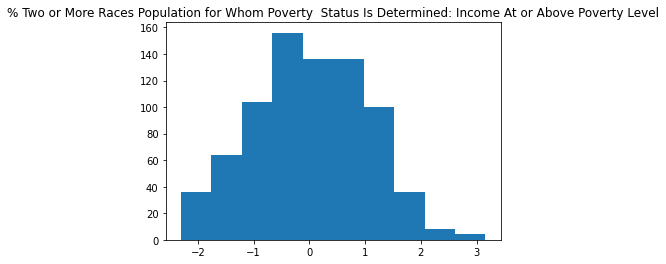

skewness: -0.01560436662776818


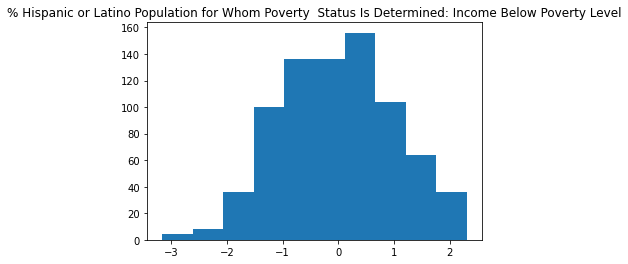

skewness: 0.1869338934754663


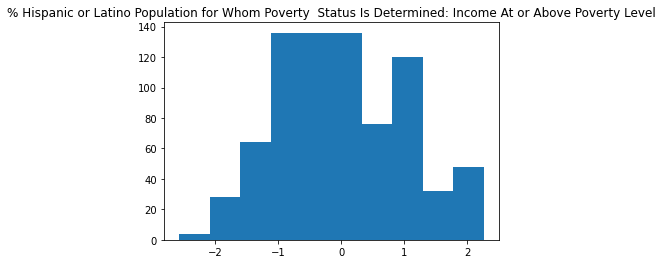

skewness: -0.18693395365660484


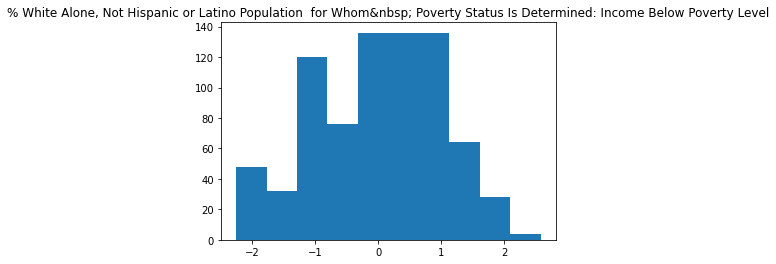

skewness: 0.010397000889074193


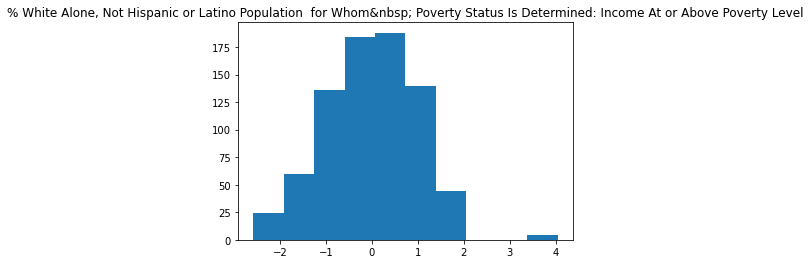

skewness: 0.1335082448912414


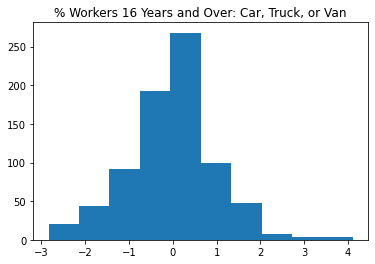

skewness: 0.0024499842911706042


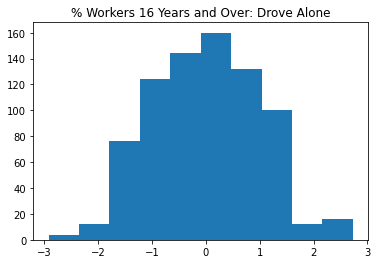

skewness: 0.27036444561961964


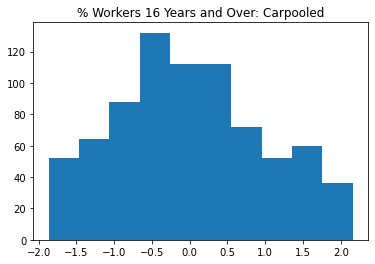

skewness: 0.23737759320053425


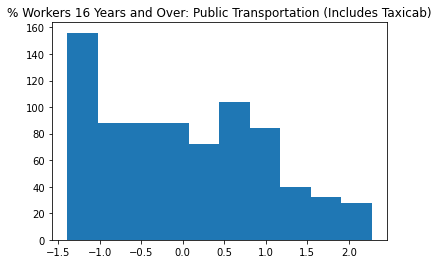

skewness: 0.3335972150736619


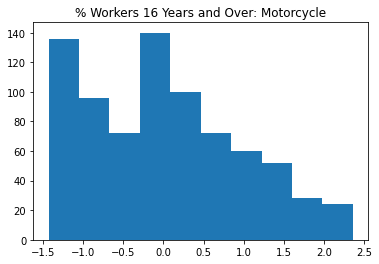

skewness: 0.46055782486073493


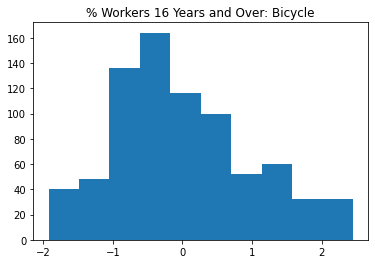

skewness: 0.10873849283003122


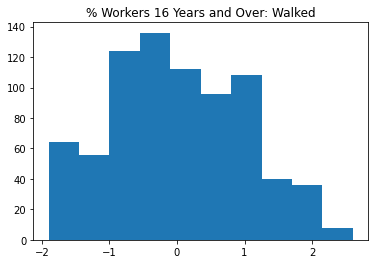

skewness: 0.15418809452037216


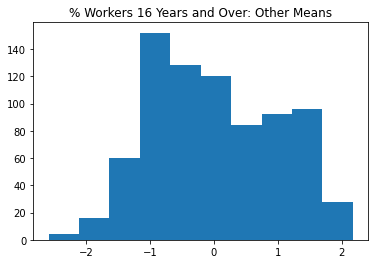

skewness: 0.014906131968731445


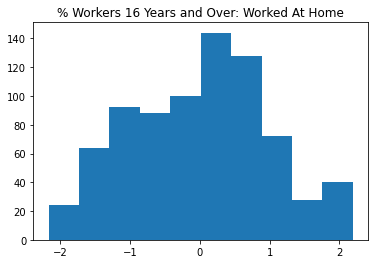

skewness: -0.004133783756216081


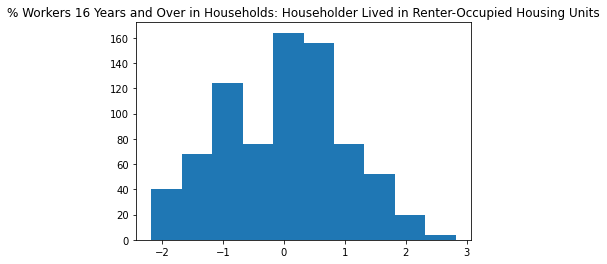

skewness: 0.04114428456144869


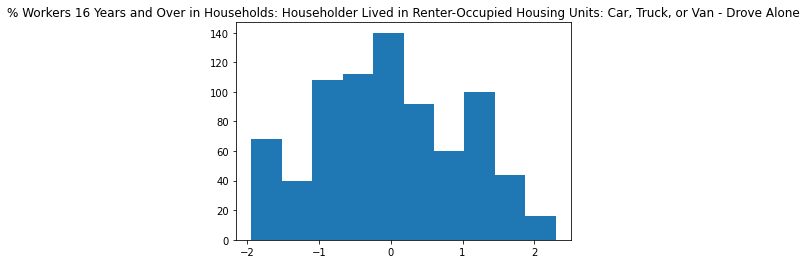

skewness: 0.4163495500006209


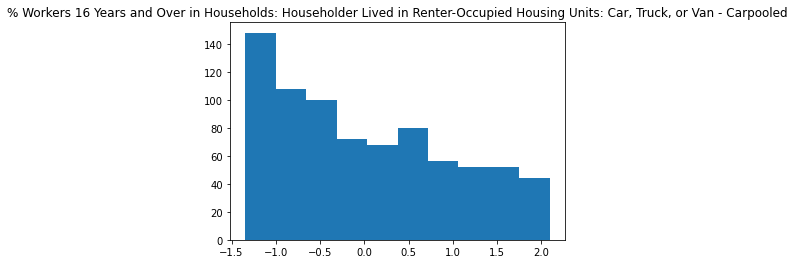

skewness: 0.5349485340775917


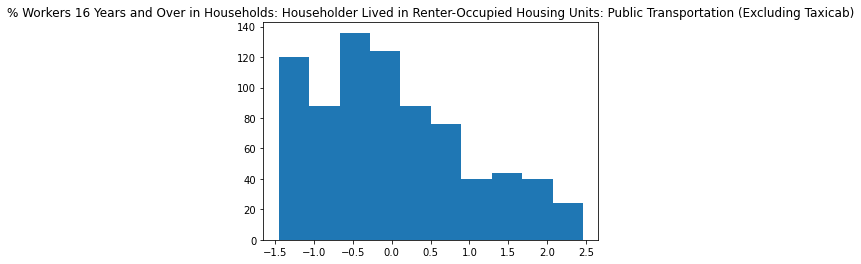

skewness: 0.1443406776114868


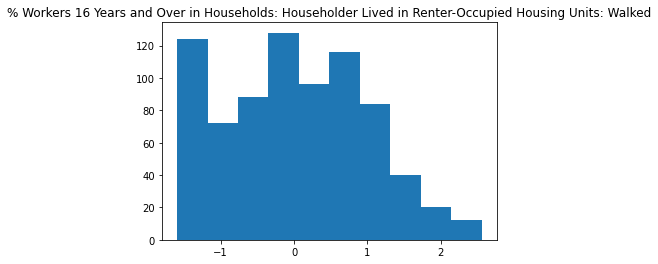

skewness: 0.18217588716194835


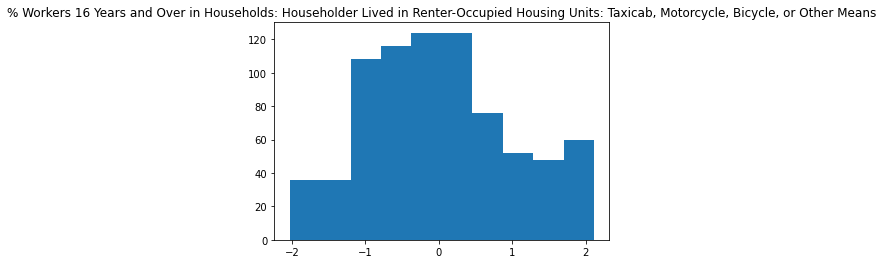

skewness: -0.15418813096389727


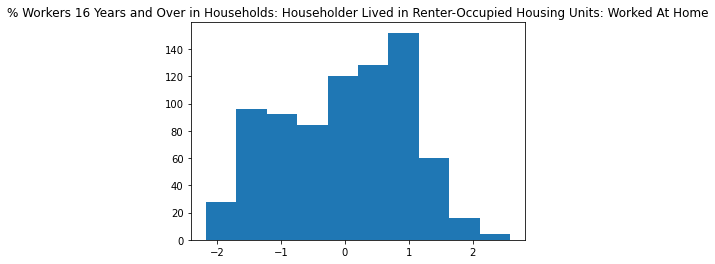

skewness: 0.009184738279341641


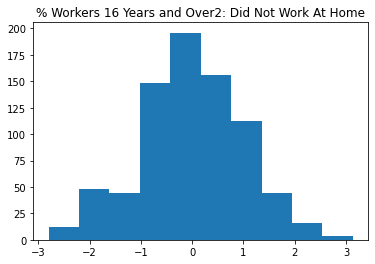

skewness: -0.014835674489368787


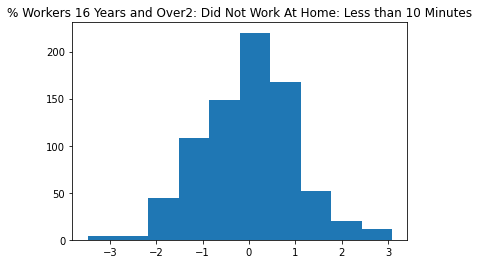

skewness: 0.0748400991723848


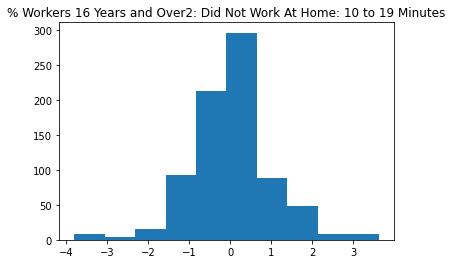

skewness: 0.0027356701916547506


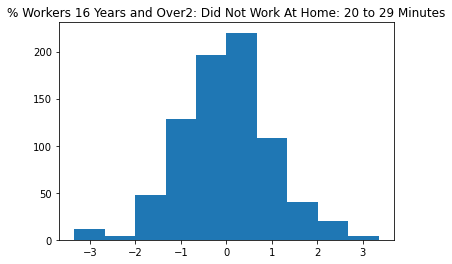

skewness: 0.030171068959102477


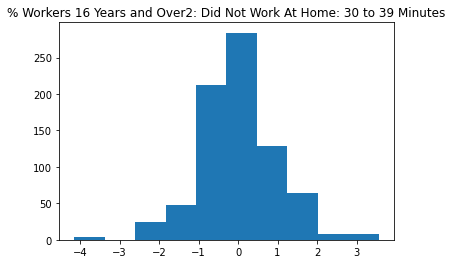

skewness: -0.06358785170833092


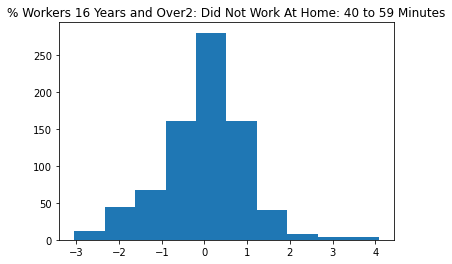

skewness: -0.07742278579199675


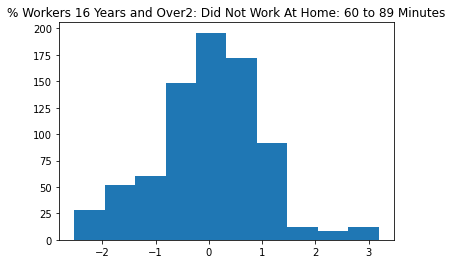

skewness: 0.15418809452037216


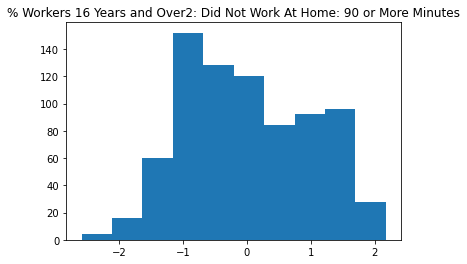

skewness: 0.062011996962361066


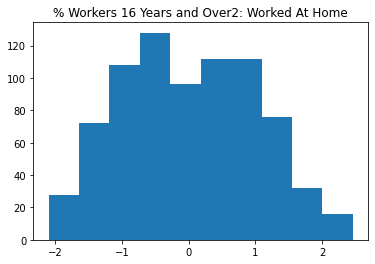

skewness: -0.06201197486721861


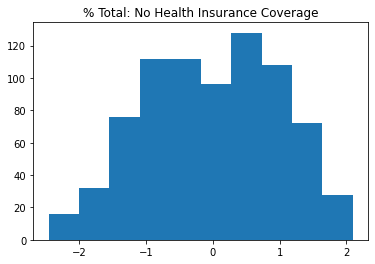

skewness: 0.01145699514105049


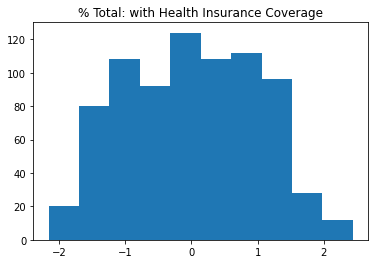

skewness: -0.04357198800754257


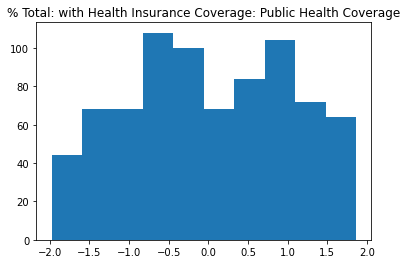

skewness: 0.002406260007986745


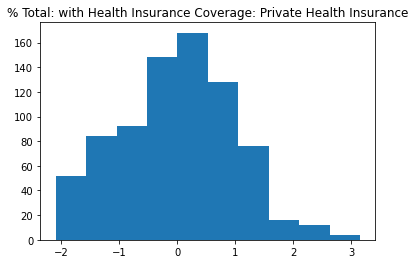

skewness: -0.002406210651450262


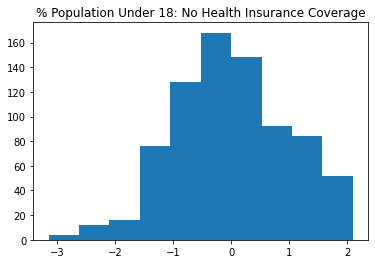

skewness: 0.012246748211541342


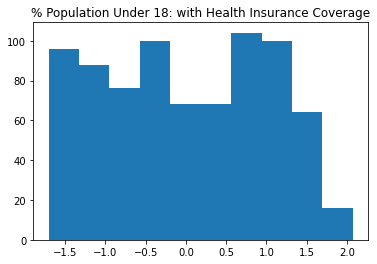

skewness: -0.02068152537226091


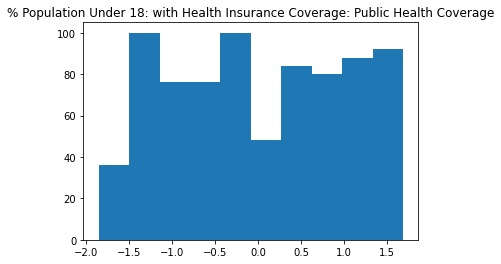

skewness: 0.02255308891953771


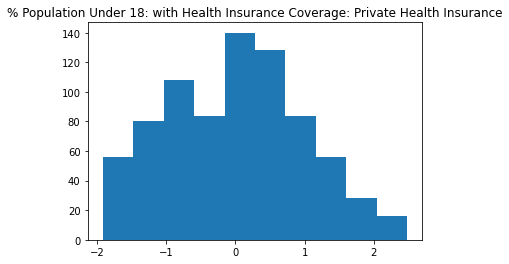

skewness: 0.04695122026974637


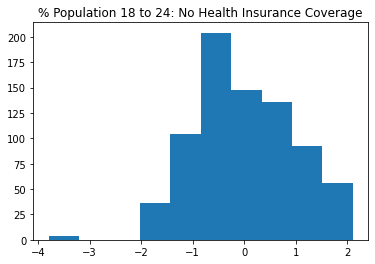

skewness: 0.040282018033433085


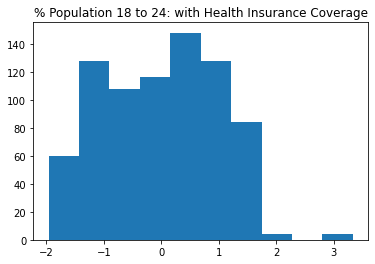

skewness: -0.03548182632146945


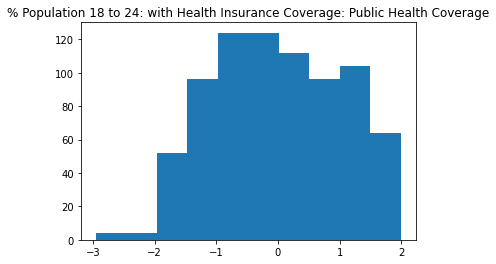

skewness: 0.015969922116615864


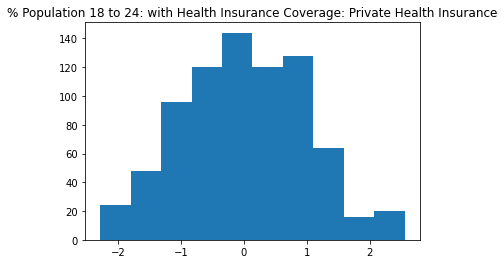

skewness: -0.015969870717299328


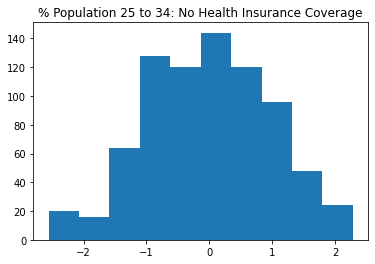

skewness: 0.010981065937405833


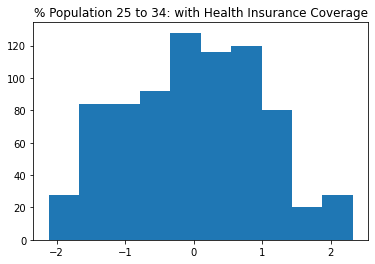

skewness: -0.006188075214177733


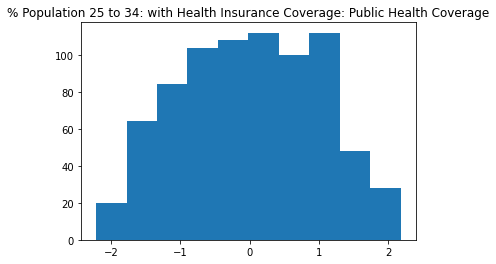

skewness: 0.10626010071231635


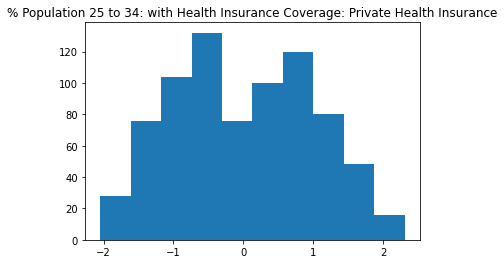

skewness: -0.10626009522598825


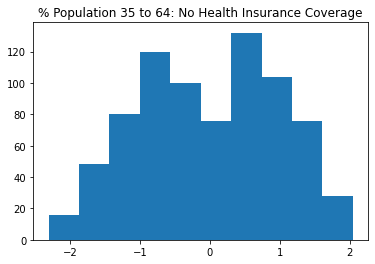

skewness: 0.021516436101486694


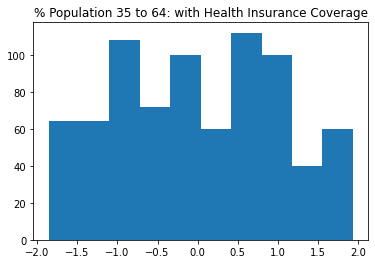

skewness: -0.051304602892793635


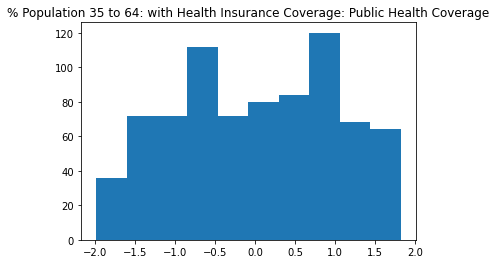

skewness: 0.20284970055304194


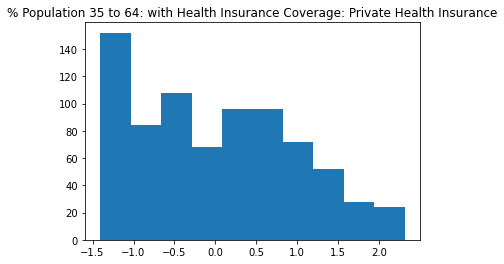

skewness: -0.20284972539727708


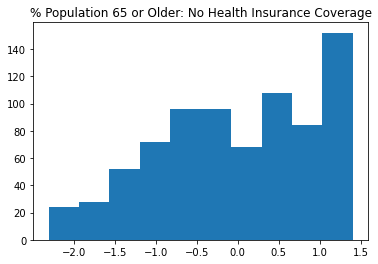

skewness: 0.04416539141589146


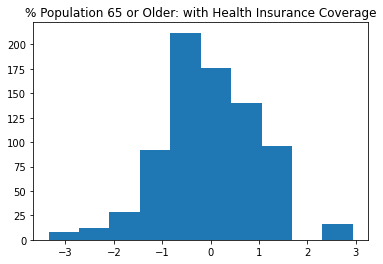

skewness: 0.008148672744253339


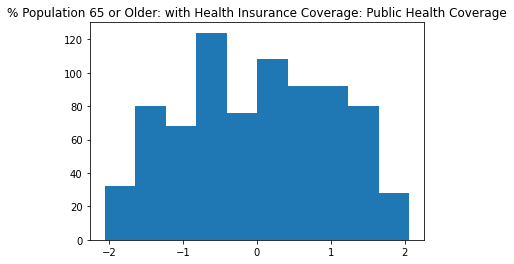

skewness: 0.03415145809135579


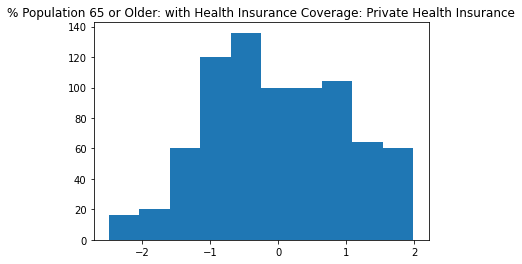

skewness: 0.06710463068591076


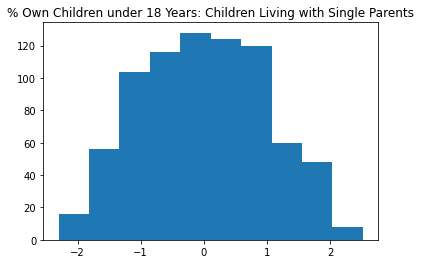

skewness: 0.0030612461622252997


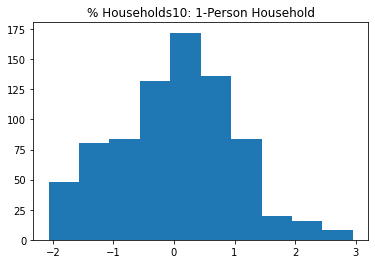

skewness: 0.038895629697151414


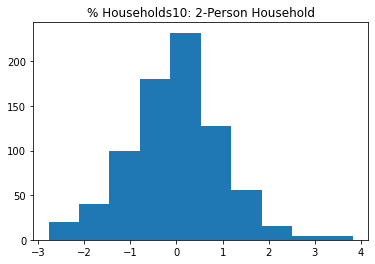

skewness: 0.04633113038385102


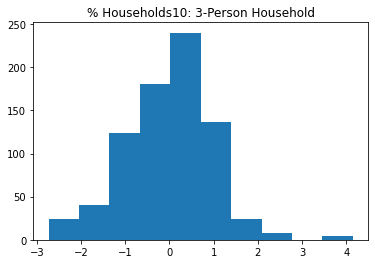

skewness: 0.031150714741876806


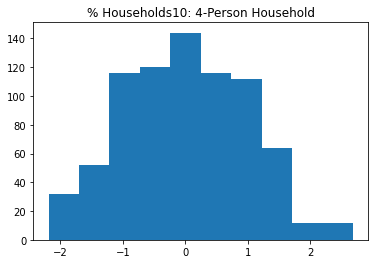

skewness: 0.14606316339980985


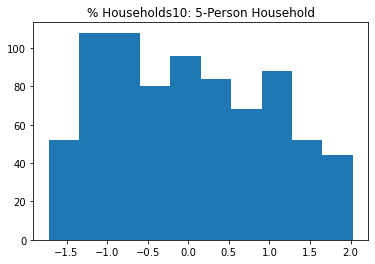

skewness: 0.2857931789768569


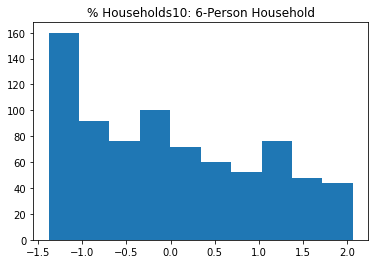

In [98]:
for i in range(wc4m_X_train_arr[0].shape[1]):
    s = skew(wc4m_X_train_arr[0][:,i])
    print("skewness: " + str(s))
    plt.hist(wc4m_X_train_arr[0][:,i])
    plt.title(feature_names[i-1])
    plt.show()
        


In [ ]:
for i in range(1, month_data_with_census.shape[1]-1):
    plt.hist(month_data_with_census[:,i])
    plt.title(feature_names[i-1])
    plt.show()